**Mount to Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import Necessary Libraries**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from tqdm import tqdm
import time
import seaborn as sns
import shutil

1. Load Preprocessed Tensors

In [ ]:
X_train_tensor = torch.load('/content/drive/MyDrive/Thesis - Undergraduate Ch./Preprocessing/X_train_7000_tensor_most.pt')
X_test_tensor = torch.load('/content/drive/MyDrive/Thesis - Undergraduate Ch./Preprocessing/X_test_1500_tensor_most.pt')
y_test_tensor = torch.load('/content/drive/MyDrive/Thesis - Undergraduate Ch./Preprocessing/y_test_1500_tensor_most.pt')

print("Preprocessed tensors loaded successfully!")

<ipython-input-3-5fc4154c7302>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_train_tensor = torch.load('/content/drive/MyDrive/Thesis - Undergraduate Ch./Preprocessing/

Preprocessed tensors loaded successfully!


In [ ]:
# Print the output shape for each data
print(f"X_train shape: {X_train_tensor.shape}")
print(f"X_test shape: {X_test_tensor.shape}")
print(f"y_test shape: {y_test_tensor.shape}")

X_train shape: torch.Size([7000, 1, 100, 87])
X_test shape: torch.Size([3000, 1, 100, 87])
y_test shape: torch.Size([3000])


2. Define VAE-CNN Architecture

In [ ]:
#@title Vocabulary = 65 (Dataset 1000: 700 Legitimate & 150 Legitimate + 150 Phishing)
class VAE_CNN(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE_CNN, self).__init__()

        # Encoder (CNN)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Output size *CNN)
        self.flattened_size = 128 * 12 * 8  

        # Fully Connected for mean and logvar
        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_size, latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim, self.flattened_size)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1), 
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1) 
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.fc_decode(z)
        x = x.view(-1, 128, 12, 8)  # Reshape to CNN
        x = self.decoder(x)
        return F.interpolate(x, size=(100, 65), mode='bilinear', align_corners=False)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# Display a summary of the model architecture
model = VAE_CNN()
summary(model, input_size=[(1, 100, 65)], batch_size=1)  # (batch, channels, height, width = N, C, H, W)

In [ ]:
#@title Vocabulary = 78 (Dataset 2000: 1400 Legitimate & 300 Legitimate + 300 Phishing)
class VAE_CNN(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE_CNN, self).__init__()

        # Encoder (CNN)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Output size (CNN)
        self.flattened_size = 128 * 12 * 9 

        # Fully Connected for mean and logvar
        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_size, latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim, self.flattened_size)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.fc_decode(z)
        x = x.view(-1, 128, 12, 9)
        x = self.decoder(x)
        return F.interpolate(x, size=(100, 78), mode='bilinear', align_corners=False)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# Display a summary of the model architecture
model = VAE_CNN()
summary(model, input_size=[(1, 100, 78)], batch_size=1) # (batch, channels, height, width = N, C, H, W)

In [ ]:
#@title Vocabulary = 87 (Dataset 9000: 6300 Legitimate & 1350 Legitimate + 1350 Phishing)
class VAE_CNN(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE_CNN, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Output size (CNN)
        self.flattened_size = 128 * 12 * 10 

        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_size, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, self.flattened_size)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1, output_padding=(0,1)),
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
      x = self.fc_decode(z)
      x = x.view(-1, 128, 12, 10)
      x = self.decoder(x)
      return F.interpolate(x, size=(100, 87), mode='bilinear', align_corners=False)


    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# Display a summary of the model architecture
model = VAE_CNN()
summary(model, input_size=[(1, 100, 87)], batch_size=1) # (batch, channels, height, width = N, C, H, W)

In [ ]:
#@title Vocabulary = 88 (Dataset 10000: 7000 Legitimate & 1500 Legitimate + 1500 Phishing)
class VAE_CNN(nn.Module):
    def __init__(self, latent_dim=4):
        super(VAE_CNN, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1 ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Output size (CNN)
        self.flattened_size = 128 * 12 * 11  # 16896

        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_size, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, self.flattened_size)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1, output_padding=(0,1)),
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
      x = self.fc_decode(z)
      x = x.view(-1, 128, 12, 11)
      x = self.decoder(x)
      return F.interpolate(x, size=(100, 88), mode='bilinear', align_corners=False)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# Display a summary of the model architecture
model = VAE_CNN()
summary(model, input_size=[(1, 100, 88)], batch_size=1) # (batch, channels, height, width = N, C, H, W)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 50, 44]             544
       BatchNorm2d-2            [1, 32, 50, 44]              64
              ReLU-3            [1, 32, 50, 44]               0
            Conv2d-4            [1, 64, 25, 22]          32,832
       BatchNorm2d-5            [1, 64, 25, 22]             128
              ReLU-6            [1, 64, 25, 22]               0
            Conv2d-7           [1, 128, 12, 11]         131,200
       BatchNorm2d-8           [1, 128, 12, 11]             256
              ReLU-9           [1, 128, 12, 11]               0
           Linear-10                     [1, 4]          67,588
           Linear-11                     [1, 4]          67,588
           Linear-12                 [1, 16896]          84,480
  ConvTranspose2d-13            [1, 64, 24, 22]         131,136
      BatchNorm2d-14            [1, 64,

In [ ]:
#@title Vocabulary = 84 (Dataset 10000: 7000 Legitimate & 1500 Legitimate + 1500 Phishing)
class VAE_CNN(nn.Module):
    def __init__(self, latent_dim=4):
        super(VAE_CNN, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Output size (CNN)
        self.flattened_size = 128 * 12 * 10  

        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_size, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, self.flattened_size)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1, output_padding=(0,1)),
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
      x = self.fc_decode(z)
      x = x.view(-1, 128, 12, 10)
      x = self.decoder(x)
      return F.interpolate(x, size=(100, 84), mode='bilinear', align_corners=False)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# Display a summary of the model architecture
model = VAE_CNN()
summary(model, input_size=[(1, 100, 84)], batch_size=1) # (batch, channels, height, width = N, C, H, W)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 50, 42]             544
       BatchNorm2d-2            [1, 32, 50, 42]              64
              ReLU-3            [1, 32, 50, 42]               0
            Conv2d-4            [1, 64, 25, 21]          32,832
       BatchNorm2d-5            [1, 64, 25, 21]             128
              ReLU-6            [1, 64, 25, 21]               0
            Conv2d-7           [1, 128, 12, 10]         131,200
       BatchNorm2d-8           [1, 128, 12, 10]             256
              ReLU-9           [1, 128, 12, 10]               0
           Linear-10                     [1, 4]          61,444
           Linear-11                     [1, 4]          61,444
           Linear-12                 [1, 15360]          76,800
  ConvTranspose2d-13            [1, 64, 24, 20]         131,136
      BatchNorm2d-14            [1, 64,

In [ ]:
#@title Vocabulary = 89 (Dataset 10000: 7000 Legitimate & 1500 Legitimate + 1500 Phishing)
class VAE_CNN(nn.Module):
    def __init__(self, latent_dim=4):
        super(VAE_CNN, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Output size (CNN)
        self.flattened_size = 128 * 12 * 11  

        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_size, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, self.flattened_size)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1, output_padding=(0,1)),
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
      x = self.fc_decode(z)
      x = x.view(-1, 128, 12, 11)
      x = self.decoder(x)
      return F.interpolate(x, size=(100, 89), mode='bilinear', align_corners=False)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# Display a summary of the model architecture
model = VAE_CNN()
summary(model, input_size=[(1, 100, 89)], batch_size=1) # (batch, channels, height, width = N, C, H, W)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 50, 44]             544
       BatchNorm2d-2            [1, 32, 50, 44]              64
              ReLU-3            [1, 32, 50, 44]               0
            Conv2d-4            [1, 64, 25, 22]          32,832
       BatchNorm2d-5            [1, 64, 25, 22]             128
              ReLU-6            [1, 64, 25, 22]               0
            Conv2d-7           [1, 128, 12, 11]         131,200
       BatchNorm2d-8           [1, 128, 12, 11]             256
              ReLU-9           [1, 128, 12, 11]               0
           Linear-10                     [1, 4]          67,588
           Linear-11                     [1, 4]          67,588
           Linear-12                 [1, 16896]          84,480
  ConvTranspose2d-13            [1, 64, 24, 22]         131,136
      BatchNorm2d-14            [1, 64,

In [ ]:
#@title Vocabulary = 87 (Dataset 10000: 7000 Legitimate & 1500 Legitimate + 1500 Phishing)
class VAE_CNN(nn.Module):
    def __init__(self, latent_dim=4):
        super(VAE_CNN, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Output size (CNN)
        self.flattened_size = 128 * 12 * 10 

        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_size, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, self.flattened_size)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1, output_padding=(0,1)),
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
      x = self.fc_decode(z)
      x = x.view(-1, 128, 12, 10)
      x = self.decoder(x)
      return F.interpolate(x, size=(100, 87), mode='bilinear', align_corners=False)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# Display a summary of the model architecture
model = VAE_CNN()
summary(model, input_size=[(1, 100, 87)], batch_size=1) # (batch, channels, height, width = N, C, H, W)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 50, 43]             544
       BatchNorm2d-2            [1, 32, 50, 43]              64
              ReLU-3            [1, 32, 50, 43]               0
            Conv2d-4            [1, 64, 25, 21]          32,832
       BatchNorm2d-5            [1, 64, 25, 21]             128
              ReLU-6            [1, 64, 25, 21]               0
            Conv2d-7           [1, 128, 12, 10]         131,200
       BatchNorm2d-8           [1, 128, 12, 10]             256
              ReLU-9           [1, 128, 12, 10]               0
           Linear-10                     [1, 4]          61,444
           Linear-11                     [1, 4]          61,444
           Linear-12                 [1, 15360]          76,800
  ConvTranspose2d-13            [1, 64, 24, 20]         131,136
      BatchNorm2d-14            [1, 64,

In [ ]:
#@title Vocabulary = 89 (Dataset 11000: 7700 Legitimate & 1650 Legitimate + 1650 Phishing)
class VAE_CNN(nn.Module):
    def __init__(self, latent_dim=64):
        super(VAE_CNN, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Output size (CNN)
        self.flattened_size = 128 * 12 * 11  

        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_size, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, self.flattened_size)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1, output_padding=(0,1)),
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
      x = self.fc_decode(z)
      x = x.view(-1, 128, 12, 11)
      x = self.decoder(x)
      return F.interpolate(x, size=(100, 89), mode='bilinear', align_corners=False)


    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# Display a summary of the model architecture
model = VAE_CNN()
summary(model, input_size=[(1, 100, 89)], batch_size=1) # (batch, channels, height, width = N, C, H, W)

In [ ]:
#@title Vocabulary = 220 (Dataset 20000: 14000 Legitimate & 3000 Legitimate + 3000 Phishing)
class VAE_CNN(nn.Module):
    def __init__(self, latent_dim=64):
        super(VAE_CNN, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Output size (CNN)
        self.flattened_size = 128 * 12 * 27 

        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_size, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, self.flattened_size)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1, output_padding=(0,1)),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
      x = self.fc_decode(z)
      x = x.view(-1, 128, 12, 27)
      x = self.decoder(x)
      return F.interpolate(x, size=(100, 220), mode='bilinear', align_corners=False)


    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# Display a summary of the model architecture
model = VAE_CNN()
summary(model, input_size=[(1, 100, 220)], batch_size=1) # (batch, channels, height, width = N, C, H, W)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [1, 32, 50, 110]             544
       BatchNorm2d-2           [1, 32, 50, 110]              64
              ReLU-3           [1, 32, 50, 110]               0
            Conv2d-4            [1, 64, 25, 55]          32,832
       BatchNorm2d-5            [1, 64, 25, 55]             128
              ReLU-6            [1, 64, 25, 55]               0
            Conv2d-7           [1, 128, 12, 27]         131,200
       BatchNorm2d-8           [1, 128, 12, 27]             256
              ReLU-9           [1, 128, 12, 27]               0
           Linear-10                    [1, 64]       2,654,272
           Linear-11                    [1, 64]       2,654,272
           Linear-12                 [1, 41472]       2,695,680
  ConvTranspose2d-13            [1, 64, 24, 54]         131,136
             ReLU-14            [1, 64,

In [ ]:
#@title Vocabulary = 85 (Dataset 15000: 10500 Legitimate & 2250 Legitimate + 1250 Phishing)
class VAE_CNN(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE_CNN, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Output size (CNN)
        self.flattened_size = 128 * 12 * 10  

        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_size, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, self.flattened_size)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1, output_padding=(0,1)),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
      x = self.fc_decode(z)
      x = x.view(-1, 128, 12, 10)
      x = self.decoder(x)
      return F.interpolate(x, size=(100, 85), mode='bilinear', align_corners=False)


    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# Display a summary of the model architecture
model = VAE_CNN()
summary(model, input_size=[(1, 100, 85)], batch_size=1) # (batch, channels, height, width = N, C, H, W)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 50, 42]             544
       BatchNorm2d-2            [1, 32, 50, 42]              64
              ReLU-3            [1, 32, 50, 42]               0
            Conv2d-4            [1, 64, 25, 21]          32,832
       BatchNorm2d-5            [1, 64, 25, 21]             128
              ReLU-6            [1, 64, 25, 21]               0
            Conv2d-7           [1, 128, 12, 10]         131,200
       BatchNorm2d-8           [1, 128, 12, 10]             256
              ReLU-9           [1, 128, 12, 10]               0
           Linear-10                   [1, 128]       1,966,208
           Linear-11                   [1, 128]       1,966,208
           Linear-12                 [1, 15360]       1,981,440
  ConvTranspose2d-13            [1, 64, 24, 20]         131,136
             ReLU-14            [1, 64,

In [ ]:
#@title Vocabulary = 340
class VAE_CNN(nn.Module):
    def __init__(self, latent_dim=64):
        super(VAE_CNN, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Output size (CNN)
        self.flattened_size = 128 * 12 * 42

        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_size, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, self.flattened_size)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1, output_padding=(0,1)),
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
      x = self.fc_decode(z)
      x = x.view(-1, 128, 12, 42)
      x = self.decoder(x)
      return F.interpolate(x, size=(100, 340), mode='bilinear', align_corners=False)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# Display a summary of the model architecture
model = VAE_CNN()
summary(model, input_size=[(1, 100, 340)], batch_size=1) # (batch, channels, height, width = N, C, H, W)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [1, 32, 50, 170]             544
       BatchNorm2d-2           [1, 32, 50, 170]              64
              ReLU-3           [1, 32, 50, 170]               0
            Conv2d-4            [1, 64, 25, 85]          32,832
       BatchNorm2d-5            [1, 64, 25, 85]             128
              ReLU-6            [1, 64, 25, 85]               0
            Conv2d-7           [1, 128, 12, 42]         131,200
       BatchNorm2d-8           [1, 128, 12, 42]             256
              ReLU-9           [1, 128, 12, 42]               0
           Linear-10                    [1, 64]       4,128,832
           Linear-11                    [1, 64]       4,128,832
           Linear-12                 [1, 64512]       4,193,280
  ConvTranspose2d-13            [1, 64, 24, 84]         131,136
      BatchNorm2d-14            [1, 64,

In [ ]:
# Validate the output shape using dummy data
dummy_input = torch.randn(1, 1, 100, 89)
model = VAE_CNN()
with torch.no_grad():
    encoded = model.encoder(dummy_input)
print(encoded.shape)

torch.Size([1, 128, 12, 11])


4. Train Model

Training:   2%|▏         | 1/50 [10:23<8:29:25, 623.78s/it]

Epoch [1/50] - kl_loss: 82.9871 - loss: 248.1698 - recon_loss: 165.1827


Training:   4%|▍         | 2/50 [20:51<8:20:43, 625.91s/it]

Epoch [2/50] - kl_loss: 21.5765 - loss: 67.4112 - recon_loss: 45.8347


Training:   6%|▌         | 3/50 [31:07<8:06:57, 621.64s/it]

Epoch [3/50] - kl_loss: 13.6584 - loss: 58.2534 - recon_loss: 44.5950


Training:   8%|▊         | 4/50 [41:20<7:53:49, 618.04s/it]

Epoch [4/50] - kl_loss: 9.1310 - loss: 52.2249 - recon_loss: 43.0939


Training:  10%|█         | 5/50 [51:40<7:44:03, 618.74s/it]

Epoch [5/50] - kl_loss: 7.3568 - loss: 45.4448 - recon_loss: 38.0879


Training:  12%|█▏        | 6/50 [1:01:59<7:33:46, 618.79s/it]

Epoch [6/50] - kl_loss: 5.0335 - loss: 42.4492 - recon_loss: 37.4157


Training:  14%|█▍        | 7/50 [1:12:17<7:23:19, 618.59s/it]

Epoch [7/50] - kl_loss: 3.4120 - loss: 40.4039 - recon_loss: 36.9919


Training:  16%|█▌        | 8/50 [1:22:35<7:12:58, 618.53s/it]

Epoch [8/50] - kl_loss: 2.9260 - loss: 39.7424 - recon_loss: 36.8164


Training:  18%|█▊        | 9/50 [1:32:51<7:02:01, 617.60s/it]

Epoch [9/50] - kl_loss: 1.9598 - loss: 38.6464 - recon_loss: 36.6866


Training:  20%|██        | 10/50 [1:43:01<6:50:13, 615.33s/it]

Epoch [10/50] - kl_loss: 1.0283 - loss: 37.6069 - recon_loss: 36.5785


Training:  22%|██▏       | 11/50 [1:53:25<6:41:42, 618.02s/it]

Epoch [11/50] - kl_loss: 1.2471 - loss: 37.8892 - recon_loss: 36.6422


Training:  24%|██▍       | 12/50 [2:03:34<6:29:43, 615.36s/it]

Epoch [12/50] - kl_loss: 0.4549 - loss: 36.9328 - recon_loss: 36.4779


Training:  26%|██▌       | 13/50 [2:13:57<6:20:44, 617.42s/it]

Epoch [13/50] - kl_loss: 0.2743 - loss: 36.7074 - recon_loss: 36.4331


Training:  28%|██▊       | 14/50 [2:24:16<6:10:49, 618.05s/it]

Epoch [14/50] - kl_loss: 0.0737 - loss: 36.4481 - recon_loss: 36.3744


Training:  30%|███       | 15/50 [2:34:31<5:59:59, 617.13s/it]

Epoch [15/50] - kl_loss: 0.0294 - loss: 36.3641 - recon_loss: 36.3347


Training:  32%|███▏      | 16/50 [2:44:50<5:49:58, 617.61s/it]

Epoch [16/50] - kl_loss: 0.0160 - loss: 36.3079 - recon_loss: 36.2919


Training:  34%|███▍      | 17/50 [2:55:08<5:39:44, 617.70s/it]

Epoch [17/50] - kl_loss: 0.0116 - loss: 36.2139 - recon_loss: 36.2023


Training:  36%|███▌      | 18/50 [3:05:46<5:32:44, 623.90s/it]

Epoch [18/50] - kl_loss: 0.0425 - loss: 35.3172 - recon_loss: 35.2746


Training:  38%|███▊      | 19/50 [3:16:20<5:23:57, 627.00s/it]

Epoch [19/50] - kl_loss: 0.0077 - loss: 33.0580 - recon_loss: 33.0503


Training:  40%|████      | 20/50 [3:26:45<5:13:14, 626.47s/it]

Epoch [20/50] - kl_loss: 0.0066 - loss: 33.0238 - recon_loss: 33.0172


Training:  42%|████▏     | 21/50 [3:37:06<5:01:58, 624.78s/it]

Epoch [21/50] - kl_loss: 0.0062 - loss: 33.0097 - recon_loss: 33.0035


Training:  44%|████▍     | 22/50 [3:47:42<4:53:07, 628.14s/it]

Epoch [22/50] - kl_loss: 0.0054 - loss: 33.0010 - recon_loss: 32.9956


Training:  46%|████▌     | 23/50 [3:58:09<4:42:31, 627.82s/it]

Epoch [23/50] - kl_loss: 0.0050 - loss: 32.9938 - recon_loss: 32.9888


Training:  48%|████▊     | 24/50 [4:08:52<4:33:55, 632.13s/it]

Epoch [24/50] - kl_loss: 0.0048 - loss: 32.9899 - recon_loss: 32.9850


Training:  50%|█████     | 25/50 [4:19:38<4:25:07, 636.32s/it]

Epoch [25/50] - kl_loss: 0.0042 - loss: 32.9847 - recon_loss: 32.9805


Training:  52%|█████▏    | 26/50 [4:30:23<4:15:36, 639.04s/it]

Epoch [26/50] - kl_loss: 0.0038 - loss: 32.9840 - recon_loss: 32.9802


Training:  54%|█████▍    | 27/50 [4:41:19<4:06:55, 644.13s/it]

Epoch [27/50] - kl_loss: 0.0032 - loss: 32.9812 - recon_loss: 32.9780


Training:  56%|█████▌    | 28/50 [4:52:30<3:59:10, 652.28s/it]

Epoch [28/50] - kl_loss: 0.0030 - loss: 32.9782 - recon_loss: 32.9752


Training:  58%|█████▊    | 29/50 [5:03:21<3:48:08, 651.83s/it]

Epoch [29/50] - kl_loss: 0.0031 - loss: 32.9766 - recon_loss: 32.9736


Training:  60%|██████    | 30/50 [5:14:21<3:38:07, 654.38s/it]

Epoch [30/50] - kl_loss: 0.0028 - loss: 32.9750 - recon_loss: 32.9722


Training:  62%|██████▏   | 31/50 [5:25:18<3:27:24, 654.98s/it]

Epoch [31/50] - kl_loss: 0.0032 - loss: 32.9720 - recon_loss: 32.9688


Training:  64%|██████▍   | 32/50 [5:36:04<3:15:39, 652.21s/it]

Epoch [32/50] - kl_loss: 0.0026 - loss: 32.9726 - recon_loss: 32.9700


Training:  66%|██████▌   | 33/50 [5:46:39<3:03:20, 647.07s/it]

Epoch [33/50] - kl_loss: 0.0029 - loss: 32.9464 - recon_loss: 32.9436


Training:  68%|██████▊   | 34/50 [5:57:32<2:53:01, 648.87s/it]

Epoch [34/50] - kl_loss: 0.0026 - loss: 32.7785 - recon_loss: 32.7759


Training:  70%|███████   | 35/50 [6:08:29<2:42:49, 651.30s/it]

Epoch [35/50] - kl_loss: 0.0025 - loss: 32.7730 - recon_loss: 32.7705


Training:  72%|███████▏  | 36/50 [6:19:42<2:33:31, 657.98s/it]

Epoch [36/50] - kl_loss: 0.0027 - loss: 32.7697 - recon_loss: 32.7670


Training:  74%|███████▍  | 37/50 [6:31:03<2:24:03, 664.91s/it]

Epoch [37/50] - kl_loss: 0.0030 - loss: 32.7693 - recon_loss: 32.7663


Training:  76%|███████▌  | 38/50 [6:42:09<2:13:01, 665.11s/it]

Epoch [38/50] - kl_loss: 0.0026 - loss: 32.7680 - recon_loss: 32.7654


Training:  78%|███████▊  | 39/50 [6:53:21<2:02:19, 667.27s/it]

Epoch [39/50] - kl_loss: 0.0024 - loss: 32.7670 - recon_loss: 32.7646


Training:  80%|████████  | 40/50 [7:04:37<1:51:36, 669.68s/it]

Epoch [40/50] - kl_loss: 0.0023 - loss: 32.7672 - recon_loss: 32.7649


Training:  82%|████████▏ | 41/50 [7:15:55<1:40:51, 672.40s/it]

Epoch [41/50] - kl_loss: 0.0025 - loss: 32.7655 - recon_loss: 32.7630


Training:  84%|████████▍ | 42/50 [7:27:12<1:29:48, 673.56s/it]

Epoch [42/50] - kl_loss: 0.0025 - loss: 32.7660 - recon_loss: 32.7635


Training:  86%|████████▌ | 43/50 [7:38:36<1:18:58, 676.92s/it]

Epoch [43/50] - kl_loss: 0.0022 - loss: 32.7654 - recon_loss: 32.7632


Training:  88%|████████▊ | 44/50 [7:49:59<1:07:51, 678.62s/it]

Epoch [44/50] - kl_loss: 0.0022 - loss: 32.7647 - recon_loss: 32.7625


Training:  90%|█████████ | 45/50 [8:01:19<56:35, 679.13s/it]  

Epoch [45/50] - kl_loss: 0.0023 - loss: 32.7627 - recon_loss: 32.7603


Training:  92%|█████████▏| 46/50 [8:12:48<45:27, 681.95s/it]

Epoch [46/50] - kl_loss: 0.0023 - loss: 32.7638 - recon_loss: 32.7615


Training:  94%|█████████▍| 47/50 [8:24:19<34:14, 684.71s/it]

Epoch [47/50] - kl_loss: 0.0021 - loss: 32.7627 - recon_loss: 32.7606


Training:  96%|█████████▌| 48/50 [8:35:41<22:48, 684.04s/it]

Epoch [48/50] - kl_loss: 0.0019 - loss: 32.7618 - recon_loss: 32.7599


Training:  98%|█████████▊| 49/50 [8:47:09<11:25, 685.21s/it]

Epoch [49/50] - kl_loss: 0.0020 - loss: 32.7614 - recon_loss: 32.7594


Training: 100%|██████████| 50/50 [8:58:37<00:00, 646.35s/it]


Epoch [50/50] - kl_loss: 0.0022 - loss: 32.7616 - recon_loss: 32.7595
Training completed in 538.62 minutes


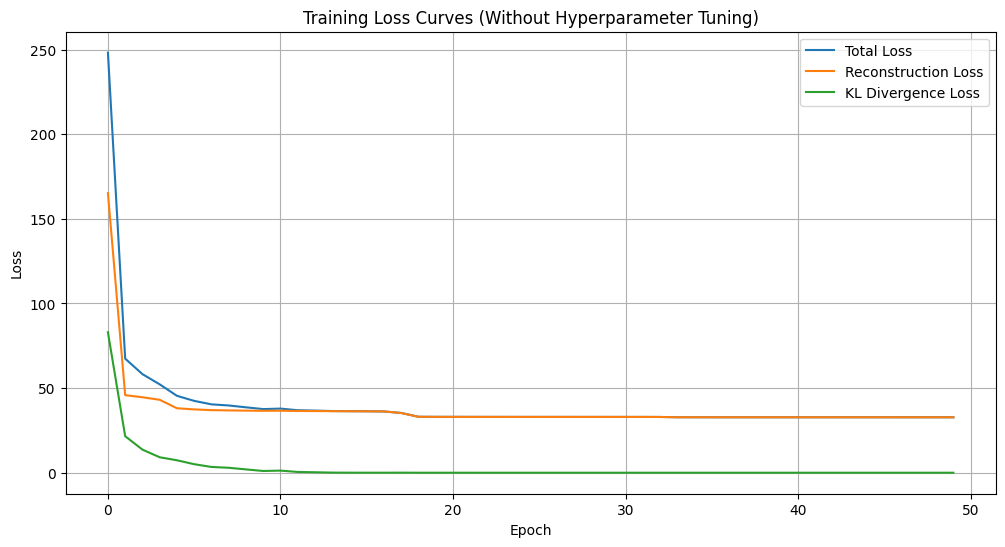

Plot saved: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 20000/Plots/loss_latent64_lr0.001_bs8_optAdam.png
Model trained and saved successfully at: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 20000/Training Results/loss_latent64_lr0.001_bs8_optAdam.pth


In [ ]:
#@title Without Hyperparameter Tuning
# Data Loader
batch_size = 16
train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=batch_size, shuffle=True)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE_CNN().to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Loss function
mse_loss = nn.MSELoss(reduction='sum')

def vae_loss(recon_x, x, mu, logvar):
    reconstruction_loss = mse_loss(recon_x, x)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    total_loss = reconstruction_loss + kl_loss
    return total_loss, reconstruction_loss, kl_loss

num_epochs = 50
train_loss_history = []
recon_loss_history = []
kl_loss_history = []

# Begin counting the time
start_time = time.time()

for epoch in tqdm(range(num_epochs), desc="Training"):
    model.train()
    total_loss, total_recon_loss, total_kl_loss = 0, 0, 0

    for batch in train_loader:
        x_batch = batch[0].to(device)

        optimizer.zero_grad()
        recon_batch, mu, logvar = model(x_batch)
        loss, recon_loss, kl = vae_loss(recon_batch, x_batch, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl.item()

    avg_loss = total_loss / len(train_loader.dataset)
    avg_recon_loss = total_recon_loss / len(train_loader.dataset)
    avg_kl_loss = total_kl_loss / len(train_loader.dataset)

    train_loss_history.append(avg_loss)
    recon_loss_history.append(avg_recon_loss)
    kl_loss_history.append(avg_kl_loss)

    tqdm.write(f"Epoch [{epoch+1}/{num_epochs}] - kl_loss: {avg_kl_loss:.4f} - loss: {avg_loss:.4f} - recon_loss: {avg_recon_loss:.4f}")

# Training finished - count the total duration
end_time = time.time()
duration = end_time - start_time
print(f"Training completed in {duration/60:.2f} minutes")

# Plot the losses
plt.figure(figsize=(12,6))
plt.plot(train_loss_history, label='Total Loss')
plt.plot(recon_loss_history, label='Reconstruction Loss')
plt.plot(kl_loss_history, label='KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curves (Without Hyperparameter Tuning)')
plt.legend()
plt.grid()
plt.show()

# Save plot to drive
plot_path = "/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 20000/Plots/loss_latent64_lr0.001_bs8_optAdam.png"
plt.savefig(plot_path)
plt.close()

print(f"Plot saved: {plot_path}")

# Save the model after training
model_path = "/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 20000/Training Results/loss_latent64_lr0.001_bs8_optAdam.pth"
torch.save(model.state_dict(), model_path)
print(f"Model trained and saved successfully at: {model_path}")

Training:   3%|▎         | 1/30 [02:30<1:12:33, 150.13s/it]

Epoch [1/30] - kl_loss: 12.6921 - loss: 65.3834 - recon_loss: 52.6912


Training:   7%|▋         | 2/30 [04:57<1:09:12, 148.29s/it]

Epoch [2/30] - kl_loss: 0.3403 - loss: 37.2375 - recon_loss: 36.8972


Training:  10%|█         | 3/30 [07:25<1:06:40, 148.18s/it]

Epoch [3/30] - kl_loss: 0.0440 - loss: 36.1217 - recon_loss: 36.0777


Training:  13%|█▎        | 4/30 [09:53<1:04:18, 148.40s/it]

Epoch [4/30] - kl_loss: 0.0290 - loss: 35.2772 - recon_loss: 35.2482


Training:  17%|█▋        | 5/30 [12:22<1:01:49, 148.38s/it]

Epoch [5/30] - kl_loss: 0.0223 - loss: 35.1984 - recon_loss: 35.1761


Training:  20%|██        | 6/30 [14:49<59:15, 148.15s/it]  

Epoch [6/30] - kl_loss: 0.0201 - loss: 34.7644 - recon_loss: 34.7442


Training:  23%|██▎       | 7/30 [17:19<56:54, 148.46s/it]

Epoch [7/30] - kl_loss: 0.0184 - loss: 34.6522 - recon_loss: 34.6338


Training:  27%|██▋       | 8/30 [19:47<54:28, 148.58s/it]

Epoch [8/30] - kl_loss: 0.0181 - loss: 34.6493 - recon_loss: 34.6312


Training:  30%|███       | 9/30 [22:16<51:59, 148.56s/it]

Epoch [9/30] - kl_loss: 0.0158 - loss: 34.6457 - recon_loss: 34.6299


Training:  33%|███▎      | 10/30 [24:45<49:32, 148.61s/it]

Epoch [10/30] - kl_loss: 0.0149 - loss: 34.6457 - recon_loss: 34.6309


Training:  37%|███▋      | 11/30 [27:14<47:07, 148.80s/it]

Epoch [11/30] - kl_loss: 0.0117 - loss: 34.6442 - recon_loss: 34.6325


Training:  40%|████      | 12/30 [29:42<44:36, 148.70s/it]

Epoch [12/30] - kl_loss: 0.0092 - loss: 34.6405 - recon_loss: 34.6313


Training:  43%|████▎     | 13/30 [32:10<42:01, 148.29s/it]

Epoch [13/30] - kl_loss: 0.0064 - loss: 34.6394 - recon_loss: 34.6330


Training:  47%|████▋     | 14/30 [34:39<39:38, 148.65s/it]

Epoch [14/30] - kl_loss: 0.0047 - loss: 34.6386 - recon_loss: 34.6339


Training:  50%|█████     | 15/30 [37:08<37:10, 148.67s/it]

Epoch [15/30] - kl_loss: 0.0034 - loss: 34.6363 - recon_loss: 34.6329


Training:  53%|█████▎    | 16/30 [39:36<34:40, 148.59s/it]

Epoch [16/30] - kl_loss: 0.0023 - loss: 34.6305 - recon_loss: 34.6281


Training:  57%|█████▋    | 17/30 [42:06<32:17, 149.01s/it]

Epoch [17/30] - kl_loss: 0.0017 - loss: 34.6275 - recon_loss: 34.6257


Training:  60%|██████    | 18/30 [44:35<29:48, 149.04s/it]

Epoch [18/30] - kl_loss: 0.0013 - loss: 34.6219 - recon_loss: 34.6205


Training:  63%|██████▎   | 19/30 [47:04<27:16, 148.78s/it]

Epoch [19/30] - kl_loss: 0.0011 - loss: 34.6180 - recon_loss: 34.6168


Training:  67%|██████▋   | 20/30 [49:34<24:52, 149.29s/it]

Epoch [20/30] - kl_loss: 0.0009 - loss: 34.6147 - recon_loss: 34.6138


Training:  70%|███████   | 21/30 [52:02<22:20, 148.91s/it]

Epoch [21/30] - kl_loss: 0.0010 - loss: 34.6114 - recon_loss: 34.6104


Training:  73%|███████▎  | 22/30 [54:31<19:51, 148.96s/it]

Epoch [22/30] - kl_loss: 0.0005 - loss: 34.6113 - recon_loss: 34.6108


Training:  77%|███████▋  | 23/30 [57:01<17:23, 149.14s/it]

Epoch [23/30] - kl_loss: 0.0007 - loss: 34.6097 - recon_loss: 34.6089


Training:  80%|████████  | 24/30 [59:29<14:53, 148.87s/it]

Epoch [24/30] - kl_loss: 0.0008 - loss: 34.6060 - recon_loss: 34.6052


Training:  83%|████████▎ | 25/30 [1:01:58<12:25, 149.06s/it]

Epoch [25/30] - kl_loss: 0.0005 - loss: 34.6053 - recon_loss: 34.6048


Training:  87%|████████▋ | 26/30 [1:04:29<09:57, 149.44s/it]

Epoch [26/30] - kl_loss: 0.0007 - loss: 34.6024 - recon_loss: 34.6017


Training:  90%|█████████ | 27/30 [1:06:58<07:27, 149.30s/it]

Epoch [27/30] - kl_loss: 0.0009 - loss: 34.6012 - recon_loss: 34.6003


Training:  93%|█████████▎| 28/30 [1:09:29<04:59, 149.96s/it]

Epoch [28/30] - kl_loss: 0.0006 - loss: 34.5991 - recon_loss: 34.5985


Training:  97%|█████████▋| 29/30 [1:12:00<02:30, 150.20s/it]

Epoch [29/30] - kl_loss: 0.0007 - loss: 34.5982 - recon_loss: 34.5974


Training: 100%|██████████| 30/30 [1:14:32<00:00, 149.08s/it]


Epoch [30/30] - kl_loss: 0.0004 - loss: 34.5987 - recon_loss: 34.5983
Training completed in 74.54 minutes


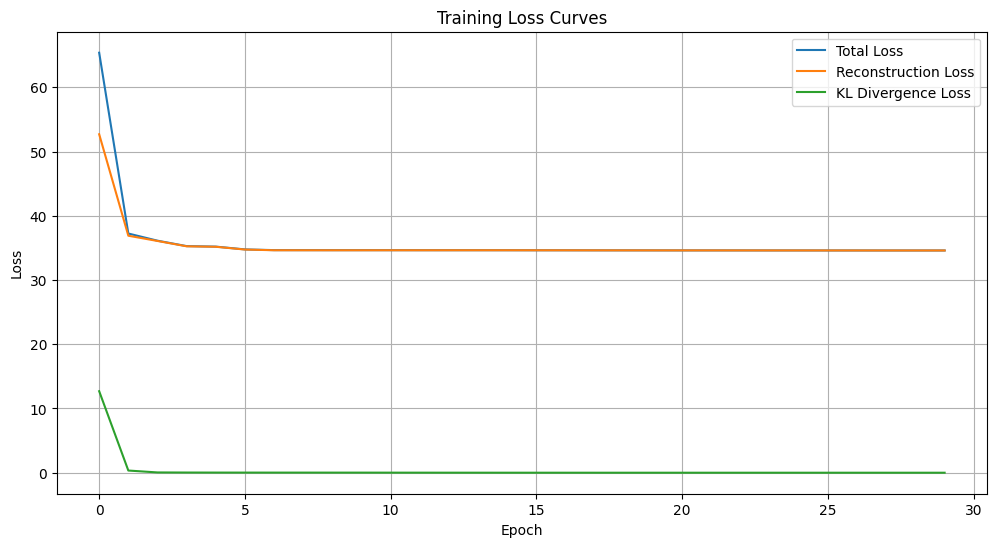

Plot saved: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 15000/Plots/loss_latent8_lr0.001_bs8_optAdam.png
Model trained and saved successfully at: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 15000/Training Results/loss_latent8_lr0.001_bs8_optAdam.pth


In [ ]:
#@title Without Hyperparameter Tuning (15000)
# Data Loader
batch_size = 16
train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=batch_size, shuffle=True)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE_CNN().to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Loss function
mse_loss = nn.MSELoss(reduction='sum')

def vae_loss(recon_x, x, mu, logvar):
    reconstruction_loss = mse_loss(recon_x, x)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    total_loss = reconstruction_loss + kl_loss
    return total_loss, reconstruction_loss, kl_loss

num_epochs = 30
train_loss_history = []
recon_loss_history = []
kl_loss_history = []

# Begin counting the time
start_time = time.time()

for epoch in tqdm(range(num_epochs), desc="Training"):
    model.train()
    total_loss, total_recon_loss, total_kl_loss = 0, 0, 0

    for batch in train_loader:
        x_batch = batch[0].to(device)

        optimizer.zero_grad()
        recon_batch, mu, logvar = model(x_batch)
        loss, recon_loss, kl = vae_loss(recon_batch, x_batch, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl.item()

    avg_loss = total_loss / len(train_loader.dataset)
    avg_recon_loss = total_recon_loss / len(train_loader.dataset)
    avg_kl_loss = total_kl_loss / len(train_loader.dataset)

    train_loss_history.append(avg_loss)
    recon_loss_history.append(avg_recon_loss)
    kl_loss_history.append(avg_kl_loss)

    tqdm.write(f"Epoch [{epoch+1}/{num_epochs}] - kl_loss: {avg_kl_loss:.4f} - loss: {avg_loss:.4f} - recon_loss: {avg_recon_loss:.4f}")

# Training finished - count the total duration
end_time = time.time()
duration = end_time - start_time
print(f"Training completed in {duration/60:.2f} minutes")

# Plot the losses
plt.figure(figsize=(12,6))
plt.plot(train_loss_history, label='Total Loss')
plt.plot(recon_loss_history, label='Reconstruction Loss')
plt.plot(kl_loss_history, label='KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curves')
plt.legend()
plt.grid()

# Save before showing
plot_path = "/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 15000/Plots/loss_latent8_lr0.001_bs8_optAdam.png"
plt.savefig(plot_path)
plt.show()
plt.close()

print(f"Plot saved: {plot_path}")

# Save the model after training
model_path = "/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 15000/Training Results/loss_latent8_lr0.001_bs8_optAdam.pth"
torch.save(model.state_dict(), model_path)
print(f"Model trained and saved successfully at: {model_path}")

Training:   3%|▎         | 1/30 [01:49<53:03, 109.78s/it]

Epoch [1/30] - kl_loss: 15.7698 - loss: 85.9302 - recon_loss: 70.1604


Training:   7%|▋         | 2/30 [03:36<50:25, 108.05s/it]

Epoch [2/30] - kl_loss: 1.3917 - loss: 38.5179 - recon_loss: 37.1262


Training:  10%|█         | 3/30 [05:21<47:56, 106.53s/it]

Epoch [3/30] - kl_loss: 0.2491 - loss: 34.9735 - recon_loss: 34.7244


Training:  13%|█▎        | 4/30 [07:07<46:03, 106.29s/it]

Epoch [4/30] - kl_loss: 0.0173 - loss: 33.4245 - recon_loss: 33.4072


Training:  17%|█▋        | 5/30 [08:54<44:21, 106.47s/it]

Epoch [5/30] - kl_loss: 0.0073 - loss: 33.2988 - recon_loss: 33.2914


Training:  20%|██        | 6/30 [10:39<42:25, 106.07s/it]

Epoch [6/30] - kl_loss: 0.0055 - loss: 33.2527 - recon_loss: 33.2472


Training:  23%|██▎       | 7/30 [12:25<40:39, 106.05s/it]

Epoch [7/30] - kl_loss: 0.0046 - loss: 33.2304 - recon_loss: 33.2258


Training:  27%|██▋       | 8/30 [14:12<38:59, 106.33s/it]

Epoch [8/30] - kl_loss: 0.0041 - loss: 33.2159 - recon_loss: 33.2118


Training:  30%|███       | 9/30 [15:58<37:09, 106.18s/it]

Epoch [9/30] - kl_loss: 0.0034 - loss: 33.2118 - recon_loss: 33.2084


Training:  33%|███▎      | 10/30 [17:44<35:26, 106.34s/it]

Epoch [10/30] - kl_loss: 0.0032 - loss: 33.2057 - recon_loss: 33.2025


Training:  37%|███▋      | 11/30 [19:30<33:36, 106.13s/it]

Epoch [11/30] - kl_loss: 0.0045 - loss: 33.0557 - recon_loss: 33.0511


Training:  40%|████      | 12/30 [21:16<31:47, 106.00s/it]

Epoch [12/30] - kl_loss: 0.0030 - loss: 32.5068 - recon_loss: 32.5038


Training:  43%|████▎     | 13/30 [23:03<30:08, 106.39s/it]

Epoch [13/30] - kl_loss: 0.0026 - loss: 32.4955 - recon_loss: 32.4929


Training:  47%|████▋     | 14/30 [24:50<28:23, 106.44s/it]

Epoch [14/30] - kl_loss: 0.0025 - loss: 32.4874 - recon_loss: 32.4849


Training:  50%|█████     | 15/30 [26:36<26:36, 106.40s/it]

Epoch [15/30] - kl_loss: 0.0023 - loss: 32.4888 - recon_loss: 32.4865


Training:  53%|█████▎    | 16/30 [28:23<24:52, 106.64s/it]

Epoch [16/30] - kl_loss: 0.0021 - loss: 32.4875 - recon_loss: 32.4854


Training:  57%|█████▋    | 17/30 [30:09<23:03, 106.43s/it]

Epoch [17/30] - kl_loss: 0.0018 - loss: 32.4891 - recon_loss: 32.4873


Training:  60%|██████    | 18/30 [31:56<21:18, 106.55s/it]

Epoch [18/30] - kl_loss: 0.0017 - loss: 32.4867 - recon_loss: 32.4850


Training:  63%|██████▎   | 19/30 [33:42<19:29, 106.29s/it]

Epoch [19/30] - kl_loss: 0.0013 - loss: 32.4857 - recon_loss: 32.4844


Training:  67%|██████▋   | 20/30 [35:27<17:40, 106.09s/it]

Epoch [20/30] - kl_loss: 0.0013 - loss: 32.4847 - recon_loss: 32.4834


Training:  70%|███████   | 21/30 [37:14<15:56, 106.26s/it]

Epoch [21/30] - kl_loss: 0.0011 - loss: 32.4839 - recon_loss: 32.4828


Training:  73%|███████▎  | 22/30 [38:59<14:08, 106.02s/it]

Epoch [22/30] - kl_loss: 0.0010 - loss: 32.4855 - recon_loss: 32.4845


Training:  77%|███████▋  | 23/30 [40:45<12:21, 105.99s/it]

Epoch [23/30] - kl_loss: 0.0011 - loss: 32.4832 - recon_loss: 32.4822


Training:  80%|████████  | 24/30 [42:33<10:38, 106.40s/it]

Epoch [24/30] - kl_loss: 0.0011 - loss: 32.4816 - recon_loss: 32.4805


Training:  83%|████████▎ | 25/30 [44:18<08:51, 106.23s/it]

Epoch [25/30] - kl_loss: 0.0011 - loss: 32.4762 - recon_loss: 32.4751


Training:  87%|████████▋ | 26/30 [46:06<07:06, 106.52s/it]

Epoch [26/30] - kl_loss: 0.0012 - loss: 32.4775 - recon_loss: 32.4764


Training:  90%|█████████ | 27/30 [47:53<05:20, 106.71s/it]

Epoch [27/30] - kl_loss: 0.0009 - loss: 32.4751 - recon_loss: 32.4742


Training:  93%|█████████▎| 28/30 [49:40<03:33, 106.81s/it]

Epoch [28/30] - kl_loss: 0.0013 - loss: 32.4693 - recon_loss: 32.4680


Training:  97%|█████████▋| 29/30 [51:28<01:47, 107.34s/it]

Epoch [29/30] - kl_loss: 0.0014 - loss: 32.4734 - recon_loss: 32.4720


Training: 100%|██████████| 30/30 [53:15<00:00, 106.52s/it]


Epoch [30/30] - kl_loss: 0.0009 - loss: 32.4711 - recon_loss: 32.4702
Training completed in 53.26 minutes


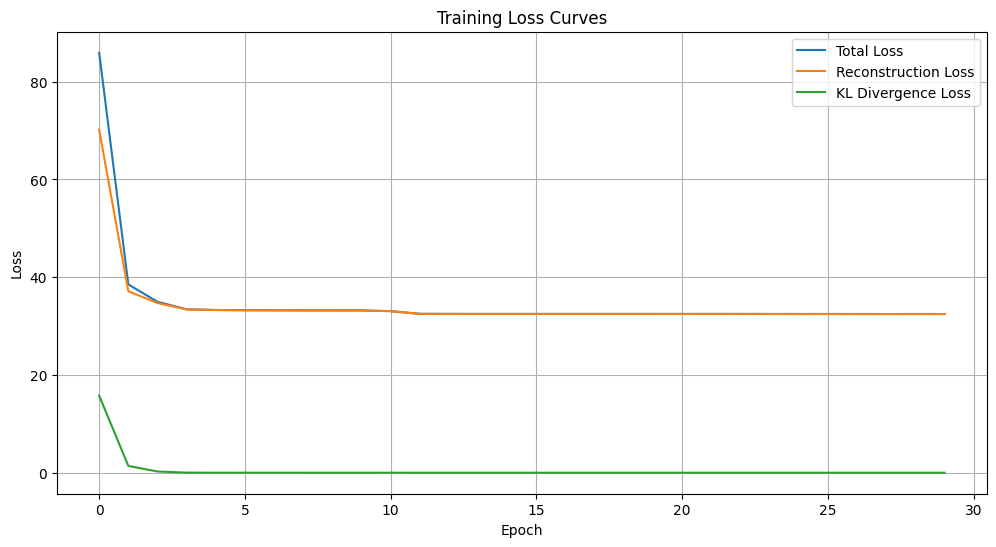

Plot saved: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Plots/loss_latent8_lr0.001_bs8_optAdam.png
Model trained and saved successfully at: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/loss_latent8_lr0.001_bs8_optAdam.pth


In [ ]:
#@title Without Hyperparameter Tuning (15000)
# Data Loader
batch_size = 16
train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=batch_size, shuffle=True)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE_CNN().to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Loss function
mse_loss = nn.MSELoss(reduction='sum')

def vae_loss(recon_x, x, mu, logvar):
    reconstruction_loss = mse_loss(recon_x, x)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    total_loss = reconstruction_loss + kl_loss
    return total_loss, reconstruction_loss, kl_loss

num_epochs = 30
train_loss_history = []
recon_loss_history = []
kl_loss_history = []

# Begin counting the time
start_time = time.time()

for epoch in tqdm(range(num_epochs), desc="Training"):
    model.train()
    total_loss, total_recon_loss, total_kl_loss = 0, 0, 0

    for batch in train_loader:
        x_batch = batch[0].to(device)

        optimizer.zero_grad()
        recon_batch, mu, logvar = model(x_batch)
        loss, recon_loss, kl = vae_loss(recon_batch, x_batch, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl.item()

    avg_loss = total_loss / len(train_loader.dataset)
    avg_recon_loss = total_recon_loss / len(train_loader.dataset)
    avg_kl_loss = total_kl_loss / len(train_loader.dataset)

    train_loss_history.append(avg_loss)
    recon_loss_history.append(avg_recon_loss)
    kl_loss_history.append(avg_kl_loss)

    tqdm.write(f"Epoch [{epoch+1}/{num_epochs}] - kl_loss: {avg_kl_loss:.4f} - loss: {avg_loss:.4f} - recon_loss: {avg_recon_loss:.4f}")

# Training finished - count the total duration
end_time = time.time()
duration = end_time - start_time
print(f"Training completed in {duration/60:.2f} minutes")

# Plot the losses
plt.figure(figsize=(12,6))
plt.plot(train_loss_history, label='Total Loss')
plt.plot(recon_loss_history, label='Reconstruction Loss')
plt.plot(kl_loss_history, label='KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curves')
plt.legend()
plt.grid()

# Save before showing
plot_path = "/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 15000/Plots/loss_latent8_lr0.001_bs8_optAdam.png"
plt.savefig(plot_path)
plt.show()
plt.close()

print(f"Plot saved: {plot_path}")

# Save the model after training
model_path = "/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 15000/Training Results/loss_latent8_lr0.001_bs8_optAdam.pth"
torch.save(model.state_dict(), model_path)
print(f"Model trained and saved successfully at: {model_path}")

Training:   5%|▌         | 1/20 [01:58<37:22, 118.01s/it]

Epoch [1/20] - kl_loss: 13.3207 - loss: 155.3541 - recon_loss: 142.0334


Training:  10%|█         | 2/20 [03:53<34:59, 116.65s/it]

Epoch [2/20] - kl_loss: 6.2936 - loss: 40.2346 - recon_loss: 33.9410


Training:  15%|█▌        | 3/20 [05:54<33:38, 118.73s/it]

Epoch [3/20] - kl_loss: 4.6041 - loss: 37.6708 - recon_loss: 33.0667


Training:  20%|██        | 4/20 [07:50<31:18, 117.40s/it]

Epoch [4/20] - kl_loss: 3.5893 - loss: 36.2612 - recon_loss: 32.6719


Training:  25%|██▌       | 5/20 [09:45<29:11, 116.74s/it]

Epoch [5/20] - kl_loss: 2.8797 - loss: 35.3015 - recon_loss: 32.4219


Training:  30%|███       | 6/20 [11:42<27:15, 116.85s/it]

Epoch [6/20] - kl_loss: 2.2936 - loss: 34.5200 - recon_loss: 32.2264


Training:  35%|███▌      | 7/20 [13:38<25:12, 116.37s/it]

Epoch [7/20] - kl_loss: 1.8892 - loss: 34.0025 - recon_loss: 32.1133


Training:  40%|████      | 8/20 [15:36<23:21, 116.81s/it]

Epoch [8/20] - kl_loss: 1.5420 - loss: 33.5470 - recon_loss: 32.0050


Training:  45%|████▌     | 9/20 [17:33<21:26, 116.95s/it]

Epoch [9/20] - kl_loss: 1.2094 - loss: 33.1139 - recon_loss: 31.9045


Training:  50%|█████     | 10/20 [19:29<19:26, 116.68s/it]

Epoch [10/20] - kl_loss: 0.9701 - loss: 32.8085 - recon_loss: 31.8384


Training:  55%|█████▌    | 11/20 [21:26<17:32, 116.91s/it]

Epoch [11/20] - kl_loss: 0.7724 - loss: 32.5640 - recon_loss: 31.7916


Training:  60%|██████    | 12/20 [23:21<15:30, 116.26s/it]

Epoch [12/20] - kl_loss: 0.5737 - loss: 32.2906 - recon_loss: 31.7169


Training:  65%|██████▌   | 13/20 [25:16<13:30, 115.85s/it]

Epoch [13/20] - kl_loss: 0.4082 - loss: 32.0662 - recon_loss: 31.6579


Training:  70%|███████   | 14/20 [27:13<11:36, 116.08s/it]

Epoch [14/20] - kl_loss: 0.2745 - loss: 31.8820 - recon_loss: 31.6075


Training:  75%|███████▌  | 15/20 [29:08<09:39, 115.82s/it]

Epoch [15/20] - kl_loss: 0.1918 - loss: 31.7554 - recon_loss: 31.5636


Training:  80%|████████  | 16/20 [31:05<07:44, 116.10s/it]

Epoch [16/20] - kl_loss: 0.1188 - loss: 31.6365 - recon_loss: 31.5176


Training:  85%|████████▌ | 17/20 [32:59<05:46, 115.63s/it]

Epoch [17/20] - kl_loss: 0.0815 - loss: 31.5837 - recon_loss: 31.5022


Training:  90%|█████████ | 18/20 [34:54<03:50, 115.44s/it]

Epoch [18/20] - kl_loss: 0.0495 - loss: 31.5094 - recon_loss: 31.4600


Training:  95%|█████████▌| 19/20 [36:50<01:55, 115.62s/it]

Epoch [19/20] - kl_loss: 0.0315 - loss: 31.4650 - recon_loss: 31.4335


Training: 100%|██████████| 20/20 [38:45<00:00, 116.28s/it]


Epoch [20/20] - kl_loss: 0.0189 - loss: 31.4253 - recon_loss: 31.4064
Training completed in 38.76 minutes


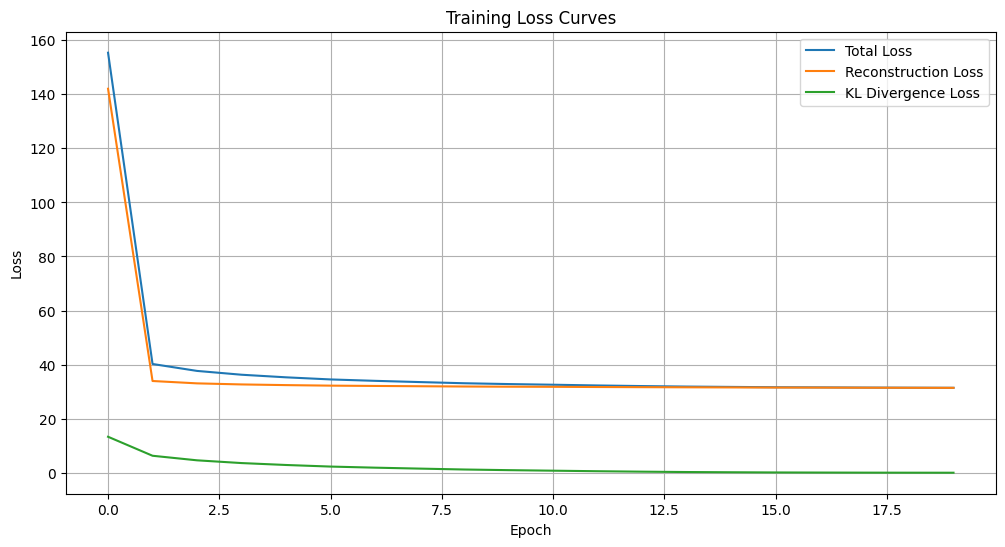

Plot saved: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Plots/loss_latent4_lr0.001_bs32_optAdam_new.png
Model trained and saved successfully at: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/loss_latent4_lr0.001_bs32_optAdam_new.pth


In [ ]:
#@title Without Hyperparameter Tuning (10000) - Retrained with new parameters
# Data Loader
batch_size = 16
train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=batch_size, shuffle=True)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE_CNN().to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Loss function
mse_loss = nn.MSELoss(reduction='sum')

def vae_loss(recon_x, x, mu, logvar):
    reconstruction_loss = mse_loss(recon_x, x)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    total_loss = reconstruction_loss + kl_loss
    return total_loss, reconstruction_loss, kl_loss

num_epochs = 20
train_loss_history = []
recon_loss_history = []
kl_loss_history = []

# Begin counting the time
start_time = time.time()

for epoch in tqdm(range(num_epochs), desc="Training"):
    model.train()
    total_loss, total_recon_loss, total_kl_loss = 0, 0, 0

    for batch in train_loader:
        x_batch = batch[0].to(device)

        optimizer.zero_grad()
        recon_batch, mu, logvar = model(x_batch)
        loss, recon_loss, kl = vae_loss(recon_batch, x_batch, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl.item()

    avg_loss = total_loss / len(train_loader.dataset)
    avg_recon_loss = total_recon_loss / len(train_loader.dataset)
    avg_kl_loss = total_kl_loss / len(train_loader.dataset)

    train_loss_history.append(avg_loss)
    recon_loss_history.append(avg_recon_loss)
    kl_loss_history.append(avg_kl_loss)

    tqdm.write(f"Epoch [{epoch+1}/{num_epochs}] - kl_loss: {avg_kl_loss:.4f} - loss: {avg_loss:.4f} - recon_loss: {avg_recon_loss:.4f}")

# Training finished - count the total duration
end_time = time.time()
duration = end_time - start_time
print(f"Training completed in {duration/60:.2f} minutes")

# Plot the losses
plt.figure(figsize=(12,6))
plt.plot(train_loss_history, label='Total Loss')
plt.plot(recon_loss_history, label='Reconstruction Loss')
plt.plot(kl_loss_history, label='KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curves')
plt.legend()
plt.grid()

# Save before showing
plot_path = "/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Plots/loss_latent4_lr0.001_bs32_optAdam_new.png"
plt.savefig(plot_path)
plt.show()
plt.close()

print(f"Plot saved: {plot_path}")

# Save the model after training
model_path = "/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/loss_latent4_lr0.001_bs32_optAdam_new.pth"
torch.save(model.state_dict(), model_path)
print(f"Model trained and saved successfully at: {model_path}")

Training:   5%|▌         | 1/20 [01:50<34:58, 110.45s/it]

Epoch [1/20] - kl_loss: 16.6448 - loss: 146.6385 - recon_loss: 129.9936


Training:  10%|█         | 2/20 [03:40<33:05, 110.28s/it]

Epoch [2/20] - kl_loss: 4.9143 - loss: 39.3903 - recon_loss: 34.4760


Training:  15%|█▌        | 3/20 [05:28<30:59, 109.36s/it]

Epoch [3/20] - kl_loss: 2.6029 - loss: 36.2658 - recon_loss: 33.6628


Training:  20%|██        | 4/20 [07:28<30:12, 113.29s/it]

Epoch [4/20] - kl_loss: 1.6978 - loss: 35.0350 - recon_loss: 33.3372


Training:  25%|██▌       | 5/20 [09:19<28:09, 112.66s/it]

Epoch [5/20] - kl_loss: 1.1857 - loss: 34.3664 - recon_loss: 33.1806


Training:  30%|███       | 6/20 [11:11<26:14, 112.44s/it]

Epoch [6/20] - kl_loss: 0.7539 - loss: 33.8037 - recon_loss: 33.0498


Training:  35%|███▌      | 7/20 [13:03<24:17, 112.14s/it]

Epoch [7/20] - kl_loss: 0.4149 - loss: 33.3340 - recon_loss: 32.9191


Training:  40%|████      | 8/20 [14:52<22:13, 111.13s/it]

Epoch [8/20] - kl_loss: 0.2096 - loss: 33.0057 - recon_loss: 32.7960


Training:  45%|████▌     | 9/20 [16:43<20:23, 111.21s/it]

Epoch [9/20] - kl_loss: 0.0948 - loss: 32.7800 - recon_loss: 32.6852


Training:  50%|█████     | 10/20 [18:33<18:27, 110.78s/it]

Epoch [10/20] - kl_loss: 0.0440 - loss: 32.6396 - recon_loss: 32.5955


Training:  55%|█████▌    | 11/20 [20:25<16:40, 111.13s/it]

Epoch [11/20] - kl_loss: 0.0192 - loss: 32.5393 - recon_loss: 32.5202


Training:  60%|██████    | 12/20 [22:14<14:44, 110.51s/it]

Epoch [12/20] - kl_loss: 0.0114 - loss: 32.4891 - recon_loss: 32.4777


Training:  65%|██████▌   | 13/20 [24:05<12:53, 110.55s/it]

Epoch [13/20] - kl_loss: 0.0071 - loss: 32.4505 - recon_loss: 32.4434


Training:  70%|███████   | 14/20 [25:54<11:02, 110.35s/it]

Epoch [14/20] - kl_loss: 0.0058 - loss: 32.4612 - recon_loss: 32.4554


Training:  75%|███████▌  | 15/20 [27:45<09:11, 110.35s/it]

Epoch [15/20] - kl_loss: 0.0038 - loss: 32.4171 - recon_loss: 32.4133


Training:  80%|████████  | 16/20 [29:34<07:20, 110.06s/it]

Epoch [16/20] - kl_loss: 0.0032 - loss: 32.4204 - recon_loss: 32.4172


Training:  85%|████████▌ | 17/20 [31:24<05:30, 110.10s/it]

Epoch [17/20] - kl_loss: 0.0030 - loss: 32.4025 - recon_loss: 32.3995


Training:  90%|█████████ | 18/20 [33:14<03:39, 109.90s/it]

Epoch [18/20] - kl_loss: 0.0026 - loss: 32.4115 - recon_loss: 32.4089


Training:  95%|█████████▌| 19/20 [35:04<01:49, 109.87s/it]

Epoch [19/20] - kl_loss: 0.0024 - loss: 32.3917 - recon_loss: 32.3892


Training: 100%|██████████| 20/20 [36:53<00:00, 110.69s/it]


Epoch [20/20] - kl_loss: 0.0023 - loss: 32.3931 - recon_loss: 32.3908
Training completed in 36.90 minutes


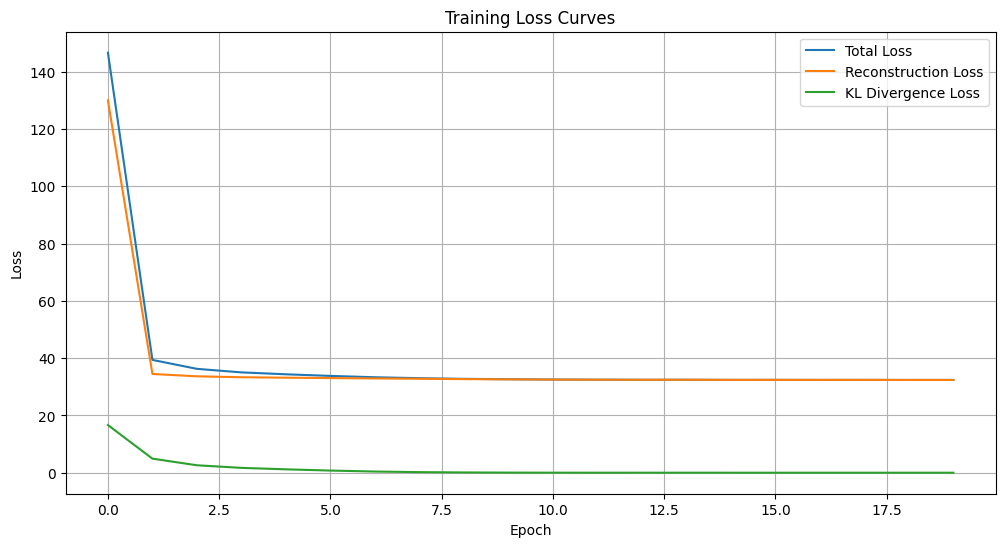

Plot saved: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Plots/loss_latent4_lr0.001_bs32_optAdam_tweaked.png
Model trained and saved successfully at: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/loss_latent4_lr0.001_bs32_optAdam_tweaked.pth


In [ ]:
#@title Without Hyperparameter Tuning (10000) - Vocab 89
# Data Loader
batch_size = 16
train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=batch_size, shuffle=True)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE_CNN().to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Loss function
mse_loss = nn.MSELoss(reduction='sum')

def vae_loss(recon_x, x, mu, logvar):
    reconstruction_loss = mse_loss(recon_x, x)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    total_loss = reconstruction_loss + kl_loss
    return total_loss, reconstruction_loss, kl_loss

num_epochs = 20
train_loss_history = []
recon_loss_history = []
kl_loss_history = []

# Begin counting the time
start_time = time.time()

for epoch in tqdm(range(num_epochs), desc="Training"):
    model.train()
    total_loss, total_recon_loss, total_kl_loss = 0, 0, 0

    for batch in train_loader:
        x_batch = batch[0].to(device)

        optimizer.zero_grad()
        recon_batch, mu, logvar = model(x_batch)
        loss, recon_loss, kl = vae_loss(recon_batch, x_batch, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl.item()

    avg_loss = total_loss / len(train_loader.dataset)
    avg_recon_loss = total_recon_loss / len(train_loader.dataset)
    avg_kl_loss = total_kl_loss / len(train_loader.dataset)

    train_loss_history.append(avg_loss)
    recon_loss_history.append(avg_recon_loss)
    kl_loss_history.append(avg_kl_loss)

    tqdm.write(f"Epoch [{epoch+1}/{num_epochs}] - kl_loss: {avg_kl_loss:.4f} - loss: {avg_loss:.4f} - recon_loss: {avg_recon_loss:.4f}")

# Training finished - count the total duration
end_time = time.time()
duration = end_time - start_time
print(f"Training completed in {duration/60:.2f} minutes")

# Plot the losses
plt.figure(figsize=(12,6))
plt.plot(train_loss_history, label='Total Loss')
plt.plot(recon_loss_history, label='Reconstruction Loss')
plt.plot(kl_loss_history, label='KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curves')
plt.legend()
plt.grid()

# Save before showing
plot_path = "/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Plots/loss_latent4_lr0.001_bs32_optAdam_tweaked.png"
plt.savefig(plot_path)
plt.show()
plt.close()

print(f"Plot saved: {plot_path}")

# Save the model after training
model_path = "/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/loss_latent4_lr0.001_bs32_optAdam_tweaked.pth"
torch.save(model.state_dict(), model_path)
print(f"Model trained and saved successfully at: {model_path}")

In [ ]:
#@title Without Hyperparameter Tuning (18500)
# Data Loader
batch_size = 16
train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=batch_size, shuffle=True)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE_CNN().to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Loss function
mse_loss = nn.MSELoss(reduction='sum')

def vae_loss(recon_x, x, mu, logvar):
    reconstruction_loss = mse_loss(recon_x, x)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    total_loss = reconstruction_loss + kl_loss
    return total_loss, reconstruction_loss, kl_loss

num_epochs = 30
train_loss_history = []
recon_loss_history = []
kl_loss_history = []

# Begin counting the time
start_time = time.time()

for epoch in tqdm(range(num_epochs), desc="Training"):
    model.train()
    total_loss, total_recon_loss, total_kl_loss = 0, 0, 0

    for batch in train_loader:
        x_batch = batch[0].to(device)

        optimizer.zero_grad()
        recon_batch, mu, logvar = model(x_batch)
        loss, recon_loss, kl = vae_loss(recon_batch, x_batch, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl.item()

    avg_loss = total_loss / len(train_loader.dataset)
    avg_recon_loss = total_recon_loss / len(train_loader.dataset)
    avg_kl_loss = total_kl_loss / len(train_loader.dataset)

    train_loss_history.append(avg_loss)
    recon_loss_history.append(avg_recon_loss)
    kl_loss_history.append(avg_kl_loss)

    tqdm.write(f"Epoch [{epoch+1}/{num_epochs}] - kl_loss: {avg_kl_loss:.4f} - loss: {avg_loss:.4f} - recon_loss: {avg_recon_loss:.4f}")

# Training finished - count the total duration
end_time = time.time()
duration = end_time - start_time
print(f"Training completed in {duration/60:.2f} minutes")

# Plot the losses
plt.figure(figsize=(12,6))
plt.plot(train_loss_history, label='Total Loss')
plt.plot(recon_loss_history, label='Reconstruction Loss')
plt.plot(kl_loss_history, label='KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curves')
plt.legend()
plt.grid()

# Save before showing
plot_path = "/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Testing/Plots/loss_latent4_lr0.001_bs32_optAdam.png"
plt.savefig(plot_path)
plt.show()
plt.close()

print(f"Plot saved: {plot_path}")

# Save the model after training
model_path = "/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Testing/Training Results/loss_latent4_lr0.001_bs32_optAdam.pth"
torch.save(model.state_dict(), model_path)
print(f"Model trained and saved successfully at: {model_path}")

In [ ]:
#@title With Hyperparameter Tuning
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameter candidates
latent_dims = [64, 128]
learning_rates = [0.001, 0.0005]
batch_sizes = [8, 16]
optimizers = ['Adam']
num_epochs = 30

# Loss function
mse_loss = nn.MSELoss(reduction='sum')

def vae_loss(recon_x, x, mu, logvar):
    reconstruction_loss = mse_loss(recon_x, x)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    total_loss = reconstruction_loss + kl_loss
    return total_loss, reconstruction_loss, kl_loss

# Save all the combination results
results = []

# Loop hyperparameter combination
for latent_dim in latent_dims:
    for lr in learning_rates:
        for batch_size in batch_sizes:
            for opt_name in optimizers:
                print(f"\n[Training] latent_dim: {latent_dim}, lr: {lr}, batch_size: {batch_size}, optimizer: {opt_name}")

                # Data loader per batch size
                train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=batch_size, shuffle=True)

                # Model & optimizer
                model = VAE_CNN(latent_dim=latent_dim).to(device)

                if opt_name == 'Adam':
                    optimizer = optim.Adam(model.parameters(), lr=lr)
                elif opt_name == 'SGD':
                    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
                else:
                    raise ValueError("Unsupported optimizer")

                train_loss_history = []
                recon_loss_history = []
                kl_loss_history = []

                # Begin counting the time
                start_time = time.time()

                for epoch in tqdm(range(num_epochs), desc=f"Training {latent_dim}, lr {lr}, bs {batch_size}, opt {opt_name}"):
                    model.train()
                    total_loss, total_recon_loss, total_kl_loss = 0, 0, 0

                    for batch in train_loader:
                        x_batch = batch[0].to(device)

                        optimizer.zero_grad()
                        recon_batch, mu, logvar = model(x_batch)
                        loss, recon_loss, kl = vae_loss(recon_batch, x_batch, mu, logvar)
                        loss.backward()
                        optimizer.step()

                        total_loss += loss.item()
                        total_recon_loss += recon_loss.item()
                        total_kl_loss += kl.item()

                    avg_loss = total_loss / len(train_loader.dataset)
                    avg_recon_loss = total_recon_loss / len(train_loader.dataset)
                    avg_kl_loss = total_kl_loss / len(train_loader.dataset)

                    train_loss_history.append(avg_loss)
                    recon_loss_history.append(avg_recon_loss)
                    kl_loss_history.append(avg_kl_loss)

                    tqdm.write(f"Epoch [{epoch+1}/{num_epochs}] - kl: {avg_kl_loss:.4f} - loss: {avg_loss:.4f} - recon: {avg_recon_loss:.4f}")

                # Training finished - count the total duration
                end_time = time.time()
                duration = end_time - start_time
                print(f"Training duration: {duration/60:.2f} minutes")

                # Save the result
                results.append({
                    'label': f'latent{latent_dim}_lr{lr}_bs{batch_size}_{opt_name}',
                    'train_loss_history': train_loss_history,
                    'duration': duration
                })

                # Plot individual loss curves
                plt.figure(figsize=(12,6))
                plt.plot(train_loss_history, label='Total Loss')
                plt.plot(recon_loss_history, label='Reconstruction Loss')
                plt.plot(kl_loss_history, label='KL Divergence Loss')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.title(f'Loss Curves\nlatent_dim={latent_dim}, lr={lr}, batch_size={batch_size}, optimizer={opt_name}')
                plt.legend()
                plt.grid()

                # Save plot to drive
                plot_path = f"/content/drive/MyDrive/Thesis - Undergraduate Ch./Plots/loss_latent{latent_dim}_lr{lr}_bs{batch_size}_opt{opt_name}.png"
                plt.savefig(plot_path)
                plt.close()

                print(f"Plot saved: {plot_path}")

                # Save the model after training
                model_path = f"/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/vae_cnn_latent{latent_dim}_lr{lr}_bs{batch_size}_opt{opt_name}.pth"
                torch.save(model.state_dict(), model_path)
                print(f"Model trained and saved successfully at: {model_path}")

# Plot the total loss comparison between all the candidates
plt.figure(figsize=(14,8))
for result in results:
    plt.plot(result['train_loss_history'], label=f"{result['label']} ({result['duration']/60:.1f}m)")

plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Comparison of Total Loss between Hyperparameters')
plt.legend()
plt.grid()

# Save comparison plot to drive
comparison_plot_path = "/content/drive/MyDrive/Thesis - Undergraduate Ch./Plots/comparison_total_loss.png"
plt.savefig(comparison_plot_path)
plt.close()

print(f"Comparison plot saved: {comparison_plot_path}")


[Training] latent_dim: 64, lr: 0.001, batch_size: 8, optimizer: Adam


Training 64, lr 0.001, bs 8, opt Adam:   3%|▎         | 1/30 [02:18<1:07:07, 138.87s/it]

Epoch [1/30] - kl: 33.8262 - loss: 96.9945 - recon: 63.1683


Training 64, lr 0.001, bs 8, opt Adam:   7%|▋         | 2/30 [04:20<1:00:02, 128.66s/it]

Epoch [2/30] - kl: 0.2491 - loss: 43.1123 - recon: 42.8633


Training 64, lr 0.001, bs 8, opt Adam:  10%|█         | 3/30 [06:22<56:38, 125.88s/it]  

Epoch [3/30] - kl: 0.1111 - loss: 42.2994 - recon: 42.1883


Training 64, lr 0.001, bs 8, opt Adam:  13%|█▎        | 4/30 [08:23<53:38, 123.79s/it]

Epoch [4/30] - kl: 0.1029 - loss: 39.7628 - recon: 39.6599


Training 64, lr 0.001, bs 8, opt Adam:  17%|█▋        | 5/30 [10:24<51:06, 122.64s/it]

Epoch [5/30] - kl: 0.0807 - loss: 38.1490 - recon: 38.0683


Training 64, lr 0.001, bs 8, opt Adam:  20%|██        | 6/30 [12:25<48:54, 122.27s/it]

Epoch [6/30] - kl: 0.0773 - loss: 38.0608 - recon: 37.9835


Training 64, lr 0.001, bs 8, opt Adam:  23%|██▎       | 7/30 [14:26<46:44, 121.95s/it]

Epoch [7/30] - kl: 0.0785 - loss: 38.0025 - recon: 37.9240


Training 64, lr 0.001, bs 8, opt Adam:  27%|██▋       | 8/30 [16:28<44:38, 121.73s/it]

Epoch [8/30] - kl: 0.1096 - loss: 38.0253 - recon: 37.9157


Training 64, lr 0.001, bs 8, opt Adam:  30%|███       | 9/30 [18:28<42:23, 121.13s/it]

Epoch [9/30] - kl: 0.0523 - loss: 36.7340 - recon: 36.6818


Training 64, lr 0.001, bs 8, opt Adam:  33%|███▎      | 10/30 [20:30<40:32, 121.60s/it]

Epoch [10/30] - kl: 0.0229 - loss: 36.3665 - recon: 36.3435


Training 64, lr 0.001, bs 8, opt Adam:  37%|███▋      | 11/30 [22:31<38:27, 121.44s/it]

Epoch [11/30] - kl: 0.0186 - loss: 36.3233 - recon: 36.3047


Training 64, lr 0.001, bs 8, opt Adam:  40%|████      | 12/30 [24:34<36:34, 121.91s/it]

Epoch [12/30] - kl: 0.0142 - loss: 36.3081 - recon: 36.2939


Training 64, lr 0.001, bs 8, opt Adam:  43%|████▎     | 13/30 [26:35<34:27, 121.63s/it]

Epoch [13/30] - kl: 0.0074 - loss: 36.3004 - recon: 36.2929


Training 64, lr 0.001, bs 8, opt Adam:  47%|████▋     | 14/30 [28:38<32:32, 122.05s/it]

Epoch [14/30] - kl: 0.0051 - loss: 36.2895 - recon: 36.2843


Training 64, lr 0.001, bs 8, opt Adam:  50%|█████     | 15/30 [30:41<30:35, 122.35s/it]

Epoch [15/30] - kl: 0.0031 - loss: 36.2841 - recon: 36.2810


Training 64, lr 0.001, bs 8, opt Adam:  53%|█████▎    | 16/30 [32:47<28:47, 123.36s/it]

Epoch [16/30] - kl: 0.0031 - loss: 36.2780 - recon: 36.2749


Training 64, lr 0.001, bs 8, opt Adam:  57%|█████▋    | 17/30 [34:52<26:51, 123.99s/it]

Epoch [17/30] - kl: 0.0026 - loss: 36.2767 - recon: 36.2740


Training 64, lr 0.001, bs 8, opt Adam:  60%|██████    | 18/30 [37:00<25:01, 125.14s/it]

Epoch [18/30] - kl: 0.0025 - loss: 36.2704 - recon: 36.2680


Training 64, lr 0.001, bs 8, opt Adam:  63%|██████▎   | 19/30 [39:11<23:14, 126.78s/it]

Epoch [19/30] - kl: 0.0026 - loss: 36.2678 - recon: 36.2652


Training 64, lr 0.001, bs 8, opt Adam:  67%|██████▋   | 20/30 [41:23<21:24, 128.44s/it]

Epoch [20/30] - kl: 0.0021 - loss: 36.2669 - recon: 36.2648


Training 64, lr 0.001, bs 8, opt Adam:  70%|███████   | 21/30 [43:42<19:42, 131.42s/it]

Epoch [21/30] - kl: 0.0025 - loss: 36.2588 - recon: 36.2563


Training 64, lr 0.001, bs 8, opt Adam:  73%|███████▎  | 22/30 [46:02<17:52, 134.06s/it]

Epoch [22/30] - kl: 0.0023 - loss: 36.2570 - recon: 36.2548


Training 64, lr 0.001, bs 8, opt Adam:  77%|███████▋  | 23/30 [48:26<15:59, 137.02s/it]

Epoch [23/30] - kl: 0.0023 - loss: 36.2521 - recon: 36.2498


Training 64, lr 0.001, bs 8, opt Adam:  80%|████████  | 24/30 [50:55<14:05, 140.84s/it]

Epoch [24/30] - kl: 0.0022 - loss: 36.2518 - recon: 36.2496


Training 64, lr 0.001, bs 8, opt Adam:  83%|████████▎ | 25/30 [53:27<11:59, 143.93s/it]

Epoch [25/30] - kl: 0.0023 - loss: 36.2529 - recon: 36.2506


Training 64, lr 0.001, bs 8, opt Adam:  87%|████████▋ | 26/30 [56:03<09:50, 147.66s/it]

Epoch [26/30] - kl: 0.0020 - loss: 36.2463 - recon: 36.2443


Training 64, lr 0.001, bs 8, opt Adam:  90%|█████████ | 27/30 [58:39<07:30, 150.32s/it]

Epoch [27/30] - kl: 0.0019 - loss: 36.2457 - recon: 36.2438


Training 64, lr 0.001, bs 8, opt Adam:  93%|█████████▎| 28/30 [1:01:11<05:01, 150.81s/it]

Epoch [28/30] - kl: 0.0017 - loss: 36.2445 - recon: 36.2428


Training 64, lr 0.001, bs 8, opt Adam:  97%|█████████▋| 29/30 [1:03:46<02:31, 151.79s/it]

Epoch [29/30] - kl: 0.0021 - loss: 36.2415 - recon: 36.2394


Training 64, lr 0.001, bs 8, opt Adam: 100%|██████████| 30/30 [1:06:18<00:00, 132.63s/it]


Epoch [30/30] - kl: 0.0019 - loss: 36.2410 - recon: 36.2391
Training duration: 66.31 minutes
Plot saved: /content/drive/MyDrive/Thesis - Undergraduate Ch./Plots/loss_latent64_lr0.001_bs8_optAdam.png
Model trained and saved successfully at: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/vae_cnn_latent64_lr0.001_bs8_optAdam.pth

[Training] latent_dim: 64, lr: 0.001, batch_size: 16, optimizer: Adam


Training 64, lr 0.001, bs 16, opt Adam:   3%|▎         | 1/30 [02:34<1:14:32, 154.24s/it]

Epoch [1/30] - kl: 45.9494 - loss: 121.2414 - recon: 75.2920


Training 64, lr 0.001, bs 16, opt Adam:   7%|▋         | 2/30 [04:42<1:04:53, 139.06s/it]

Epoch [2/30] - kl: 2.2799 - loss: 45.9484 - recon: 43.6685


Training 64, lr 0.001, bs 16, opt Adam:  10%|█         | 3/30 [06:47<59:33, 132.35s/it]  

Epoch [3/30] - kl: 0.1845 - loss: 43.2087 - recon: 43.0242


Training 64, lr 0.001, bs 16, opt Adam:  13%|█▎        | 4/30 [08:46<55:08, 127.24s/it]

Epoch [4/30] - kl: 0.0911 - loss: 42.8500 - recon: 42.7589


Training 64, lr 0.001, bs 16, opt Adam:  17%|█▋        | 5/30 [10:34<50:11, 120.46s/it]

Epoch [5/30] - kl: 0.0657 - loss: 42.4799 - recon: 42.4142


Training 64, lr 0.001, bs 16, opt Adam:  20%|██        | 6/30 [12:24<46:44, 116.84s/it]

Epoch [6/30] - kl: 0.0493 - loss: 42.1277 - recon: 42.0784


Training 64, lr 0.001, bs 16, opt Adam:  23%|██▎       | 7/30 [14:15<44:05, 115.02s/it]

Epoch [7/30] - kl: 0.0550 - loss: 40.4563 - recon: 40.4012


Training 64, lr 0.001, bs 16, opt Adam:  27%|██▋       | 8/30 [16:06<41:35, 113.44s/it]

Epoch [8/30] - kl: 0.0300 - loss: 39.5860 - recon: 39.5560


Training 64, lr 0.001, bs 16, opt Adam:  30%|███       | 9/30 [17:53<39:02, 111.54s/it]

Epoch [9/30] - kl: 0.0257 - loss: 39.5441 - recon: 39.5185


Training 64, lr 0.001, bs 16, opt Adam:  33%|███▎      | 10/30 [19:46<37:20, 112.01s/it]

Epoch [10/30] - kl: 0.0220 - loss: 39.4125 - recon: 39.3905


Training 64, lr 0.001, bs 16, opt Adam:  37%|███▋      | 11/30 [21:36<35:14, 111.30s/it]

Epoch [11/30] - kl: 0.0207 - loss: 39.2886 - recon: 39.2680


Training 64, lr 0.001, bs 16, opt Adam:  40%|████      | 12/30 [23:26<33:16, 110.90s/it]

Epoch [12/30] - kl: 0.0194 - loss: 39.2751 - recon: 39.2557


Training 64, lr 0.001, bs 16, opt Adam:  43%|████▎     | 13/30 [25:13<31:05, 109.74s/it]

Epoch [13/30] - kl: 0.0191 - loss: 39.2719 - recon: 39.2528


Training 64, lr 0.001, bs 16, opt Adam:  47%|████▋     | 14/30 [27:03<29:16, 109.80s/it]

Epoch [14/30] - kl: 0.0200 - loss: 39.2674 - recon: 39.2474


Training 64, lr 0.001, bs 16, opt Adam:  50%|█████     | 15/30 [28:53<27:28, 109.87s/it]

Epoch [15/30] - kl: 0.0311 - loss: 39.2767 - recon: 39.2456


Training 64, lr 0.001, bs 16, opt Adam:  53%|█████▎    | 16/30 [30:43<25:38, 109.90s/it]

Epoch [16/30] - kl: 0.0367 - loss: 38.8724 - recon: 38.8357


Training 64, lr 0.001, bs 16, opt Adam:  57%|█████▋    | 17/30 [32:32<23:47, 109.79s/it]

Epoch [17/30] - kl: 0.0227 - loss: 36.4931 - recon: 36.4704


Training 64, lr 0.001, bs 16, opt Adam:  60%|██████    | 18/30 [34:23<22:00, 110.04s/it]

Epoch [18/30] - kl: 0.0156 - loss: 36.4483 - recon: 36.4328


Training 64, lr 0.001, bs 16, opt Adam:  63%|██████▎   | 19/30 [36:11<20:05, 109.61s/it]

Epoch [19/30] - kl: 0.0130 - loss: 36.4428 - recon: 36.4299


Training 64, lr 0.001, bs 16, opt Adam:  67%|██████▋   | 20/30 [38:01<18:17, 109.74s/it]

Epoch [20/30] - kl: 0.0124 - loss: 36.4387 - recon: 36.4263


Training 64, lr 0.001, bs 16, opt Adam:  70%|███████   | 21/30 [39:51<16:26, 109.56s/it]

Epoch [21/30] - kl: 0.0121 - loss: 36.4387 - recon: 36.4266


Training 64, lr 0.001, bs 16, opt Adam:  73%|███████▎  | 22/30 [41:41<14:39, 109.91s/it]

Epoch [22/30] - kl: 0.0103 - loss: 36.4342 - recon: 36.4239


Training 64, lr 0.001, bs 16, opt Adam:  77%|███████▋  | 23/30 [43:32<12:50, 110.00s/it]

Epoch [23/30] - kl: 0.0100 - loss: 36.3973 - recon: 36.3873


Training 64, lr 0.001, bs 16, opt Adam:  80%|████████  | 24/30 [45:22<11:00, 110.01s/it]

Epoch [24/30] - kl: 0.0081 - loss: 36.3801 - recon: 36.3720


Training 64, lr 0.001, bs 16, opt Adam:  83%|████████▎ | 25/30 [47:10<09:07, 109.59s/it]

Epoch [25/30] - kl: 0.0061 - loss: 36.3788 - recon: 36.3727


Training 64, lr 0.001, bs 16, opt Adam:  87%|████████▋ | 26/30 [48:59<07:17, 109.46s/it]

Epoch [26/30] - kl: 0.0055 - loss: 36.3773 - recon: 36.3718


Training 64, lr 0.001, bs 16, opt Adam:  90%|█████████ | 27/30 [50:50<05:29, 109.76s/it]

Epoch [27/30] - kl: 0.0045 - loss: 36.3743 - recon: 36.3698


Training 64, lr 0.001, bs 16, opt Adam:  93%|█████████▎| 28/30 [52:40<03:40, 110.01s/it]

Epoch [28/30] - kl: 0.0044 - loss: 35.7897 - recon: 35.7853


Training 64, lr 0.001, bs 16, opt Adam:  97%|█████████▋| 29/30 [54:31<01:50, 110.24s/it]

Epoch [29/30] - kl: 0.0033 - loss: 35.4933 - recon: 35.4899


Training 64, lr 0.001, bs 16, opt Adam: 100%|██████████| 30/30 [56:21<00:00, 112.71s/it]


Epoch [30/30] - kl: 0.0028 - loss: 35.4883 - recon: 35.4855
Training duration: 56.36 minutes
Plot saved: /content/drive/MyDrive/Thesis - Undergraduate Ch./Plots/loss_latent64_lr0.001_bs16_optAdam.png
Model trained and saved successfully at: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/vae_cnn_latent64_lr0.001_bs16_optAdam.pth

[Training] latent_dim: 64, lr: 0.0005, batch_size: 8, optimizer: Adam


Training 64, lr 0.0005, bs 8, opt Adam:   3%|▎         | 1/30 [02:46<1:20:27, 166.48s/it]

Epoch [1/30] - kl: 44.7394 - loss: 117.6749 - recon: 72.9355


Training 64, lr 0.0005, bs 8, opt Adam:   7%|▋         | 2/30 [05:03<1:09:29, 148.90s/it]

Epoch [2/30] - kl: 2.3944 - loss: 46.1954 - recon: 43.8011


Training 64, lr 0.0005, bs 8, opt Adam:  10%|█         | 3/30 [07:09<1:02:27, 138.81s/it]

Epoch [3/30] - kl: 0.1814 - loss: 43.1828 - recon: 43.0014


Training 64, lr 0.0005, bs 8, opt Adam:  13%|█▎        | 4/30 [09:10<57:03, 131.69s/it]  

Epoch [4/30] - kl: 0.1135 - loss: 42.7771 - recon: 42.6635


Training 64, lr 0.0005, bs 8, opt Adam:  17%|█▋        | 5/30 [11:10<53:04, 127.38s/it]

Epoch [5/30] - kl: 0.1057 - loss: 42.0611 - recon: 41.9553


Training 64, lr 0.0005, bs 8, opt Adam:  20%|██        | 6/30 [13:11<50:04, 125.20s/it]

Epoch [6/30] - kl: 0.0668 - loss: 38.5129 - recon: 38.4461


Training 64, lr 0.0005, bs 8, opt Adam:  23%|██▎       | 7/30 [15:09<47:06, 122.91s/it]

Epoch [7/30] - kl: 0.0381 - loss: 37.7336 - recon: 37.6955


Training 64, lr 0.0005, bs 8, opt Adam:  27%|██▋       | 8/30 [17:10<44:53, 122.42s/it]

Epoch [8/30] - kl: 0.0320 - loss: 36.8076 - recon: 36.7756


Training 64, lr 0.0005, bs 8, opt Adam:  30%|███       | 9/30 [19:11<42:40, 121.93s/it]

Epoch [9/30] - kl: 0.0291 - loss: 36.0302 - recon: 36.0012


Training 64, lr 0.0005, bs 8, opt Adam:  33%|███▎      | 10/30 [21:12<40:29, 121.50s/it]

Epoch [10/30] - kl: 0.0257 - loss: 35.5837 - recon: 35.5580


Training 64, lr 0.0005, bs 8, opt Adam:  37%|███▋      | 11/30 [23:13<38:25, 121.34s/it]

Epoch [11/30] - kl: 0.0228 - loss: 35.5745 - recon: 35.5517


Training 64, lr 0.0005, bs 8, opt Adam:  40%|████      | 12/30 [25:17<36:38, 122.16s/it]

Epoch [12/30] - kl: 0.0183 - loss: 35.5600 - recon: 35.5416


Training 64, lr 0.0005, bs 8, opt Adam:  43%|████▎     | 13/30 [27:22<34:51, 123.01s/it]

Epoch [13/30] - kl: 0.0150 - loss: 35.5520 - recon: 35.5369


Training 64, lr 0.0005, bs 8, opt Adam:  47%|████▋     | 14/30 [29:25<32:47, 122.97s/it]

Epoch [14/30] - kl: 0.0122 - loss: 35.1999 - recon: 35.1878


Training 64, lr 0.0005, bs 8, opt Adam:  50%|█████     | 15/30 [31:27<30:42, 122.83s/it]

Epoch [15/30] - kl: 0.0082 - loss: 34.9066 - recon: 34.8983


Training 64, lr 0.0005, bs 8, opt Adam:  53%|█████▎    | 16/30 [33:31<28:44, 123.21s/it]

Epoch [16/30] - kl: 0.0060 - loss: 34.8981 - recon: 34.8921


Training 64, lr 0.0005, bs 8, opt Adam:  57%|█████▋    | 17/30 [35:35<26:44, 123.45s/it]

Epoch [17/30] - kl: 0.0049 - loss: 34.8919 - recon: 34.8870


Training 64, lr 0.0005, bs 8, opt Adam:  60%|██████    | 18/30 [37:39<24:41, 123.47s/it]

Epoch [18/30] - kl: 0.0040 - loss: 34.8864 - recon: 34.8824


Training 64, lr 0.0005, bs 8, opt Adam:  63%|██████▎   | 19/30 [39:43<22:40, 123.67s/it]

Epoch [19/30] - kl: 0.0042 - loss: 34.8854 - recon: 34.8812


Training 64, lr 0.0005, bs 8, opt Adam:  67%|██████▋   | 20/30 [41:50<20:47, 124.79s/it]

Epoch [20/30] - kl: 0.0036 - loss: 34.8796 - recon: 34.8760


Training 64, lr 0.0005, bs 8, opt Adam:  70%|███████   | 21/30 [43:59<18:52, 125.82s/it]

Epoch [21/30] - kl: 0.0033 - loss: 34.8724 - recon: 34.8691


Training 64, lr 0.0005, bs 8, opt Adam:  73%|███████▎  | 22/30 [46:08<16:55, 126.90s/it]

Epoch [22/30] - kl: 0.0035 - loss: 34.8580 - recon: 34.8545


Training 64, lr 0.0005, bs 8, opt Adam:  77%|███████▋  | 23/30 [48:24<15:07, 129.59s/it]

Epoch [23/30] - kl: 0.0031 - loss: 34.8567 - recon: 34.8536


Training 64, lr 0.0005, bs 8, opt Adam:  80%|████████  | 24/30 [50:37<13:04, 130.75s/it]

Epoch [24/30] - kl: 0.0029 - loss: 34.8528 - recon: 34.8498


Training 64, lr 0.0005, bs 8, opt Adam:  83%|████████▎ | 25/30 [52:56<11:05, 133.12s/it]

Epoch [25/30] - kl: 0.0027 - loss: 34.8532 - recon: 34.8505


Training 64, lr 0.0005, bs 8, opt Adam:  87%|████████▋ | 26/30 [55:19<09:03, 136.00s/it]

Epoch [26/30] - kl: 0.0030 - loss: 34.8489 - recon: 34.8459


Training 64, lr 0.0005, bs 8, opt Adam:  90%|█████████ | 27/30 [57:44<06:56, 138.90s/it]

Epoch [27/30] - kl: 0.0026 - loss: 34.8491 - recon: 34.8465


Training 64, lr 0.0005, bs 8, opt Adam:  93%|█████████▎| 28/30 [1:00:11<04:42, 141.20s/it]

Epoch [28/30] - kl: 0.0023 - loss: 34.8463 - recon: 34.8440


Training 64, lr 0.0005, bs 8, opt Adam:  97%|█████████▋| 29/30 [1:02:40<02:23, 143.50s/it]

Epoch [29/30] - kl: 0.0026 - loss: 34.8418 - recon: 34.8393


Training 64, lr 0.0005, bs 8, opt Adam: 100%|██████████| 30/30 [1:05:09<00:00, 130.30s/it]


Epoch [30/30] - kl: 0.0023 - loss: 34.8450 - recon: 34.8426
Training duration: 65.15 minutes
Plot saved: /content/drive/MyDrive/Thesis - Undergraduate Ch./Plots/loss_latent64_lr0.0005_bs8_optAdam.png
Model trained and saved successfully at: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/vae_cnn_latent64_lr0.0005_bs8_optAdam.pth

[Training] latent_dim: 64, lr: 0.0005, batch_size: 16, optimizer: Adam


Training 64, lr 0.0005, bs 16, opt Adam:   3%|▎         | 1/30 [02:30<1:12:52, 150.76s/it]

Epoch [1/30] - kl: 50.2876 - loss: 139.1094 - recon: 88.8218


Training 64, lr 0.0005, bs 16, opt Adam:   7%|▋         | 2/30 [04:43<1:05:23, 140.11s/it]

Epoch [2/30] - kl: 10.6557 - loss: 55.7082 - recon: 45.0524


Training 64, lr 0.0005, bs 16, opt Adam:  10%|█         | 3/30 [06:30<56:18, 125.12s/it]  

Epoch [3/30] - kl: 2.4388 - loss: 46.2325 - recon: 43.7937


Training 64, lr 0.0005, bs 16, opt Adam:  13%|█▎        | 4/30 [08:18<51:10, 118.10s/it]

Epoch [4/30] - kl: 0.5431 - loss: 43.8397 - recon: 43.2966


Training 64, lr 0.0005, bs 16, opt Adam:  17%|█▋        | 5/30 [10:06<47:47, 114.70s/it]

Epoch [5/30] - kl: 0.0975 - loss: 42.9810 - recon: 42.8835


Training 64, lr 0.0005, bs 16, opt Adam:  20%|██        | 6/30 [11:52<44:40, 111.68s/it]

Epoch [6/30] - kl: 0.0748 - loss: 42.6282 - recon: 42.5534


Training 64, lr 0.0005, bs 16, opt Adam:  23%|██▎       | 7/30 [13:39<42:16, 110.28s/it]

Epoch [7/30] - kl: 0.0629 - loss: 42.3121 - recon: 42.2492


Training 64, lr 0.0005, bs 16, opt Adam:  27%|██▋       | 8/30 [15:26<40:01, 109.17s/it]

Epoch [8/30] - kl: 0.1382 - loss: 40.4499 - recon: 40.3117


Training 64, lr 0.0005, bs 16, opt Adam:  30%|███       | 9/30 [17:14<38:06, 108.87s/it]

Epoch [9/30] - kl: 0.0372 - loss: 38.2212 - recon: 38.1839


Training 64, lr 0.0005, bs 16, opt Adam:  33%|███▎      | 10/30 [19:01<36:04, 108.22s/it]

Epoch [10/30] - kl: 0.0289 - loss: 38.0799 - recon: 38.0510


Training 64, lr 0.0005, bs 16, opt Adam:  37%|███▋      | 11/30 [20:49<34:15, 108.21s/it]

Epoch [11/30] - kl: 0.0254 - loss: 38.0149 - recon: 37.9895


Training 64, lr 0.0005, bs 16, opt Adam:  40%|████      | 12/30 [22:35<32:14, 107.48s/it]

Epoch [12/30] - kl: 0.0222 - loss: 37.9695 - recon: 37.9472


Training 64, lr 0.0005, bs 16, opt Adam:  43%|████▎     | 13/30 [24:23<30:30, 107.70s/it]

Epoch [13/30] - kl: 0.0203 - loss: 37.9419 - recon: 37.9217


Training 64, lr 0.0005, bs 16, opt Adam:  47%|████▋     | 14/30 [26:10<28:37, 107.37s/it]

Epoch [14/30] - kl: 0.0189 - loss: 37.9243 - recon: 37.9054


Training 64, lr 0.0005, bs 16, opt Adam:  50%|█████     | 15/30 [27:58<26:55, 107.69s/it]

Epoch [15/30] - kl: 0.0176 - loss: 37.9142 - recon: 37.8966


Training 64, lr 0.0005, bs 16, opt Adam:  53%|█████▎    | 16/30 [29:45<25:02, 107.34s/it]

Epoch [16/30] - kl: 0.0165 - loss: 37.9055 - recon: 37.8890


Training 64, lr 0.0005, bs 16, opt Adam:  57%|█████▋    | 17/30 [31:33<23:17, 107.50s/it]

Epoch [17/30] - kl: 0.0158 - loss: 37.9020 - recon: 37.8862


Training 64, lr 0.0005, bs 16, opt Adam:  60%|██████    | 18/30 [33:20<21:30, 107.51s/it]

Epoch [18/30] - kl: 0.0149 - loss: 37.8972 - recon: 37.8823


Training 64, lr 0.0005, bs 16, opt Adam:  63%|██████▎   | 19/30 [35:08<19:43, 107.61s/it]

Epoch [19/30] - kl: 0.0143 - loss: 37.8930 - recon: 37.8788


Training 64, lr 0.0005, bs 16, opt Adam:  67%|██████▋   | 20/30 [36:55<17:55, 107.52s/it]

Epoch [20/30] - kl: 0.0142 - loss: 37.1463 - recon: 37.1321


Training 64, lr 0.0005, bs 16, opt Adam:  70%|███████   | 21/30 [38:42<16:04, 107.20s/it]

Epoch [21/30] - kl: 0.0129 - loss: 35.6622 - recon: 35.6493


Training 64, lr 0.0005, bs 16, opt Adam:  73%|███████▎  | 22/30 [40:30<14:20, 107.51s/it]

Epoch [22/30] - kl: 0.0128 - loss: 35.5242 - recon: 35.5114


Training 64, lr 0.0005, bs 16, opt Adam:  77%|███████▋  | 23/30 [42:18<12:32, 107.47s/it]

Epoch [23/30] - kl: 0.0129 - loss: 35.5185 - recon: 35.5056


Training 64, lr 0.0005, bs 16, opt Adam:  80%|████████  | 24/30 [44:04<10:42, 107.13s/it]

Epoch [24/30] - kl: 0.0119 - loss: 35.5191 - recon: 35.5072


Training 64, lr 0.0005, bs 16, opt Adam:  83%|████████▎ | 25/30 [45:51<08:55, 107.14s/it]

Epoch [25/30] - kl: 0.0111 - loss: 35.5162 - recon: 35.5051


Training 64, lr 0.0005, bs 16, opt Adam:  87%|████████▋ | 26/30 [47:38<07:08, 107.19s/it]

Epoch [26/30] - kl: 0.0100 - loss: 35.5131 - recon: 35.5030


Training 64, lr 0.0005, bs 16, opt Adam:  90%|█████████ | 27/30 [49:26<05:22, 107.36s/it]

Epoch [27/30] - kl: 0.0089 - loss: 35.5078 - recon: 35.4989


Training 64, lr 0.0005, bs 16, opt Adam:  93%|█████████▎| 28/30 [51:12<03:33, 106.96s/it]

Epoch [28/30] - kl: 0.0079 - loss: 35.5071 - recon: 35.4992


Training 64, lr 0.0005, bs 16, opt Adam:  97%|█████████▋| 29/30 [53:00<01:47, 107.17s/it]

Epoch [29/30] - kl: 0.0061 - loss: 35.5026 - recon: 35.4965


Training 64, lr 0.0005, bs 16, opt Adam: 100%|██████████| 30/30 [54:48<00:00, 109.63s/it]


Epoch [30/30] - kl: 0.0056 - loss: 35.5030 - recon: 35.4974
Training duration: 54.81 minutes
Plot saved: /content/drive/MyDrive/Thesis - Undergraduate Ch./Plots/loss_latent64_lr0.0005_bs16_optAdam.png
Model trained and saved successfully at: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/vae_cnn_latent64_lr0.0005_bs16_optAdam.pth

[Training] latent_dim: 128, lr: 0.001, batch_size: 8, optimizer: Adam


Training 128, lr 0.001, bs 8, opt Adam:   3%|▎         | 1/30 [04:31<2:11:02, 271.11s/it]

Epoch [1/30] - kl: 54.1249 - loss: 125.2539 - recon: 71.1289


Training 128, lr 0.001, bs 8, opt Adam:   7%|▋         | 2/30 [07:38<1:43:35, 221.99s/it]

Epoch [2/30] - kl: 1.0860 - loss: 44.8963 - recon: 43.8103


Training 128, lr 0.001, bs 8, opt Adam:  10%|█         | 3/30 [10:22<1:27:58, 195.49s/it]

Epoch [3/30] - kl: 0.1297 - loss: 43.0015 - recon: 42.8718


Training 128, lr 0.001, bs 8, opt Adam:  13%|█▎        | 4/30 [13:02<1:18:38, 181.47s/it]

Epoch [4/30] - kl: 0.0963 - loss: 42.4304 - recon: 42.3341


Training 128, lr 0.001, bs 8, opt Adam:  17%|█▋        | 5/30 [15:43<1:12:34, 174.17s/it]

Epoch [5/30] - kl: 0.0942 - loss: 39.0507 - recon: 38.9565


Training 128, lr 0.001, bs 8, opt Adam:  20%|██        | 6/30 [18:22<1:07:30, 168.77s/it]

Epoch [6/30] - kl: 0.0463 - loss: 38.0593 - recon: 38.0129


Training 128, lr 0.001, bs 8, opt Adam:  23%|██▎       | 7/30 [20:59<1:03:16, 165.07s/it]

Epoch [7/30] - kl: 0.1063 - loss: 38.0682 - recon: 37.9619


Training 128, lr 0.001, bs 8, opt Adam:  27%|██▋       | 8/30 [23:36<59:31, 162.36s/it]  

Epoch [8/30] - kl: 0.0521 - loss: 37.7287 - recon: 37.6766


Training 128, lr 0.001, bs 8, opt Adam:  30%|███       | 9/30 [26:12<56:11, 160.53s/it]

Epoch [9/30] - kl: 0.0239 - loss: 37.0205 - recon: 36.9967


Training 128, lr 0.001, bs 8, opt Adam:  33%|███▎      | 10/30 [28:49<53:06, 159.31s/it]

Epoch [10/30] - kl: 0.0209 - loss: 36.5761 - recon: 36.5552


Training 128, lr 0.001, bs 8, opt Adam:  37%|███▋      | 11/30 [31:27<50:20, 159.00s/it]

Epoch [11/30] - kl: 0.0168 - loss: 35.8425 - recon: 35.8257


Training 128, lr 0.001, bs 8, opt Adam:  40%|████      | 12/30 [34:05<47:36, 158.68s/it]

Epoch [12/30] - kl: 0.0153 - loss: 35.3361 - recon: 35.3208


Training 128, lr 0.001, bs 8, opt Adam:  43%|████▎     | 13/30 [36:45<45:02, 158.97s/it]

Epoch [13/30] - kl: 0.0113 - loss: 34.9397 - recon: 34.9284


Training 128, lr 0.001, bs 8, opt Adam:  47%|████▋     | 14/30 [39:25<42:29, 159.35s/it]

Epoch [14/30] - kl: 0.0083 - loss: 34.9271 - recon: 34.9188


Training 128, lr 0.001, bs 8, opt Adam:  50%|█████     | 15/30 [42:07<40:01, 160.07s/it]

Epoch [15/30] - kl: 0.0066 - loss: 34.9028 - recon: 34.8962


Training 128, lr 0.001, bs 8, opt Adam:  53%|█████▎    | 16/30 [44:53<37:46, 161.88s/it]

Epoch [16/30] - kl: 0.0053 - loss: 34.8911 - recon: 34.8858


Training 128, lr 0.001, bs 8, opt Adam:  57%|█████▋    | 17/30 [47:43<35:37, 164.46s/it]

Epoch [17/30] - kl: 0.0041 - loss: 34.8823 - recon: 34.8783


Training 128, lr 0.001, bs 8, opt Adam:  60%|██████    | 18/30 [50:34<33:16, 166.36s/it]

Epoch [18/30] - kl: 0.0040 - loss: 34.8768 - recon: 34.8728


Training 128, lr 0.001, bs 8, opt Adam:  63%|██████▎   | 19/30 [53:35<31:17, 170.70s/it]

Epoch [19/30] - kl: 0.0039 - loss: 34.8742 - recon: 34.8703


Training 128, lr 0.001, bs 8, opt Adam:  67%|██████▋   | 20/30 [56:39<29:07, 174.72s/it]

Epoch [20/30] - kl: 0.0034 - loss: 34.8663 - recon: 34.8629


Training 128, lr 0.001, bs 8, opt Adam:  70%|███████   | 21/30 [59:48<26:51, 179.10s/it]

Epoch [21/30] - kl: 0.0033 - loss: 34.8680 - recon: 34.8648


Training 128, lr 0.001, bs 8, opt Adam:  73%|███████▎  | 22/30 [1:02:57<24:16, 182.08s/it]

Epoch [22/30] - kl: 0.0026 - loss: 34.8670 - recon: 34.8645


Training 128, lr 0.001, bs 8, opt Adam:  77%|███████▋  | 23/30 [1:06:24<22:05, 189.41s/it]

Epoch [23/30] - kl: 0.0026 - loss: 34.8636 - recon: 34.8610


Training 128, lr 0.001, bs 8, opt Adam:  80%|████████  | 24/30 [1:09:50<19:26, 194.40s/it]

Epoch [24/30] - kl: 0.0028 - loss: 34.8593 - recon: 34.8565


Training 128, lr 0.001, bs 8, opt Adam:  83%|████████▎ | 25/30 [1:13:22<16:38, 199.75s/it]

Epoch [25/30] - kl: 0.0024 - loss: 34.1027 - recon: 34.1003


Training 128, lr 0.001, bs 8, opt Adam:  87%|████████▋ | 26/30 [1:16:50<13:29, 202.37s/it]

Epoch [26/30] - kl: 0.0024 - loss: 33.9390 - recon: 33.9366


Training 128, lr 0.001, bs 8, opt Adam:  90%|█████████ | 27/30 [1:20:25<10:17, 205.97s/it]

Epoch [27/30] - kl: 0.0023 - loss: 33.9337 - recon: 33.9315


Training 128, lr 0.001, bs 8, opt Adam:  93%|█████████▎| 28/30 [1:24:01<06:58, 209.01s/it]

Epoch [28/30] - kl: 0.0022 - loss: 33.9342 - recon: 33.9321


Training 128, lr 0.001, bs 8, opt Adam:  97%|█████████▋| 29/30 [1:27:38<03:31, 211.58s/it]

Epoch [29/30] - kl: 0.0018 - loss: 33.9346 - recon: 33.9328


Training 128, lr 0.001, bs 8, opt Adam: 100%|██████████| 30/30 [1:31:14<00:00, 182.49s/it]


Epoch [30/30] - kl: 0.0018 - loss: 33.9307 - recon: 33.9289
Training duration: 91.25 minutes
Plot saved: /content/drive/MyDrive/Thesis - Undergraduate Ch./Plots/loss_latent128_lr0.001_bs8_optAdam.png
Model trained and saved successfully at: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/vae_cnn_latent128_lr0.001_bs8_optAdam.pth

[Training] latent_dim: 128, lr: 0.001, batch_size: 16, optimizer: Adam


Training 128, lr 0.001, bs 16, opt Adam:   3%|▎         | 1/30 [02:47<1:21:05, 167.78s/it]

Epoch [1/30] - kl: 75.4680 - loss: 160.0779 - recon: 84.6099


Training 128, lr 0.001, bs 16, opt Adam:   7%|▋         | 2/30 [04:55<1:07:22, 144.37s/it]

Epoch [2/30] - kl: 3.3057 - loss: 47.2816 - recon: 43.9760


Training 128, lr 0.001, bs 16, opt Adam:  10%|█         | 3/30 [06:50<58:53, 130.88s/it]  

Epoch [3/30] - kl: 0.2931 - loss: 43.3351 - recon: 43.0420


Training 128, lr 0.001, bs 16, opt Adam:  13%|█▎        | 4/30 [08:46<54:04, 124.80s/it]

Epoch [4/30] - kl: 0.1613 - loss: 42.8334 - recon: 42.6721


Training 128, lr 0.001, bs 16, opt Adam:  17%|█▋        | 5/30 [10:41<50:38, 121.52s/it]

Epoch [5/30] - kl: 0.1239 - loss: 42.3220 - recon: 42.1982


Training 128, lr 0.001, bs 16, opt Adam:  20%|██        | 6/30 [12:35<47:33, 118.89s/it]

Epoch [6/30] - kl: 0.1094 - loss: 40.1490 - recon: 40.0395


Training 128, lr 0.001, bs 16, opt Adam:  23%|██▎       | 7/30 [14:31<45:09, 117.81s/it]

Epoch [7/30] - kl: 0.0733 - loss: 39.7496 - recon: 39.6763


Training 128, lr 0.001, bs 16, opt Adam:  27%|██▋       | 8/30 [16:28<43:05, 117.51s/it]

Epoch [8/30] - kl: 0.0588 - loss: 39.6352 - recon: 39.5764


Training 128, lr 0.001, bs 16, opt Adam:  30%|███       | 9/30 [18:22<40:45, 116.44s/it]

Epoch [9/30] - kl: 0.0547 - loss: 39.5937 - recon: 39.5390


Training 128, lr 0.001, bs 16, opt Adam:  33%|███▎      | 10/30 [20:19<38:53, 116.65s/it]

Epoch [10/30] - kl: 0.0490 - loss: 39.5708 - recon: 39.5218


Training 128, lr 0.001, bs 16, opt Adam:  37%|███▋      | 11/30 [22:15<36:56, 116.63s/it]

Epoch [11/30] - kl: 0.0814 - loss: 37.4629 - recon: 37.3815


Training 128, lr 0.001, bs 16, opt Adam:  40%|████      | 12/30 [24:11<34:51, 116.21s/it]

Epoch [12/30] - kl: 0.0658 - loss: 36.3744 - recon: 36.3086


Training 128, lr 0.001, bs 16, opt Adam:  43%|████▎     | 13/30 [26:08<33:03, 116.69s/it]

Epoch [13/30] - kl: 0.0719 - loss: 36.3704 - recon: 36.2985


Training 128, lr 0.001, bs 16, opt Adam:  47%|████▋     | 14/30 [28:06<31:10, 116.92s/it]

Epoch [14/30] - kl: 0.1093 - loss: 36.2519 - recon: 36.1426


Training 128, lr 0.001, bs 16, opt Adam:  50%|█████     | 15/30 [30:01<29:08, 116.55s/it]

Epoch [15/30] - kl: 0.0662 - loss: 36.1669 - recon: 36.1007


Training 128, lr 0.001, bs 16, opt Adam:  53%|█████▎    | 16/30 [32:00<27:18, 117.04s/it]

Epoch [16/30] - kl: 0.0299 - loss: 36.0280 - recon: 35.9981


Training 128, lr 0.001, bs 16, opt Adam:  57%|█████▋    | 17/30 [33:57<25:22, 117.14s/it]

Epoch [17/30] - kl: 0.0307 - loss: 36.0134 - recon: 35.9827


Training 128, lr 0.001, bs 16, opt Adam:  60%|██████    | 18/30 [35:54<23:26, 117.18s/it]

Epoch [18/30] - kl: 0.0371 - loss: 36.0218 - recon: 35.9848


Training 128, lr 0.001, bs 16, opt Adam:  63%|██████▎   | 19/30 [37:53<21:34, 117.71s/it]

Epoch [19/30] - kl: 0.0301 - loss: 35.7782 - recon: 35.7481


Training 128, lr 0.001, bs 16, opt Adam:  67%|██████▋   | 20/30 [39:52<19:41, 118.13s/it]

Epoch [20/30] - kl: 0.0301 - loss: 35.6626 - recon: 35.6326


Training 128, lr 0.001, bs 16, opt Adam:  70%|███████   | 21/30 [41:49<17:38, 117.65s/it]

Epoch [21/30] - kl: 0.0218 - loss: 35.6547 - recon: 35.6329


Training 128, lr 0.001, bs 16, opt Adam:  73%|███████▎  | 22/30 [43:49<15:47, 118.47s/it]

Epoch [22/30] - kl: 0.0236 - loss: 35.6553 - recon: 35.6317


Training 128, lr 0.001, bs 16, opt Adam:  77%|███████▋  | 23/30 [45:47<13:47, 118.25s/it]

Epoch [23/30] - kl: 0.0181 - loss: 35.6471 - recon: 35.6290


Training 128, lr 0.001, bs 16, opt Adam:  80%|████████  | 24/30 [47:44<11:46, 117.74s/it]

Epoch [24/30] - kl: 0.0158 - loss: 35.6158 - recon: 35.5999


Training 128, lr 0.001, bs 16, opt Adam:  83%|████████▎ | 25/30 [49:41<09:48, 117.77s/it]

Epoch [25/30] - kl: 0.0113 - loss: 35.5649 - recon: 35.5536


Training 128, lr 0.001, bs 16, opt Adam:  87%|████████▋ | 26/30 [51:36<07:47, 116.79s/it]

Epoch [26/30] - kl: 0.0068 - loss: 35.5572 - recon: 35.5504


Training 128, lr 0.001, bs 16, opt Adam:  90%|█████████ | 27/30 [53:32<05:49, 116.49s/it]

Epoch [27/30] - kl: 0.0047 - loss: 35.5477 - recon: 35.5430


Training 128, lr 0.001, bs 16, opt Adam:  93%|█████████▎| 28/30 [55:29<03:53, 116.61s/it]

Epoch [28/30] - kl: 0.0039 - loss: 35.5475 - recon: 35.5437


Training 128, lr 0.001, bs 16, opt Adam:  97%|█████████▋| 29/30 [57:24<01:56, 116.19s/it]

Epoch [29/30] - kl: 0.0031 - loss: 35.5452 - recon: 35.5421


Training 128, lr 0.001, bs 16, opt Adam: 100%|██████████| 30/30 [59:21<00:00, 118.71s/it]


Epoch [30/30] - kl: 0.0027 - loss: 35.5366 - recon: 35.5339
Training duration: 59.36 minutes
Plot saved: /content/drive/MyDrive/Thesis - Undergraduate Ch./Plots/loss_latent128_lr0.001_bs16_optAdam.png
Model trained and saved successfully at: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/vae_cnn_latent128_lr0.001_bs16_optAdam.pth

[Training] latent_dim: 128, lr: 0.0005, batch_size: 8, optimizer: Adam


Training 128, lr 0.0005, bs 8, opt Adam:   3%|▎         | 1/30 [04:32<2:11:49, 272.74s/it]

Epoch [1/30] - kl: 91.4934 - loss: 175.3473 - recon: 83.8538


Training 128, lr 0.0005, bs 8, opt Adam:   7%|▋         | 2/30 [09:21<2:11:39, 282.12s/it]

Epoch [2/30] - kl: 12.6840 - loss: 57.6829 - recon: 44.9990


Training 128, lr 0.0005, bs 8, opt Adam:  10%|█         | 3/30 [13:09<1:55:50, 257.43s/it]

Epoch [3/30] - kl: 4.2893 - loss: 48.5960 - recon: 44.3067


Training 128, lr 0.0005, bs 8, opt Adam:  13%|█▎        | 4/30 [16:31<1:42:02, 235.47s/it]

Epoch [4/30] - kl: 1.1664 - loss: 44.8783 - recon: 43.7119


Training 128, lr 0.0005, bs 8, opt Adam:  17%|█▋        | 5/30 [19:21<1:28:21, 212.06s/it]

Epoch [5/30] - kl: 0.1487 - loss: 43.1827 - recon: 43.0340


Training 128, lr 0.0005, bs 8, opt Adam:  20%|██        | 6/30 [21:59<1:17:25, 193.57s/it]

Epoch [6/30] - kl: 0.0787 - loss: 42.9108 - recon: 42.8321


Training 128, lr 0.0005, bs 8, opt Adam:  23%|██▎       | 7/30 [24:34<1:09:19, 180.84s/it]

Epoch [7/30] - kl: 0.0760 - loss: 42.6603 - recon: 42.5842


Training 128, lr 0.0005, bs 8, opt Adam:  27%|██▋       | 8/30 [27:11<1:03:33, 173.33s/it]

Epoch [8/30] - kl: 0.0580 - loss: 40.9359 - recon: 40.8779


Training 128, lr 0.0005, bs 8, opt Adam:  30%|███       | 9/30 [29:48<58:52, 168.21s/it]  

Epoch [9/30] - kl: 0.0323 - loss: 39.8148 - recon: 39.7825


Training 128, lr 0.0005, bs 8, opt Adam:  33%|███▎      | 10/30 [32:25<54:54, 164.72s/it]

Epoch [10/30] - kl: 0.0254 - loss: 39.2720 - recon: 39.2466


Training 128, lr 0.0005, bs 8, opt Adam:  37%|███▋      | 11/30 [35:01<51:19, 162.10s/it]

Epoch [11/30] - kl: 0.0209 - loss: 37.3502 - recon: 37.3293


Training 128, lr 0.0005, bs 8, opt Adam:  40%|████      | 12/30 [37:37<48:02, 160.15s/it]

Epoch [12/30] - kl: 0.0182 - loss: 37.3283 - recon: 37.3101


Training 128, lr 0.0005, bs 8, opt Adam:  43%|████▎     | 13/30 [40:11<44:54, 158.52s/it]

Epoch [13/30] - kl: 0.0170 - loss: 37.3173 - recon: 37.3003


Training 128, lr 0.0005, bs 8, opt Adam:  47%|████▋     | 14/30 [42:47<42:00, 157.54s/it]

Epoch [14/30] - kl: 0.0139 - loss: 37.3057 - recon: 37.2917


Training 128, lr 0.0005, bs 8, opt Adam:  50%|█████     | 15/30 [45:23<39:16, 157.08s/it]

Epoch [15/30] - kl: 0.0129 - loss: 36.7413 - recon: 36.7283


Training 128, lr 0.0005, bs 8, opt Adam:  53%|█████▎    | 16/30 [47:59<36:34, 156.73s/it]

Epoch [16/30] - kl: 0.0077 - loss: 35.5497 - recon: 35.5420


Training 128, lr 0.0005, bs 8, opt Adam:  57%|█████▋    | 17/30 [50:36<33:58, 156.83s/it]

Epoch [17/30] - kl: 0.0059 - loss: 35.4893 - recon: 35.4835


Training 128, lr 0.0005, bs 8, opt Adam:  60%|██████    | 18/30 [53:14<31:27, 157.32s/it]

Epoch [18/30] - kl: 0.0046 - loss: 34.9036 - recon: 34.8990


Training 128, lr 0.0005, bs 8, opt Adam:  63%|██████▎   | 19/30 [55:57<29:07, 158.91s/it]

Epoch [19/30] - kl: 0.0042 - loss: 34.8963 - recon: 34.8920


Training 128, lr 0.0005, bs 8, opt Adam:  67%|██████▋   | 20/30 [58:43<26:50, 161.05s/it]

Epoch [20/30] - kl: 0.0035 - loss: 34.8910 - recon: 34.8875


Training 128, lr 0.0005, bs 8, opt Adam:  70%|███████   | 21/30 [1:01:32<24:30, 163.38s/it]

Epoch [21/30] - kl: 0.0034 - loss: 34.8885 - recon: 34.8851


Training 128, lr 0.0005, bs 8, opt Adam:  73%|███████▎  | 22/30 [1:04:25<22:11, 166.49s/it]

Epoch [22/30] - kl: 0.0033 - loss: 34.8832 - recon: 34.8800


Training 128, lr 0.0005, bs 8, opt Adam:  77%|███████▋  | 23/30 [1:07:20<19:43, 169.10s/it]

Epoch [23/30] - kl: 0.0035 - loss: 34.8809 - recon: 34.8774


Training 128, lr 0.0005, bs 8, opt Adam:  80%|████████  | 24/30 [1:10:22<17:17, 172.88s/it]

Epoch [24/30] - kl: 0.0032 - loss: 34.8788 - recon: 34.8756


Training 128, lr 0.0005, bs 8, opt Adam:  83%|████████▎ | 25/30 [1:13:27<14:42, 176.44s/it]

Epoch [25/30] - kl: 0.0029 - loss: 34.8760 - recon: 34.8731


Training 128, lr 0.0005, bs 8, opt Adam:  87%|████████▋ | 26/30 [1:16:38<12:03, 180.76s/it]

Epoch [26/30] - kl: 0.0030 - loss: 34.8727 - recon: 34.8696


Training 128, lr 0.0005, bs 8, opt Adam:  90%|█████████ | 27/30 [1:19:49<09:11, 183.89s/it]

Epoch [27/30] - kl: 0.0031 - loss: 34.8730 - recon: 34.8699


Training 128, lr 0.0005, bs 8, opt Adam:  93%|█████████▎| 28/30 [1:23:12<06:19, 189.69s/it]

Epoch [28/30] - kl: 0.0028 - loss: 34.8669 - recon: 34.8640


Training 128, lr 0.0005, bs 8, opt Adam:  97%|█████████▋| 29/30 [1:26:38<03:14, 194.56s/it]

Epoch [29/30] - kl: 0.0030 - loss: 34.8661 - recon: 34.8631


Training 128, lr 0.0005, bs 8, opt Adam: 100%|██████████| 30/30 [1:30:05<00:00, 180.19s/it]


Epoch [30/30] - kl: 0.0030 - loss: 34.8655 - recon: 34.8625
Training duration: 90.10 minutes
Plot saved: /content/drive/MyDrive/Thesis - Undergraduate Ch./Plots/loss_latent128_lr0.0005_bs8_optAdam.png
Model trained and saved successfully at: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/vae_cnn_latent128_lr0.0005_bs8_optAdam.pth

[Training] latent_dim: 128, lr: 0.0005, batch_size: 16, optimizer: Adam


Training 128, lr 0.0005, bs 16, opt Adam:   3%|▎         | 1/30 [02:42<1:18:20, 162.07s/it]

Epoch [1/30] - kl: 63.5903 - loss: 161.0188 - recon: 97.4285


Training 128, lr 0.0005, bs 16, opt Adam:   7%|▋         | 2/30 [05:42<1:20:38, 172.79s/it]

Epoch [2/30] - kl: 14.5173 - loss: 59.6095 - recon: 45.0922


Training 128, lr 0.0005, bs 16, opt Adam:  10%|█         | 3/30 [08:55<1:21:59, 182.19s/it]

Epoch [3/30] - kl: 6.1569 - loss: 50.5961 - recon: 44.4392


Training 128, lr 0.0005, bs 16, opt Adam:  13%|█▎        | 4/30 [11:12<1:11:09, 164.21s/it]

Epoch [4/30] - kl: 1.4116 - loss: 45.2416 - recon: 43.8301


Training 128, lr 0.0005, bs 16, opt Adam:  17%|█▋        | 5/30 [13:22<1:03:13, 151.75s/it]

Epoch [5/30] - kl: 0.2875 - loss: 43.5776 - recon: 43.2901


Training 128, lr 0.0005, bs 16, opt Adam:  20%|██        | 6/30 [15:30<57:31, 143.82s/it]  

Epoch [6/30] - kl: 0.0898 - loss: 43.0653 - recon: 42.9755


Training 128, lr 0.0005, bs 16, opt Adam:  23%|██▎       | 7/30 [17:38<53:09, 138.68s/it]

Epoch [7/30] - kl: 0.0783 - loss: 42.8551 - recon: 42.7768


Training 128, lr 0.0005, bs 16, opt Adam:  27%|██▋       | 8/30 [19:45<49:30, 135.03s/it]

Epoch [8/30] - kl: 0.0820 - loss: 42.6446 - recon: 42.5626


Training 128, lr 0.0005, bs 16, opt Adam:  30%|███       | 9/30 [21:49<46:02, 131.53s/it]

Epoch [9/30] - kl: 0.2070 - loss: 41.7977 - recon: 41.5907


Training 128, lr 0.0005, bs 16, opt Adam:  33%|███▎      | 10/30 [23:55<43:14, 129.71s/it]

Epoch [10/30] - kl: 0.2379 - loss: 38.8191 - recon: 38.5812


Training 128, lr 0.0005, bs 16, opt Adam:  37%|███▋      | 11/30 [26:01<40:42, 128.53s/it]

Epoch [11/30] - kl: 0.0395 - loss: 38.1522 - recon: 38.1126


Training 128, lr 0.0005, bs 16, opt Adam:  40%|████      | 12/30 [28:06<38:15, 127.50s/it]

Epoch [12/30] - kl: 0.0290 - loss: 38.0428 - recon: 38.0137


Training 128, lr 0.0005, bs 16, opt Adam:  43%|████▎     | 13/30 [30:13<36:07, 127.48s/it]

Epoch [13/30] - kl: 0.0243 - loss: 37.9890 - recon: 37.9647


Training 128, lr 0.0005, bs 16, opt Adam:  47%|████▋     | 14/30 [32:21<34:02, 127.67s/it]

Epoch [14/30] - kl: 0.0212 - loss: 37.9587 - recon: 37.9375


Training 128, lr 0.0005, bs 16, opt Adam:  50%|█████     | 15/30 [34:30<31:58, 127.92s/it]

Epoch [15/30] - kl: 0.0191 - loss: 37.9445 - recon: 37.9255


Training 128, lr 0.0005, bs 16, opt Adam:  53%|█████▎    | 16/30 [36:38<29:50, 127.89s/it]

Epoch [16/30] - kl: 0.0170 - loss: 37.9283 - recon: 37.9113


Training 128, lr 0.0005, bs 16, opt Adam:  57%|█████▋    | 17/30 [38:43<27:32, 127.12s/it]

Epoch [17/30] - kl: 0.0163 - loss: 37.9246 - recon: 37.9082


Training 128, lr 0.0005, bs 16, opt Adam:  60%|██████    | 18/30 [40:49<25:21, 126.82s/it]

Epoch [18/30] - kl: 0.0153 - loss: 37.9178 - recon: 37.9025


Training 128, lr 0.0005, bs 16, opt Adam:  63%|██████▎   | 19/30 [42:53<23:05, 126.00s/it]

Epoch [19/30] - kl: 0.0139 - loss: 37.9107 - recon: 37.8968


Training 128, lr 0.0005, bs 16, opt Adam:  67%|██████▋   | 20/30 [44:59<20:59, 125.98s/it]

Epoch [20/30] - kl: 0.0135 - loss: 37.9073 - recon: 37.8938


Training 128, lr 0.0005, bs 16, opt Adam:  70%|███████   | 21/30 [47:04<18:51, 125.76s/it]

Epoch [21/30] - kl: 0.0127 - loss: 37.9043 - recon: 37.8916


Training 128, lr 0.0005, bs 16, opt Adam:  73%|███████▎  | 22/30 [49:08<16:41, 125.21s/it]

Epoch [22/30] - kl: 0.0118 - loss: 37.9010 - recon: 37.8892


Training 128, lr 0.0005, bs 16, opt Adam:  77%|███████▋  | 23/30 [51:14<14:37, 125.32s/it]

Epoch [23/30] - kl: 0.0115 - loss: 37.8976 - recon: 37.8861


Training 128, lr 0.0005, bs 16, opt Adam:  80%|████████  | 24/30 [53:20<12:33, 125.58s/it]

Epoch [24/30] - kl: 0.0101 - loss: 37.8915 - recon: 37.8814


Training 128, lr 0.0005, bs 16, opt Adam:  83%|████████▎ | 25/30 [55:26<10:28, 125.66s/it]

Epoch [25/30] - kl: 0.0111 - loss: 35.6270 - recon: 35.6159


Training 128, lr 0.0005, bs 16, opt Adam:  87%|████████▋ | 26/30 [57:34<08:25, 126.49s/it]

Epoch [26/30] - kl: 0.0100 - loss: 34.9060 - recon: 34.8961


Training 128, lr 0.0005, bs 16, opt Adam:  90%|█████████ | 27/30 [59:44<06:21, 127.31s/it]

Epoch [27/30] - kl: 0.0063 - loss: 34.8712 - recon: 34.8649


Training 128, lr 0.0005, bs 16, opt Adam:  93%|█████████▎| 28/30 [1:01:53<04:15, 127.93s/it]

Epoch [28/30] - kl: 0.0054 - loss: 34.8704 - recon: 34.8650


Training 128, lr 0.0005, bs 16, opt Adam:  97%|█████████▋| 29/30 [1:04:00<02:07, 127.74s/it]

Epoch [29/30] - kl: 0.0048 - loss: 34.8522 - recon: 34.8474


Training 128, lr 0.0005, bs 16, opt Adam: 100%|██████████| 30/30 [1:06:08<00:00, 132.28s/it]


Epoch [30/30] - kl: 0.0045 - loss: 34.8473 - recon: 34.8428
Training duration: 66.14 minutes
Plot saved: /content/drive/MyDrive/Thesis - Undergraduate Ch./Plots/loss_latent128_lr0.0005_bs16_optAdam.png
Model trained and saved successfully at: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/vae_cnn_latent128_lr0.0005_bs16_optAdam.pth
Comparison plot saved: /content/drive/MyDrive/Thesis - Undergraduate Ch./Plots/comparison_total_loss.png



[Training] latent_dim: 8, lr: 0.001, batch_size: 16, optimizer: Adam


Training 8, lr 0.001, bs 16, opt Adam:   3%|▎         | 1/30 [01:53<55:03, 113.90s/it]

Epoch [1/30] - kl: 17.7850 - loss: 74.5777 - recon: 56.7927


Training 8, lr 0.001, bs 16, opt Adam:   7%|▋         | 2/30 [03:49<53:37, 114.89s/it]

Epoch [2/30] - kl: 1.5158 - loss: 36.1590 - recon: 34.6431


Training 8, lr 0.001, bs 16, opt Adam:  10%|█         | 3/30 [05:44<51:47, 115.09s/it]

Epoch [3/30] - kl: 0.2321 - loss: 34.0909 - recon: 33.8589


Training 8, lr 0.001, bs 16, opt Adam:  13%|█▎        | 4/30 [07:38<49:41, 114.69s/it]

Epoch [4/30] - kl: 0.0369 - loss: 33.6198 - recon: 33.5829


Training 8, lr 0.001, bs 16, opt Adam:  17%|█▋        | 5/30 [09:32<47:38, 114.36s/it]

Epoch [5/30] - kl: 0.0242 - loss: 32.8593 - recon: 32.8351


Training 8, lr 0.001, bs 16, opt Adam:  20%|██        | 6/30 [11:25<45:35, 113.99s/it]

Epoch [6/30] - kl: 0.0188 - loss: 32.5916 - recon: 32.5729


Training 8, lr 0.001, bs 16, opt Adam:  23%|██▎       | 7/30 [13:19<43:37, 113.82s/it]

Epoch [7/30] - kl: 0.0150 - loss: 32.5246 - recon: 32.5095


Training 8, lr 0.001, bs 16, opt Adam:  27%|██▋       | 8/30 [15:13<41:48, 114.01s/it]

Epoch [8/30] - kl: 0.0130 - loss: 32.5133 - recon: 32.5003


Training 8, lr 0.001, bs 16, opt Adam:  30%|███       | 9/30 [17:08<39:55, 114.09s/it]

Epoch [9/30] - kl: 0.0118 - loss: 32.5057 - recon: 32.4939


Training 8, lr 0.001, bs 16, opt Adam:  33%|███▎      | 10/30 [19:00<37:50, 113.50s/it]

Epoch [10/30] - kl: 0.0107 - loss: 32.5023 - recon: 32.4915


Training 8, lr 0.001, bs 16, opt Adam:  37%|███▋      | 11/30 [20:52<35:48, 113.07s/it]

Epoch [11/30] - kl: 0.0108 - loss: 32.4994 - recon: 32.4886


Training 8, lr 0.001, bs 16, opt Adam:  40%|████      | 12/30 [22:44<33:51, 112.84s/it]

Epoch [12/30] - kl: 0.0102 - loss: 32.4991 - recon: 32.4888


Training 8, lr 0.001, bs 16, opt Adam:  43%|████▎     | 13/30 [24:36<31:51, 112.46s/it]

Epoch [13/30] - kl: 0.0099 - loss: 32.4989 - recon: 32.4890


Training 8, lr 0.001, bs 16, opt Adam:  47%|████▋     | 14/30 [26:27<29:53, 112.10s/it]

Epoch [14/30] - kl: 0.0088 - loss: 32.4981 - recon: 32.4893


Training 8, lr 0.001, bs 16, opt Adam:  50%|█████     | 15/30 [28:19<28:00, 112.02s/it]

Epoch [15/30] - kl: 0.0080 - loss: 32.4959 - recon: 32.4880


Training 8, lr 0.001, bs 16, opt Adam:  53%|█████▎    | 16/30 [30:11<26:08, 112.00s/it]

Epoch [16/30] - kl: 0.0086 - loss: 32.4980 - recon: 32.4894


Training 8, lr 0.001, bs 16, opt Adam:  57%|█████▋    | 17/30 [32:02<24:14, 111.87s/it]

Epoch [17/30] - kl: 0.0074 - loss: 32.4958 - recon: 32.4884


Training 8, lr 0.001, bs 16, opt Adam:  60%|██████    | 18/30 [33:57<22:30, 112.56s/it]

Epoch [18/30] - kl: 0.0063 - loss: 32.4937 - recon: 32.4873


Training 8, lr 0.001, bs 16, opt Adam:  63%|██████▎   | 19/30 [35:51<20:42, 112.99s/it]

Epoch [19/30] - kl: 0.0054 - loss: 32.4945 - recon: 32.4892


Training 8, lr 0.001, bs 16, opt Adam:  67%|██████▋   | 20/30 [37:46<18:56, 113.65s/it]

Epoch [20/30] - kl: 0.0046 - loss: 32.4940 - recon: 32.4894


Training 8, lr 0.001, bs 16, opt Adam:  70%|███████   | 21/30 [39:46<17:20, 115.59s/it]

Epoch [21/30] - kl: 0.0038 - loss: 32.4902 - recon: 32.4864


Training 8, lr 0.001, bs 16, opt Adam:  73%|███████▎  | 22/30 [41:51<15:47, 118.46s/it]

Epoch [22/30] - kl: 0.0033 - loss: 32.4898 - recon: 32.4865


Training 8, lr 0.001, bs 16, opt Adam:  77%|███████▋  | 23/30 [43:45<13:40, 117.20s/it]

Epoch [23/30] - kl: 0.0024 - loss: 32.4859 - recon: 32.4835


Training 8, lr 0.001, bs 16, opt Adam:  80%|████████  | 24/30 [45:41<11:39, 116.62s/it]

Epoch [24/30] - kl: 0.0022 - loss: 32.4836 - recon: 32.4813


Training 8, lr 0.001, bs 16, opt Adam:  83%|████████▎ | 25/30 [47:35<09:40, 116.10s/it]

Epoch [25/30] - kl: 0.0018 - loss: 32.4823 - recon: 32.4805


Training 8, lr 0.001, bs 16, opt Adam:  87%|████████▋ | 26/30 [49:29<07:41, 115.42s/it]

Epoch [26/30] - kl: 0.0015 - loss: 32.4824 - recon: 32.4809


Training 8, lr 0.001, bs 16, opt Adam:  90%|█████████ | 27/30 [51:22<05:44, 114.73s/it]

Epoch [27/30] - kl: 0.0010 - loss: 32.4757 - recon: 32.4747


Training 8, lr 0.001, bs 16, opt Adam:  93%|█████████▎| 28/30 [53:15<03:48, 114.19s/it]

Epoch [28/30] - kl: 0.0013 - loss: 32.4744 - recon: 32.4731


Training 8, lr 0.001, bs 16, opt Adam:  97%|█████████▋| 29/30 [55:10<01:54, 114.19s/it]

Epoch [29/30] - kl: 0.0011 - loss: 32.4695 - recon: 32.4684


Training 8, lr 0.001, bs 16, opt Adam: 100%|██████████| 30/30 [57:03<00:00, 114.12s/it]


Epoch [30/30] - kl: 0.0009 - loss: 32.4671 - recon: 32.4662
Training duration: 57.06 minutes


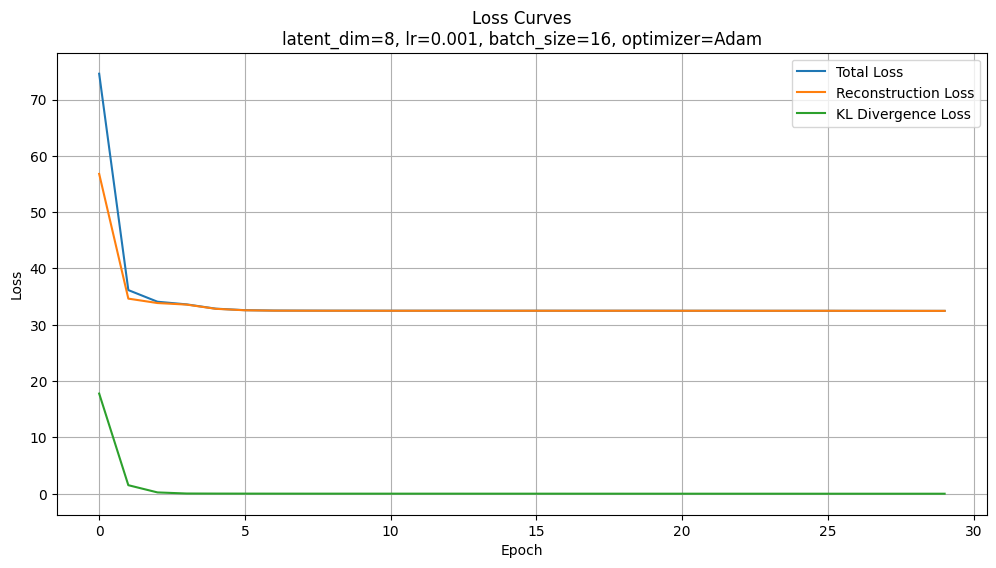

Plot saved: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Plots/loss_latent8_lr0.001_bs16_optAdam.png
Model trained and saved successfully at: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/vae_cnn_latent8_lr0.001_bs16_optAdam.pth

[Training] latent_dim: 16, lr: 0.001, batch_size: 16, optimizer: Adam


Training 16, lr 0.001, bs 16, opt Adam:   3%|▎         | 1/30 [01:52<54:17, 112.33s/it]

Epoch [1/30] - kl: 23.2141 - loss: 96.9571 - recon: 73.7430


Training 16, lr 0.001, bs 16, opt Adam:   7%|▋         | 2/30 [03:44<52:18, 112.10s/it]

Epoch [2/30] - kl: 1.3410 - loss: 44.3682 - recon: 43.0272


Training 16, lr 0.001, bs 16, opt Adam:  10%|█         | 3/30 [05:34<50:03, 111.25s/it]

Epoch [3/30] - kl: 0.0945 - loss: 42.4669 - recon: 42.3724


Training 16, lr 0.001, bs 16, opt Adam:  13%|█▎        | 4/30 [07:24<48:01, 110.82s/it]

Epoch [4/30] - kl: 0.0178 - loss: 42.1261 - recon: 42.1083


Training 16, lr 0.001, bs 16, opt Adam:  17%|█▋        | 5/30 [09:15<46:09, 110.78s/it]

Epoch [5/30] - kl: 0.0128 - loss: 41.9048 - recon: 41.8920


Training 16, lr 0.001, bs 16, opt Adam:  20%|██        | 6/30 [11:06<44:17, 110.74s/it]

Epoch [6/30] - kl: 0.0100 - loss: 41.7148 - recon: 41.7048


Training 16, lr 0.001, bs 16, opt Adam:  23%|██▎       | 7/30 [12:56<42:22, 110.54s/it]

Epoch [7/30] - kl: 0.0180 - loss: 38.9920 - recon: 38.9740


Training 16, lr 0.001, bs 16, opt Adam:  27%|██▋       | 8/30 [14:44<40:19, 109.97s/it]

Epoch [8/30] - kl: 0.0066 - loss: 35.1329 - recon: 35.1263


Training 16, lr 0.001, bs 16, opt Adam:  30%|███       | 9/30 [16:35<38:34, 110.21s/it]

Epoch [9/30] - kl: 0.0057 - loss: 35.0724 - recon: 35.0667


Training 16, lr 0.001, bs 16, opt Adam:  33%|███▎      | 10/30 [18:26<36:45, 110.27s/it]

Epoch [10/30] - kl: 0.0051 - loss: 35.0330 - recon: 35.0280


Training 16, lr 0.001, bs 16, opt Adam:  37%|███▋      | 11/30 [20:14<34:45, 109.76s/it]

Epoch [11/30] - kl: 0.0045 - loss: 35.0122 - recon: 35.0077


Training 16, lr 0.001, bs 16, opt Adam:  40%|████      | 12/30 [22:04<32:54, 109.68s/it]

Epoch [12/30] - kl: 0.0043 - loss: 35.0101 - recon: 35.0058


Training 16, lr 0.001, bs 16, opt Adam:  43%|████▎     | 13/30 [23:54<31:08, 109.92s/it]

Epoch [13/30] - kl: 0.0038 - loss: 35.0053 - recon: 35.0015


Training 16, lr 0.001, bs 16, opt Adam:  47%|████▋     | 14/30 [25:44<29:17, 109.86s/it]

Epoch [14/30] - kl: 0.0036 - loss: 35.0040 - recon: 35.0004


Training 16, lr 0.001, bs 16, opt Adam:  50%|█████     | 15/30 [27:34<27:29, 110.00s/it]

Epoch [15/30] - kl: 0.0034 - loss: 35.0048 - recon: 35.0013


Training 16, lr 0.001, bs 16, opt Adam:  53%|█████▎    | 16/30 [29:26<25:48, 110.59s/it]

Epoch [16/30] - kl: 0.0032 - loss: 34.9988 - recon: 34.9957


Training 16, lr 0.001, bs 16, opt Adam:  57%|█████▋    | 17/30 [31:18<24:02, 110.98s/it]

Epoch [17/30] - kl: 0.0028 - loss: 34.9971 - recon: 34.9943


Training 16, lr 0.001, bs 16, opt Adam:  60%|██████    | 18/30 [33:10<22:13, 111.16s/it]

Epoch [18/30] - kl: 0.0026 - loss: 34.9932 - recon: 34.9907


Training 16, lr 0.001, bs 16, opt Adam:  63%|██████▎   | 19/30 [35:01<20:23, 111.23s/it]

Epoch [19/30] - kl: 0.0030 - loss: 34.9931 - recon: 34.9901


Training 16, lr 0.001, bs 16, opt Adam:  67%|██████▋   | 20/30 [36:53<18:34, 111.41s/it]

Epoch [20/30] - kl: 0.0023 - loss: 34.9977 - recon: 34.9954


Training 16, lr 0.001, bs 16, opt Adam:  70%|███████   | 21/30 [38:45<16:44, 111.62s/it]

Epoch [21/30] - kl: 0.0020 - loss: 34.9908 - recon: 34.9888


Training 16, lr 0.001, bs 16, opt Adam:  73%|███████▎  | 22/30 [40:36<14:50, 111.33s/it]

Epoch [22/30] - kl: 0.0020 - loss: 34.9913 - recon: 34.9892


Training 16, lr 0.001, bs 16, opt Adam:  77%|███████▋  | 23/30 [42:27<12:59, 111.29s/it]

Epoch [23/30] - kl: 0.0017 - loss: 34.9759 - recon: 34.9741


Training 16, lr 0.001, bs 16, opt Adam:  80%|████████  | 24/30 [44:19<11:08, 111.47s/it]

Epoch [24/30] - kl: 0.0015 - loss: 34.8798 - recon: 34.8783


Training 16, lr 0.001, bs 16, opt Adam:  83%|████████▎ | 25/30 [46:10<09:16, 111.32s/it]

Epoch [25/30] - kl: 0.0015 - loss: 34.8516 - recon: 34.8501


Training 16, lr 0.001, bs 16, opt Adam:  87%|████████▋ | 26/30 [48:01<07:25, 111.33s/it]

Epoch [26/30] - kl: 0.0015 - loss: 34.8504 - recon: 34.8490


Training 16, lr 0.001, bs 16, opt Adam:  90%|█████████ | 27/30 [49:53<05:34, 111.59s/it]

Epoch [27/30] - kl: 0.0010 - loss: 34.8521 - recon: 34.8511


Training 16, lr 0.001, bs 16, opt Adam:  93%|█████████▎| 28/30 [51:45<03:43, 111.78s/it]

Epoch [28/30] - kl: 0.0012 - loss: 34.8456 - recon: 34.8443


Training 16, lr 0.001, bs 16, opt Adam:  97%|█████████▋| 29/30 [53:38<01:51, 111.88s/it]

Epoch [29/30] - kl: 0.0019 - loss: 34.8422 - recon: 34.8403


Training 16, lr 0.001, bs 16, opt Adam: 100%|██████████| 30/30 [55:30<00:00, 111.03s/it]


Epoch [30/30] - kl: 0.0011 - loss: 34.8377 - recon: 34.8366
Training duration: 55.51 minutes


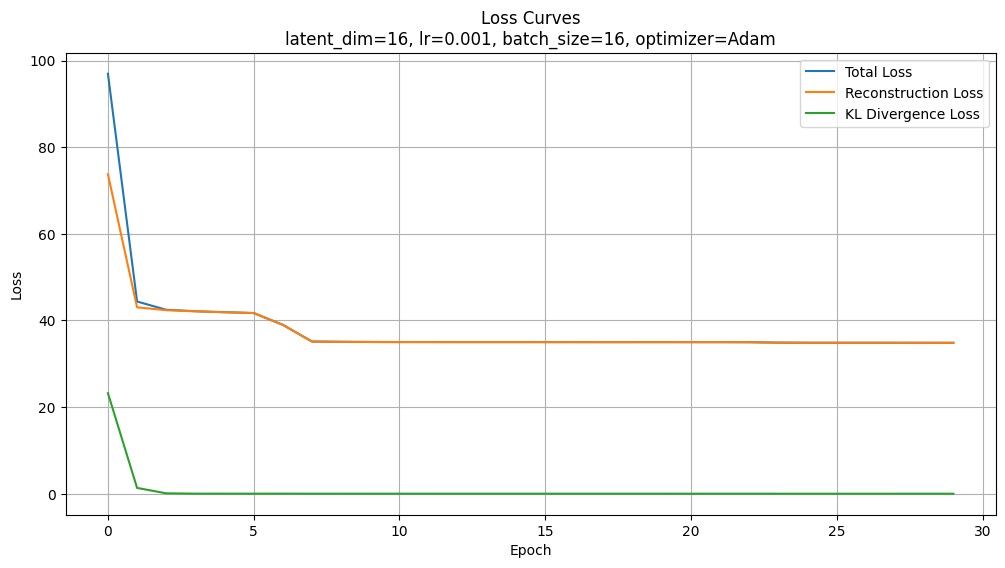

Plot saved: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Plots/loss_latent16_lr0.001_bs16_optAdam.png
Model trained and saved successfully at: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/vae_cnn_latent16_lr0.001_bs16_optAdam.pth

[Training] latent_dim: 32, lr: 0.001, batch_size: 16, optimizer: Adam


Training 32, lr 0.001, bs 16, opt Adam:   3%|▎         | 1/30 [02:20<1:07:44, 140.17s/it]

Epoch [1/30] - kl: 38.0406 - loss: 113.4541 - recon: 75.4135


Training 32, lr 0.001, bs 16, opt Adam:   7%|▋         | 2/30 [04:17<59:05, 126.62s/it]  

Epoch [2/30] - kl: 2.5605 - loss: 46.0963 - recon: 43.5357


Training 32, lr 0.001, bs 16, opt Adam:  10%|█         | 3/30 [06:14<54:58, 122.15s/it]

Epoch [3/30] - kl: 0.1886 - loss: 43.0111 - recon: 42.8225


Training 32, lr 0.001, bs 16, opt Adam:  13%|█▎        | 4/30 [08:11<52:07, 120.30s/it]

Epoch [4/30] - kl: 0.0444 - loss: 42.3874 - recon: 42.3430


Training 32, lr 0.001, bs 16, opt Adam:  17%|█▋        | 5/30 [10:10<49:54, 119.78s/it]

Epoch [5/30] - kl: 0.0325 - loss: 42.1219 - recon: 42.0894


Training 32, lr 0.001, bs 16, opt Adam:  20%|██        | 6/30 [12:23<49:44, 124.36s/it]

Epoch [6/30] - kl: 0.0248 - loss: 41.8794 - recon: 41.8546


Training 32, lr 0.001, bs 16, opt Adam:  23%|██▎       | 7/30 [14:23<47:04, 122.81s/it]

Epoch [7/30] - kl: 0.0262 - loss: 40.0387 - recon: 40.0125


Training 32, lr 0.001, bs 16, opt Adam:  27%|██▋       | 8/30 [16:20<44:22, 121.02s/it]

Epoch [8/30] - kl: 0.0162 - loss: 37.0858 - recon: 37.0697


Training 32, lr 0.001, bs 16, opt Adam:  30%|███       | 9/30 [18:15<41:44, 119.28s/it]

Epoch [9/30] - kl: 0.0136 - loss: 36.2173 - recon: 36.2037


Training 32, lr 0.001, bs 16, opt Adam:  33%|███▎      | 10/30 [20:11<39:22, 118.10s/it]

Epoch [10/30] - kl: 0.0110 - loss: 36.0307 - recon: 36.0197


Training 32, lr 0.001, bs 16, opt Adam:  37%|███▋      | 11/30 [22:07<37:09, 117.36s/it]

Epoch [11/30] - kl: 0.0100 - loss: 35.9983 - recon: 35.9884


Training 32, lr 0.001, bs 16, opt Adam:  40%|████      | 12/30 [24:02<35:02, 116.79s/it]

Epoch [12/30] - kl: 0.0091 - loss: 35.9856 - recon: 35.9765


Training 32, lr 0.001, bs 16, opt Adam:  43%|████▎     | 13/30 [25:57<32:54, 116.18s/it]

Epoch [13/30] - kl: 0.0086 - loss: 35.9817 - recon: 35.9730


Training 32, lr 0.001, bs 16, opt Adam:  47%|████▋     | 14/30 [27:52<30:53, 115.87s/it]

Epoch [14/30] - kl: 0.0079 - loss: 35.9750 - recon: 35.9671


Training 32, lr 0.001, bs 16, opt Adam:  50%|█████     | 15/30 [29:47<28:54, 115.66s/it]

Epoch [15/30] - kl: 0.0080 - loss: 35.9234 - recon: 35.9154


Training 32, lr 0.001, bs 16, opt Adam:  53%|█████▎    | 16/30 [31:43<26:58, 115.61s/it]

Epoch [16/30] - kl: 0.0082 - loss: 33.5702 - recon: 33.5620


Training 32, lr 0.001, bs 16, opt Adam:  57%|█████▋    | 17/30 [33:41<25:13, 116.42s/it]

Epoch [17/30] - kl: 0.0072 - loss: 33.2038 - recon: 33.1966


Training 32, lr 0.001, bs 16, opt Adam:  60%|██████    | 18/30 [35:39<23:24, 117.04s/it]

Epoch [18/30] - kl: 0.0072 - loss: 33.2013 - recon: 33.1941


Training 32, lr 0.001, bs 16, opt Adam:  63%|██████▎   | 19/30 [37:38<21:32, 117.49s/it]

Epoch [19/30] - kl: 0.0067 - loss: 33.1974 - recon: 33.1907


Training 32, lr 0.001, bs 16, opt Adam:  67%|██████▋   | 20/30 [39:34<19:30, 117.06s/it]

Epoch [20/30] - kl: 0.0060 - loss: 33.1977 - recon: 33.1917


Training 32, lr 0.001, bs 16, opt Adam:  70%|███████   | 21/30 [41:31<17:32, 117.00s/it]

Epoch [21/30] - kl: 0.0055 - loss: 33.1963 - recon: 33.1908


Training 32, lr 0.001, bs 16, opt Adam:  73%|███████▎  | 22/30 [43:27<15:34, 116.76s/it]

Epoch [22/30] - kl: 0.0042 - loss: 33.1964 - recon: 33.1922


Training 32, lr 0.001, bs 16, opt Adam:  77%|███████▋  | 23/30 [45:24<13:37, 116.77s/it]

Epoch [23/30] - kl: 0.0043 - loss: 33.1904 - recon: 33.1861


Training 32, lr 0.001, bs 16, opt Adam:  80%|████████  | 24/30 [47:24<11:45, 117.65s/it]

Epoch [24/30] - kl: 0.0035 - loss: 33.1832 - recon: 33.1797


Training 32, lr 0.001, bs 16, opt Adam:  83%|████████▎ | 25/30 [49:21<09:47, 117.50s/it]

Epoch [25/30] - kl: 0.0030 - loss: 33.1746 - recon: 33.1716


Training 32, lr 0.001, bs 16, opt Adam:  87%|████████▋ | 26/30 [51:17<07:48, 117.06s/it]

Epoch [26/30] - kl: 0.0026 - loss: 33.1204 - recon: 33.1178


Training 32, lr 0.001, bs 16, opt Adam:  90%|█████████ | 27/30 [53:14<05:50, 116.99s/it]

Epoch [27/30] - kl: 0.0019 - loss: 33.0550 - recon: 33.0532


Training 32, lr 0.001, bs 16, opt Adam:  93%|█████████▎| 28/30 [55:12<03:54, 117.40s/it]

Epoch [28/30] - kl: 0.0019 - loss: 33.0531 - recon: 33.0512


Training 32, lr 0.001, bs 16, opt Adam:  97%|█████████▋| 29/30 [57:10<01:57, 117.44s/it]

Epoch [29/30] - kl: 0.0014 - loss: 33.0522 - recon: 33.0508


Training 32, lr 0.001, bs 16, opt Adam: 100%|██████████| 30/30 [59:07<00:00, 118.24s/it]


Epoch [30/30] - kl: 0.0017 - loss: 33.0475 - recon: 33.0458
Training duration: 59.12 minutes


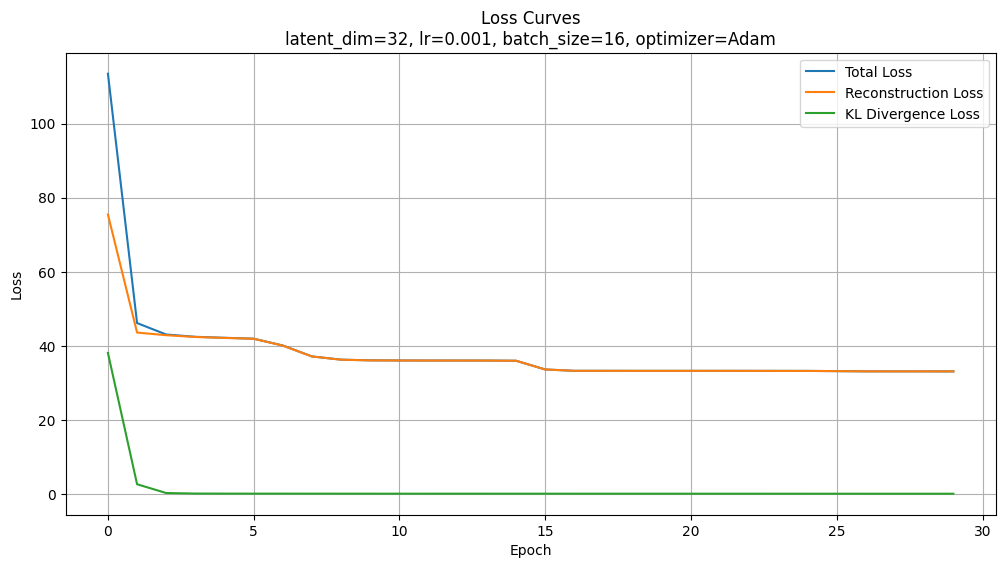

Plot saved: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Plots/loss_latent32_lr0.001_bs16_optAdam.png
Model trained and saved successfully at: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/vae_cnn_latent32_lr0.001_bs16_optAdam.pth


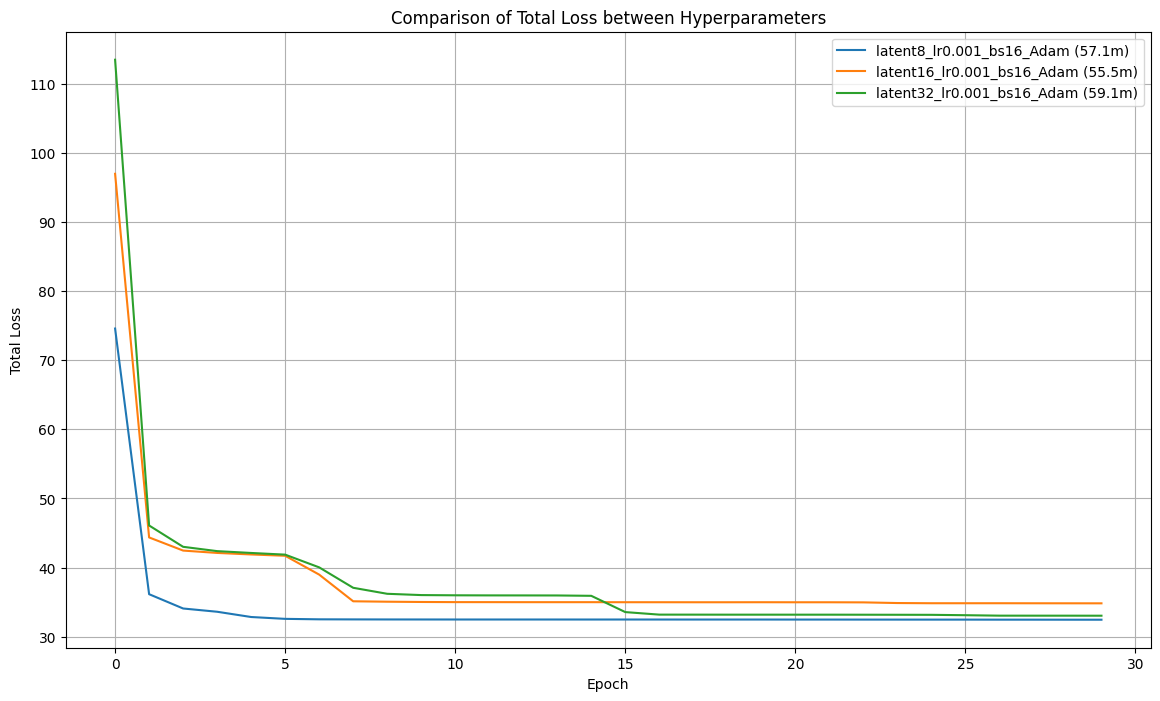

Comparison plot saved: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Plots/comparison_total_loss.png


In [ ]:
#@title With Hyperparameter Tuning (10.000)
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameter candidates
latent_dims = [8, 16, 32]
learning_rates = [0.001]
batch_sizes = [16]
num_epochs = 30
optimizers = ['Adam'] 

# Loss function
mse_loss = nn.MSELoss(reduction='sum')

def vae_loss(recon_x, x, mu, logvar):
    reconstruction_loss = mse_loss(recon_x, x)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    total_loss = reconstruction_loss + kl_loss
    return total_loss, reconstruction_loss, kl_loss

# Save all the combination results
results = []

# Loop hyperparameter combination
for latent_dim in latent_dims:
    for lr in learning_rates:
        for batch_size in batch_sizes:
            for opt_name in optimizers:
                print(f"\n[Training] latent_dim: {latent_dim}, lr: {lr}, batch_size: {batch_size}, optimizer: {opt_name}")

                # Data loader per batch size
                train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=batch_size, shuffle=True)

                # Model & optimizer
                model = VAE_CNN(latent_dim=latent_dim).to(device)
                optimizer = optim.Adam(model.parameters(), lr=lr)

                train_loss_history = []
                recon_loss_history = []
                kl_loss_history = []

                # Begin counting the time
                start_time = time.time()

                for epoch in tqdm(range(num_epochs), desc=f"Training {latent_dim}, lr {lr}, bs {batch_size}, opt {opt_name}"):
                    model.train()
                    total_loss, total_recon_loss, total_kl_loss = 0, 0, 0

                    for batch in train_loader:
                        x_batch = batch[0].to(device)

                        optimizer.zero_grad()
                        recon_batch, mu, logvar = model(x_batch)
                        loss, recon_loss, kl = vae_loss(recon_batch, x_batch, mu, logvar)
                        loss.backward()
                        optimizer.step()

                        total_loss += loss.item()
                        total_recon_loss += recon_loss.item()
                        total_kl_loss += kl.item()

                    avg_loss = total_loss / len(train_loader.dataset)
                    avg_recon_loss = total_recon_loss / len(train_loader.dataset)
                    avg_kl_loss = total_kl_loss / len(train_loader.dataset)

                    train_loss_history.append(avg_loss)
                    recon_loss_history.append(avg_recon_loss)
                    kl_loss_history.append(avg_kl_loss)

                    tqdm.write(f"Epoch [{epoch+1}/{num_epochs}] - kl: {avg_kl_loss:.4f} - loss: {avg_loss:.4f} - recon: {avg_recon_loss:.4f}")

                # Training finished - count the total duration
                end_time = time.time()
                duration = end_time - start_time
                print(f"Training duration: {duration/60:.2f} minutes")

                # Save the result
                results.append({
                    'label': f'latent{latent_dim}_lr{lr}_bs{batch_size}_{opt_name}',
                    'train_loss_history': train_loss_history,
                    'duration': duration
                })

                # Plot individual loss curves
                plt.figure(figsize=(12,6))
                plt.plot(train_loss_history, label='Total Loss')
                plt.plot(recon_loss_history, label='Reconstruction Loss')
                plt.plot(kl_loss_history, label='KL Divergence Loss')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.title(f'Loss Curves\nlatent_dim={latent_dim}, lr={lr}, batch_size={batch_size}, optimizer={opt_name}')
                plt.legend()
                plt.grid()

                # Save plot to drive
                plot_path = f"/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Plots/loss_latent{latent_dim}_lr{lr}_bs{batch_size}_opt{opt_name}.png"
                plt.savefig(plot_path)
                plt.show()
                plt.close()

                print(f"Plot saved: {plot_path}")

                # Save the model after training
                model_path = f"/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/vae_cnn_latent{latent_dim}_lr{lr}_bs{batch_size}_opt{opt_name}.pth"
                torch.save(model.state_dict(), model_path)
                print(f"Model trained and saved successfully at: {model_path}")

# Plot the total loss comparison between all the candidates
plt.figure(figsize=(14,8))
for result in results:
    plt.plot(result['train_loss_history'], label=f"{result['label']} ({result['duration']/60:.1f}m)")

plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Comparison of Total Loss between Hyperparameters')
plt.legend()
plt.grid()

# Save comparison plot to drive
comparison_plot_path = "/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Plots/comparison_total_loss.png"
plt.savefig(comparison_plot_path)
plt.show()
plt.close()

print(f"Comparison plot saved: {comparison_plot_path}")


[Training] latent_dim: 4, lr: 0.001, batch_size: 16, optimizer: Adam


Training 4, lr 0.001, bs 16, opt Adam:   5%|▌         | 1/20 [02:18<43:47, 138.31s/it]

Epoch [1/20] - kl: 9.1458 - loss: 73.4539 - recon: 64.3081


Training 4, lr 0.001, bs 16, opt Adam:  10%|█         | 2/20 [04:33<40:58, 136.59s/it]

Epoch [2/20] - kl: 3.7949 - loss: 37.9447 - recon: 34.1498


Training 4, lr 0.001, bs 16, opt Adam:  15%|█▌        | 3/20 [06:53<39:07, 138.06s/it]

Epoch [3/20] - kl: 2.3575 - loss: 36.1016 - recon: 33.7440


Training 4, lr 0.001, bs 16, opt Adam:  20%|██        | 4/20 [09:08<36:30, 136.91s/it]

Epoch [4/20] - kl: 1.4684 - loss: 34.9618 - recon: 33.4934


Training 4, lr 0.001, bs 16, opt Adam:  25%|██▌       | 5/20 [11:28<34:27, 137.83s/it]

Epoch [5/20] - kl: 0.9121 - loss: 34.2044 - recon: 33.2923


Training 4, lr 0.001, bs 16, opt Adam:  30%|███       | 6/20 [13:48<32:20, 138.63s/it]

Epoch [6/20] - kl: 0.5290 - loss: 33.6542 - recon: 33.1252


Training 4, lr 0.001, bs 16, opt Adam:  35%|███▌      | 7/20 [16:10<30:16, 139.74s/it]

Epoch [7/20] - kl: 0.2461 - loss: 33.2396 - recon: 32.9934


Training 4, lr 0.001, bs 16, opt Adam:  40%|████      | 8/20 [18:29<27:53, 139.46s/it]

Epoch [8/20] - kl: 0.1078 - loss: 32.9201 - recon: 32.8123


Training 4, lr 0.001, bs 16, opt Adam:  45%|████▌     | 9/20 [20:46<25:28, 138.92s/it]

Epoch [9/20] - kl: 0.0391 - loss: 32.7230 - recon: 32.6840


Training 4, lr 0.001, bs 16, opt Adam:  50%|█████     | 10/20 [23:02<22:58, 137.87s/it]

Epoch [10/20] - kl: 0.0141 - loss: 32.5926 - recon: 32.5784


Training 4, lr 0.001, bs 16, opt Adam:  55%|█████▌    | 11/20 [25:18<20:34, 137.17s/it]

Epoch [11/20] - kl: 0.0060 - loss: 32.5320 - recon: 32.5259


Training 4, lr 0.001, bs 16, opt Adam:  60%|██████    | 12/20 [27:35<18:18, 137.37s/it]

Epoch [12/20] - kl: 0.0035 - loss: 32.5051 - recon: 32.5016


Training 4, lr 0.001, bs 16, opt Adam:  65%|██████▌   | 13/20 [29:53<16:01, 137.43s/it]

Epoch [13/20] - kl: 0.0021 - loss: 32.4626 - recon: 32.4605


Training 4, lr 0.001, bs 16, opt Adam:  70%|███████   | 14/20 [32:10<13:44, 137.47s/it]

Epoch [14/20] - kl: 0.0014 - loss: 32.4463 - recon: 32.4449


Training 4, lr 0.001, bs 16, opt Adam:  75%|███████▌  | 15/20 [34:27<11:26, 137.22s/it]

Epoch [15/20] - kl: 0.0012 - loss: 32.4458 - recon: 32.4446


Training 4, lr 0.001, bs 16, opt Adam:  80%|████████  | 16/20 [36:44<09:07, 136.98s/it]

Epoch [16/20] - kl: 0.0010 - loss: 32.4190 - recon: 32.4181


Training 4, lr 0.001, bs 16, opt Adam:  85%|████████▌ | 17/20 [39:01<06:51, 137.25s/it]

Epoch [17/20] - kl: 0.0008 - loss: 32.4110 - recon: 32.4103


Training 4, lr 0.001, bs 16, opt Adam:  90%|█████████ | 18/20 [41:20<04:35, 137.53s/it]

Epoch [18/20] - kl: 0.0006 - loss: 32.3992 - recon: 32.3986


Training 4, lr 0.001, bs 16, opt Adam:  95%|█████████▌| 19/20 [43:36<02:17, 137.31s/it]

Epoch [19/20] - kl: 0.0005 - loss: 32.4000 - recon: 32.3995


Training 4, lr 0.001, bs 16, opt Adam: 100%|██████████| 20/20 [45:55<00:00, 137.79s/it]


Epoch [20/20] - kl: 0.0004 - loss: 32.3827 - recon: 32.3824
Training duration: 45.93 minutes


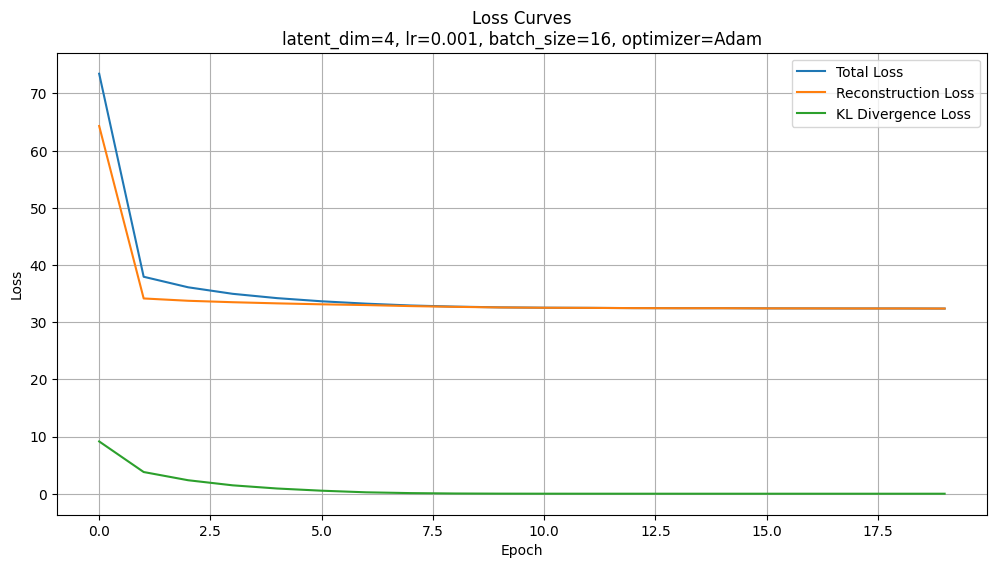

Plot saved: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Plots/Fixed/loss_latent4_lr0.001_bs16_optAdam.png
Model trained and saved successfully at: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/vae_cnn_latent4_lr0.001_bs16_optAdam.pth

[Training] latent_dim: 4, lr: 0.001, batch_size: 32, optimizer: Adam


Training 4, lr 0.001, bs 32, opt Adam:   5%|▌         | 1/20 [02:16<43:17, 136.73s/it]

Epoch [1/20] - kl: 11.8490 - loss: 126.9941 - recon: 115.1451


Training 4, lr 0.001, bs 32, opt Adam:  10%|█         | 2/20 [04:29<40:20, 134.47s/it]

Epoch [2/20] - kl: 6.3420 - loss: 41.2987 - recon: 34.9567


Training 4, lr 0.001, bs 32, opt Adam:  15%|█▌        | 3/20 [06:45<38:16, 135.10s/it]

Epoch [3/20] - kl: 4.6225 - loss: 38.8033 - recon: 34.1808


Training 4, lr 0.001, bs 32, opt Adam:  20%|██        | 4/20 [09:00<36:02, 135.16s/it]

Epoch [4/20] - kl: 3.6121 - loss: 37.4588 - recon: 33.8467


Training 4, lr 0.001, bs 32, opt Adam:  25%|██▌       | 5/20 [11:23<34:29, 137.95s/it]

Epoch [5/20] - kl: 2.9358 - loss: 36.5545 - recon: 33.6186


Training 4, lr 0.001, bs 32, opt Adam:  30%|███       | 6/20 [13:40<32:07, 137.67s/it]

Epoch [6/20] - kl: 2.3820 - loss: 35.8664 - recon: 33.4843


Training 4, lr 0.001, bs 32, opt Adam:  35%|███▌      | 7/20 [15:57<29:47, 137.48s/it]

Epoch [7/20] - kl: 1.9469 - loss: 35.2971 - recon: 33.3502


Training 4, lr 0.001, bs 32, opt Adam:  40%|████      | 8/20 [18:13<27:22, 136.85s/it]

Epoch [8/20] - kl: 1.5869 - loss: 34.8943 - recon: 33.3075


Training 4, lr 0.001, bs 32, opt Adam:  45%|████▌     | 9/20 [20:29<25:04, 136.75s/it]

Epoch [9/20] - kl: 1.2338 - loss: 34.4516 - recon: 33.2177


Training 4, lr 0.001, bs 32, opt Adam:  50%|█████     | 10/20 [22:45<22:43, 136.36s/it]

Epoch [10/20] - kl: 1.0049 - loss: 34.1623 - recon: 33.1574


Training 4, lr 0.001, bs 32, opt Adam:  55%|█████▌    | 11/20 [24:59<20:22, 135.81s/it]

Epoch [11/20] - kl: 0.7858 - loss: 33.9331 - recon: 33.1473


Training 4, lr 0.001, bs 32, opt Adam:  60%|██████    | 12/20 [27:14<18:03, 135.47s/it]

Epoch [12/20] - kl: 0.5688 - loss: 33.6465 - recon: 33.0777


Training 4, lr 0.001, bs 32, opt Adam:  65%|██████▌   | 13/20 [29:30<15:49, 135.64s/it]

Epoch [13/20] - kl: 0.4336 - loss: 33.4133 - recon: 32.9797


Training 4, lr 0.001, bs 32, opt Adam:  70%|███████   | 14/20 [31:44<13:30, 135.08s/it]

Epoch [14/20] - kl: 0.3115 - loss: 33.3261 - recon: 33.0146


Training 4, lr 0.001, bs 32, opt Adam:  75%|███████▌  | 15/20 [34:00<11:16, 135.39s/it]

Epoch [15/20] - kl: 0.1977 - loss: 33.0956 - recon: 32.8979


Training 4, lr 0.001, bs 32, opt Adam:  80%|████████  | 16/20 [36:17<09:03, 135.84s/it]

Epoch [16/20] - kl: 0.1203 - loss: 32.8914 - recon: 32.7712


Training 4, lr 0.001, bs 32, opt Adam:  85%|████████▌ | 17/20 [38:34<06:48, 136.17s/it]

Epoch [17/20] - kl: 0.0755 - loss: 32.7898 - recon: 32.7143


Training 4, lr 0.001, bs 32, opt Adam:  90%|█████████ | 18/20 [40:51<04:32, 136.33s/it]

Epoch [18/20] - kl: 0.0456 - loss: 32.7171 - recon: 32.6715


Training 4, lr 0.001, bs 32, opt Adam:  95%|█████████▌| 19/20 [43:07<02:16, 136.43s/it]

Epoch [19/20] - kl: 0.0322 - loss: 32.6331 - recon: 32.6009


Training 4, lr 0.001, bs 32, opt Adam: 100%|██████████| 20/20 [45:22<00:00, 136.10s/it]


Epoch [20/20] - kl: 0.0199 - loss: 32.5887 - recon: 32.5688
Training duration: 45.37 minutes


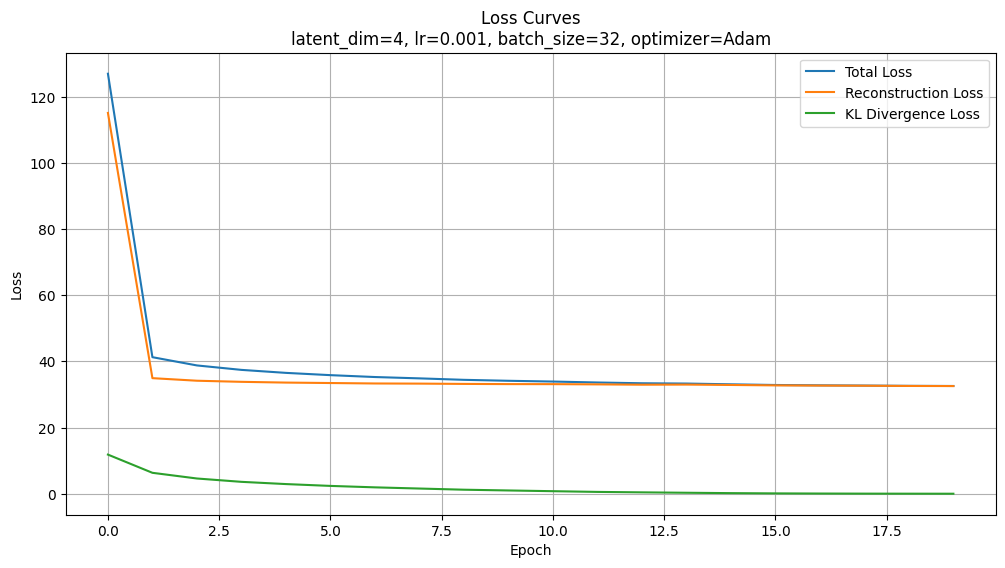

Plot saved: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Plots/Fixed/loss_latent4_lr0.001_bs32_optAdam.png
Model trained and saved successfully at: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/vae_cnn_latent4_lr0.001_bs32_optAdam.pth

[Training] latent_dim: 8, lr: 0.001, batch_size: 16, optimizer: Adam


Training 8, lr 0.001, bs 16, opt Adam:   5%|▌         | 1/20 [02:14<42:37, 134.58s/it]

Epoch [1/20] - kl: 16.2332 - loss: 128.2487 - recon: 112.0155


Training 8, lr 0.001, bs 16, opt Adam:  10%|█         | 2/20 [04:30<40:32, 135.12s/it]

Epoch [2/20] - kl: 4.9948 - loss: 40.2832 - recon: 35.2884


Training 8, lr 0.001, bs 16, opt Adam:  15%|█▌        | 3/20 [06:45<38:17, 135.16s/it]

Epoch [3/20] - kl: 2.6509 - loss: 36.8513 - recon: 34.2004


Training 8, lr 0.001, bs 16, opt Adam:  20%|██        | 4/20 [09:00<36:06, 135.38s/it]

Epoch [4/20] - kl: 1.6548 - loss: 35.3617 - recon: 33.7068


Training 8, lr 0.001, bs 16, opt Adam:  25%|██▌       | 5/20 [11:17<33:55, 135.70s/it]

Epoch [5/20] - kl: 0.8567 - loss: 34.1860 - recon: 33.3293


Training 8, lr 0.001, bs 16, opt Adam:  30%|███       | 6/20 [13:31<31:31, 135.13s/it]

Epoch [6/20] - kl: 0.4312 - loss: 33.5106 - recon: 33.0793


Training 8, lr 0.001, bs 16, opt Adam:  35%|███▌      | 7/20 [15:47<29:21, 135.51s/it]

Epoch [7/20] - kl: 0.1875 - loss: 33.0542 - recon: 32.8668


Training 8, lr 0.001, bs 16, opt Adam:  40%|████      | 8/20 [18:03<27:08, 135.73s/it]

Epoch [8/20] - kl: 0.0672 - loss: 32.7493 - recon: 32.6821


Training 8, lr 0.001, bs 16, opt Adam:  45%|████▌     | 9/20 [20:18<24:50, 135.52s/it]

Epoch [9/20] - kl: 0.0272 - loss: 32.6275 - recon: 32.6003


Training 8, lr 0.001, bs 16, opt Adam:  50%|█████     | 10/20 [22:33<22:34, 135.40s/it]

Epoch [10/20] - kl: 0.0106 - loss: 32.5439 - recon: 32.5333


Training 8, lr 0.001, bs 16, opt Adam:  55%|█████▌    | 11/20 [24:49<20:20, 135.58s/it]

Epoch [11/20] - kl: 0.0055 - loss: 32.5063 - recon: 32.5008


Training 8, lr 0.001, bs 16, opt Adam:  60%|██████    | 12/20 [27:04<18:01, 135.17s/it]

Epoch [12/20] - kl: 0.0032 - loss: 32.4684 - recon: 32.4652


Training 8, lr 0.001, bs 16, opt Adam:  65%|██████▌   | 13/20 [29:19<15:47, 135.29s/it]

Epoch [13/20] - kl: 0.0025 - loss: 32.4452 - recon: 32.4427


Training 8, lr 0.001, bs 16, opt Adam:  70%|███████   | 14/20 [31:35<13:32, 135.37s/it]

Epoch [14/20] - kl: 0.0018 - loss: 32.4352 - recon: 32.4334


Training 8, lr 0.001, bs 16, opt Adam:  75%|███████▌  | 15/20 [33:51<11:17, 135.47s/it]

Epoch [15/20] - kl: 0.0012 - loss: 32.4342 - recon: 32.4330


Training 8, lr 0.001, bs 16, opt Adam:  80%|████████  | 16/20 [36:08<09:04, 136.09s/it]

Epoch [16/20] - kl: 0.0009 - loss: 32.4186 - recon: 32.4177


Training 8, lr 0.001, bs 16, opt Adam:  85%|████████▌ | 17/20 [38:24<06:48, 136.15s/it]

Epoch [17/20] - kl: 0.0008 - loss: 32.4302 - recon: 32.4294


Training 8, lr 0.001, bs 16, opt Adam:  90%|█████████ | 18/20 [40:40<04:31, 135.88s/it]

Epoch [18/20] - kl: 0.0008 - loss: 32.3960 - recon: 32.3952


Training 8, lr 0.001, bs 16, opt Adam:  95%|█████████▌| 19/20 [42:55<02:15, 135.76s/it]

Epoch [19/20] - kl: 0.0008 - loss: 32.3975 - recon: 32.3967


Training 8, lr 0.001, bs 16, opt Adam: 100%|██████████| 20/20 [45:11<00:00, 135.56s/it]


Epoch [20/20] - kl: 0.0006 - loss: 32.3957 - recon: 32.3951
Training duration: 45.19 minutes


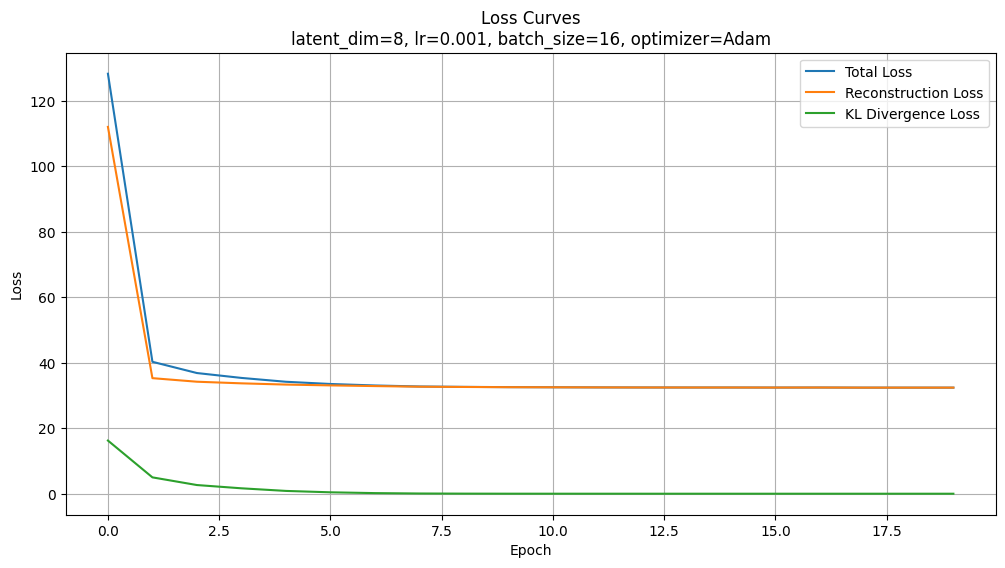

Plot saved: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Plots/Fixed/loss_latent8_lr0.001_bs16_optAdam.png
Model trained and saved successfully at: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/vae_cnn_latent8_lr0.001_bs16_optAdam.pth

[Training] latent_dim: 8, lr: 0.001, batch_size: 32, optimizer: Adam


Training 8, lr 0.001, bs 32, opt Adam:   5%|▌         | 1/20 [02:15<42:51, 135.37s/it]

Epoch [1/20] - kl: 20.6250 - loss: 190.1069 - recon: 169.4819


Training 8, lr 0.001, bs 32, opt Adam:  10%|█         | 2/20 [04:31<40:39, 135.55s/it]

Epoch [2/20] - kl: 9.5202 - loss: 46.4402 - recon: 36.9200


Training 8, lr 0.001, bs 32, opt Adam:  15%|█▌        | 3/20 [06:46<38:26, 135.70s/it]

Epoch [3/20] - kl: 6.5230 - loss: 42.1500 - recon: 35.6270


Training 8, lr 0.001, bs 32, opt Adam:  20%|██        | 4/20 [09:01<36:01, 135.08s/it]

Epoch [4/20] - kl: 4.8485 - loss: 39.8284 - recon: 34.9799


Training 8, lr 0.001, bs 32, opt Adam:  25%|██▌       | 5/20 [11:14<33:39, 134.63s/it]

Epoch [5/20] - kl: 3.6854 - loss: 38.2157 - recon: 34.5304


Training 8, lr 0.001, bs 32, opt Adam:  30%|███       | 6/20 [13:27<31:15, 133.96s/it]

Epoch [6/20] - kl: 2.9087 - loss: 37.1271 - recon: 34.2184


Training 8, lr 0.001, bs 32, opt Adam:  35%|███▌      | 7/20 [15:40<28:55, 133.53s/it]

Epoch [7/20] - kl: 2.2954 - loss: 36.2846 - recon: 33.9893


Training 8, lr 0.001, bs 32, opt Adam:  40%|████      | 8/20 [17:51<26:32, 132.69s/it]

Epoch [8/20] - kl: 1.7994 - loss: 35.5721 - recon: 33.7727


Training 8, lr 0.001, bs 32, opt Adam:  45%|████▌     | 9/20 [20:04<24:23, 133.05s/it]

Epoch [9/20] - kl: 1.3937 - loss: 34.9860 - recon: 33.5923


Training 8, lr 0.001, bs 32, opt Adam:  50%|█████     | 10/20 [22:16<22:05, 132.50s/it]

Epoch [10/20] - kl: 1.0866 - loss: 34.5545 - recon: 33.4679


Training 8, lr 0.001, bs 32, opt Adam:  55%|█████▌    | 11/20 [24:28<19:51, 132.43s/it]

Epoch [11/20] - kl: 0.7864 - loss: 34.0984 - recon: 33.3119


Training 8, lr 0.001, bs 32, opt Adam:  60%|██████    | 12/20 [26:39<17:35, 131.99s/it]

Epoch [12/20] - kl: 0.5626 - loss: 33.7492 - recon: 33.1866


Training 8, lr 0.001, bs 32, opt Adam:  65%|██████▌   | 13/20 [28:50<15:22, 131.83s/it]

Epoch [13/20] - kl: 0.3732 - loss: 33.4314 - recon: 33.0582


Training 8, lr 0.001, bs 32, opt Adam:  70%|███████   | 14/20 [31:02<13:09, 131.64s/it]

Epoch [14/20] - kl: 0.2497 - loss: 33.1943 - recon: 32.9447


Training 8, lr 0.001, bs 32, opt Adam:  75%|███████▌  | 15/20 [33:15<11:00, 132.08s/it]

Epoch [15/20] - kl: 0.1493 - loss: 33.0040 - recon: 32.8547


Training 8, lr 0.001, bs 32, opt Adam:  80%|████████  | 16/20 [35:29<08:50, 132.74s/it]

Epoch [16/20] - kl: 0.0971 - loss: 32.9084 - recon: 32.8114


Training 8, lr 0.001, bs 32, opt Adam:  85%|████████▌ | 17/20 [37:42<06:38, 132.68s/it]

Epoch [17/20] - kl: 0.0566 - loss: 32.7467 - recon: 32.6901


Training 8, lr 0.001, bs 32, opt Adam:  90%|█████████ | 18/20 [39:53<04:24, 132.40s/it]

Epoch [18/20] - kl: 0.0303 - loss: 32.6791 - recon: 32.6489


Training 8, lr 0.001, bs 32, opt Adam:  95%|█████████▌| 19/20 [42:06<02:12, 132.54s/it]

Epoch [19/20] - kl: 0.0209 - loss: 32.6392 - recon: 32.6183


Training 8, lr 0.001, bs 32, opt Adam: 100%|██████████| 20/20 [44:16<00:00, 132.82s/it]


Epoch [20/20] - kl: 0.0138 - loss: 32.5782 - recon: 32.5644
Training duration: 44.27 minutes


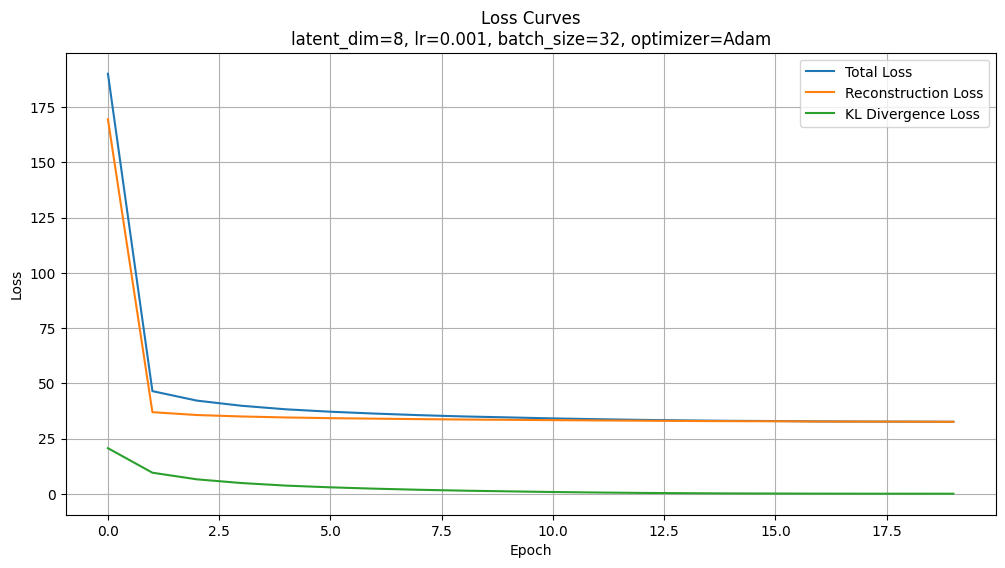

Plot saved: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Plots/Fixed/loss_latent8_lr0.001_bs32_optAdam.png
Model trained and saved successfully at: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/vae_cnn_latent8_lr0.001_bs32_optAdam.pth

[Training] latent_dim: 16, lr: 0.001, batch_size: 16, optimizer: Adam


Training 16, lr 0.001, bs 16, opt Adam:   5%|▌         | 1/20 [02:13<42:12, 133.29s/it]

Epoch [1/20] - kl: 17.9306 - loss: 103.4288 - recon: 85.4982


Training 16, lr 0.001, bs 16, opt Adam:  10%|█         | 2/20 [04:25<39:49, 132.76s/it]

Epoch [2/20] - kl: 4.3224 - loss: 40.4165 - recon: 36.0940


Training 16, lr 0.001, bs 16, opt Adam:  15%|█▌        | 3/20 [06:39<37:46, 133.31s/it]

Epoch [3/20] - kl: 2.0220 - loss: 36.5790 - recon: 34.5570


Training 16, lr 0.001, bs 16, opt Adam:  20%|██        | 4/20 [08:52<35:27, 132.98s/it]

Epoch [4/20] - kl: 0.8785 - loss: 34.6476 - recon: 33.7691


Training 16, lr 0.001, bs 16, opt Adam:  25%|██▌       | 5/20 [11:06<33:21, 133.47s/it]

Epoch [5/20] - kl: 0.3043 - loss: 33.5152 - recon: 33.2108


Training 16, lr 0.001, bs 16, opt Adam:  30%|███       | 6/20 [13:16<30:53, 132.36s/it]

Epoch [6/20] - kl: 0.0846 - loss: 32.9305 - recon: 32.8460


Training 16, lr 0.001, bs 16, opt Adam:  35%|███▌      | 7/20 [15:30<28:46, 132.80s/it]

Epoch [7/20] - kl: 0.0281 - loss: 32.6874 - recon: 32.6593


Training 16, lr 0.001, bs 16, opt Adam:  40%|████      | 8/20 [17:40<26:24, 132.03s/it]

Epoch [8/20] - kl: 0.0118 - loss: 32.5725 - recon: 32.5607


Training 16, lr 0.001, bs 16, opt Adam:  45%|████▌     | 9/20 [19:54<24:17, 132.46s/it]

Epoch [9/20] - kl: 0.0077 - loss: 32.5252 - recon: 32.5175


Training 16, lr 0.001, bs 16, opt Adam:  50%|█████     | 10/20 [22:06<22:05, 132.51s/it]

Epoch [10/20] - kl: 0.0051 - loss: 32.5196 - recon: 32.5145


Training 16, lr 0.001, bs 16, opt Adam:  55%|█████▌    | 11/20 [24:21<19:57, 133.07s/it]

Epoch [11/20] - kl: 0.0041 - loss: 32.5005 - recon: 32.4964


Training 16, lr 0.001, bs 16, opt Adam:  60%|██████    | 12/20 [26:33<17:41, 132.73s/it]

Epoch [12/20] - kl: 0.0035 - loss: 32.4961 - recon: 32.4926


Training 16, lr 0.001, bs 16, opt Adam:  65%|██████▌   | 13/20 [28:47<15:32, 133.28s/it]

Epoch [13/20] - kl: 0.0029 - loss: 32.4722 - recon: 32.4692


Training 16, lr 0.001, bs 16, opt Adam:  70%|███████   | 14/20 [31:03<13:23, 133.99s/it]

Epoch [14/20] - kl: 0.0027 - loss: 32.4611 - recon: 32.4584


Training 16, lr 0.001, bs 16, opt Adam:  75%|███████▌  | 15/20 [33:18<11:12, 134.51s/it]

Epoch [15/20] - kl: 0.0025 - loss: 32.4675 - recon: 32.4650


Training 16, lr 0.001, bs 16, opt Adam:  80%|████████  | 16/20 [35:34<08:59, 134.78s/it]

Epoch [16/20] - kl: 0.0024 - loss: 32.4500 - recon: 32.4476


Training 16, lr 0.001, bs 16, opt Adam:  85%|████████▌ | 17/20 [37:50<06:45, 135.04s/it]

Epoch [17/20] - kl: 0.0018 - loss: 32.4371 - recon: 32.4353


Training 16, lr 0.001, bs 16, opt Adam:  90%|█████████ | 18/20 [40:04<04:29, 134.80s/it]

Epoch [18/20] - kl: 0.0020 - loss: 32.4318 - recon: 32.4298


Training 16, lr 0.001, bs 16, opt Adam:  95%|█████████▌| 19/20 [42:20<02:15, 135.23s/it]

Epoch [19/20] - kl: 0.0019 - loss: 32.4253 - recon: 32.4234


Training 16, lr 0.001, bs 16, opt Adam: 100%|██████████| 20/20 [44:37<00:00, 133.85s/it]


Epoch [20/20] - kl: 0.0015 - loss: 32.4264 - recon: 32.4250
Training duration: 44.62 minutes


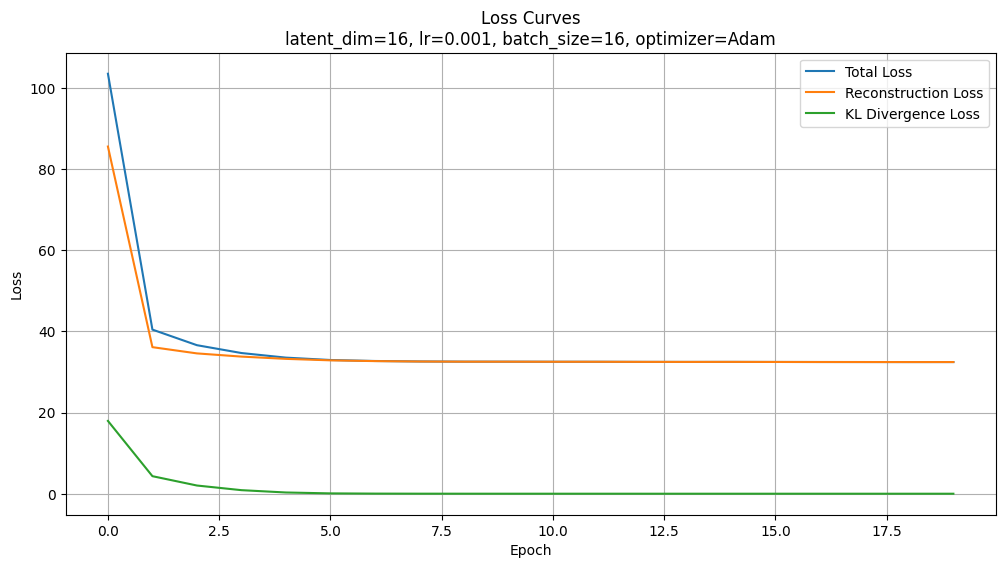

Plot saved: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Plots/Fixed/loss_latent16_lr0.001_bs16_optAdam.png
Model trained and saved successfully at: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/vae_cnn_latent16_lr0.001_bs16_optAdam.pth

[Training] latent_dim: 16, lr: 0.001, batch_size: 32, optimizer: Adam


Training 16, lr 0.001, bs 32, opt Adam:   5%|▌         | 1/20 [02:14<42:39, 134.69s/it]

Epoch [1/20] - kl: 26.8742 - loss: 211.4523 - recon: 184.5781


Training 16, lr 0.001, bs 32, opt Adam:  10%|█         | 2/20 [04:30<40:38, 135.48s/it]

Epoch [2/20] - kl: 10.4614 - loss: 49.8179 - recon: 39.3566


Training 16, lr 0.001, bs 32, opt Adam:  15%|█▌        | 3/20 [06:47<38:36, 136.24s/it]

Epoch [3/20] - kl: 6.2311 - loss: 43.2508 - recon: 37.0197


Training 16, lr 0.001, bs 32, opt Adam:  20%|██        | 4/20 [09:02<36:10, 135.66s/it]

Epoch [4/20] - kl: 4.1011 - loss: 39.8735 - recon: 35.7724


Training 16, lr 0.001, bs 32, opt Adam:  25%|██▌       | 5/20 [11:20<34:06, 136.42s/it]

Epoch [5/20] - kl: 2.9975 - loss: 38.0565 - recon: 35.0590


Training 16, lr 0.001, bs 32, opt Adam:  30%|███       | 6/20 [13:37<31:54, 136.74s/it]

Epoch [6/20] - kl: 2.2204 - loss: 36.7678 - recon: 34.5474


Training 16, lr 0.001, bs 32, opt Adam:  35%|███▌      | 7/20 [15:56<29:44, 137.27s/it]

Epoch [7/20] - kl: 1.6287 - loss: 35.7913 - recon: 34.1626


Training 16, lr 0.001, bs 32, opt Adam:  40%|████      | 8/20 [18:11<27:20, 136.67s/it]

Epoch [8/20] - kl: 1.1878 - loss: 35.0587 - recon: 33.8710


Training 16, lr 0.001, bs 32, opt Adam:  45%|████▌     | 9/20 [20:28<25:03, 136.67s/it]

Epoch [9/20] - kl: 0.8071 - loss: 34.3718 - recon: 33.5647


Training 16, lr 0.001, bs 32, opt Adam:  50%|█████     | 10/20 [22:43<22:41, 136.10s/it]

Epoch [10/20] - kl: 0.5449 - loss: 33.8962 - recon: 33.3514


Training 16, lr 0.001, bs 32, opt Adam:  55%|█████▌    | 11/20 [24:57<20:19, 135.46s/it]

Epoch [11/20] - kl: 0.3306 - loss: 33.4596 - recon: 33.1290


Training 16, lr 0.001, bs 32, opt Adam:  60%|██████    | 12/20 [27:10<17:59, 134.96s/it]

Epoch [12/20] - kl: 0.1989 - loss: 33.1749 - recon: 32.9760


Training 16, lr 0.001, bs 32, opt Adam:  65%|██████▌   | 13/20 [29:23<15:39, 134.23s/it]

Epoch [13/20] - kl: 0.1112 - loss: 32.9721 - recon: 32.8609


Training 16, lr 0.001, bs 32, opt Adam:  70%|███████   | 14/20 [31:36<13:22, 133.78s/it]

Epoch [14/20] - kl: 0.0629 - loss: 32.7808 - recon: 32.7179


Training 16, lr 0.001, bs 32, opt Adam:  75%|███████▌  | 15/20 [33:49<11:07, 133.53s/it]

Epoch [15/20] - kl: 0.0396 - loss: 32.6944 - recon: 32.6549


Training 16, lr 0.001, bs 32, opt Adam:  80%|████████  | 16/20 [36:02<08:54, 133.53s/it]

Epoch [16/20] - kl: 0.0256 - loss: 32.6092 - recon: 32.5836


Training 16, lr 0.001, bs 32, opt Adam:  85%|████████▌ | 17/20 [38:11<06:36, 132.25s/it]

Epoch [17/20] - kl: 0.0151 - loss: 32.5463 - recon: 32.5312


Training 16, lr 0.001, bs 32, opt Adam:  90%|█████████ | 18/20 [40:25<04:25, 132.67s/it]

Epoch [18/20] - kl: 0.0117 - loss: 32.5346 - recon: 32.5229


Training 16, lr 0.001, bs 32, opt Adam:  95%|█████████▌| 19/20 [42:39<02:13, 133.04s/it]

Epoch [19/20] - kl: 0.0086 - loss: 32.5030 - recon: 32.4945


Training 16, lr 0.001, bs 32, opt Adam: 100%|██████████| 20/20 [44:54<00:00, 134.73s/it]


Epoch [20/20] - kl: 0.0066 - loss: 32.4720 - recon: 32.4654
Training duration: 44.91 minutes


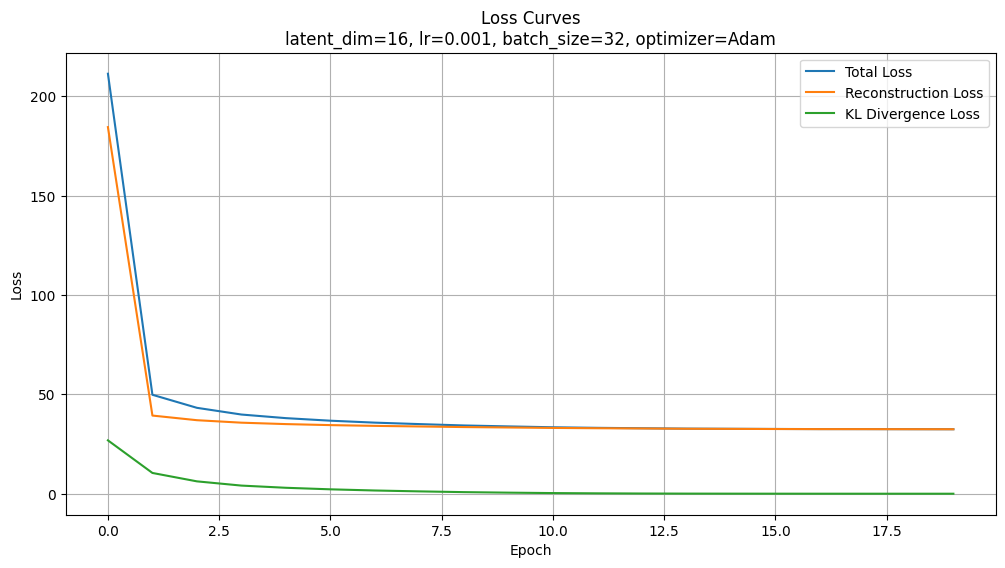

Plot saved: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Plots/Fixed/loss_latent16_lr0.001_bs32_optAdam.png
Model trained and saved successfully at: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/vae_cnn_latent16_lr0.001_bs32_optAdam.pth


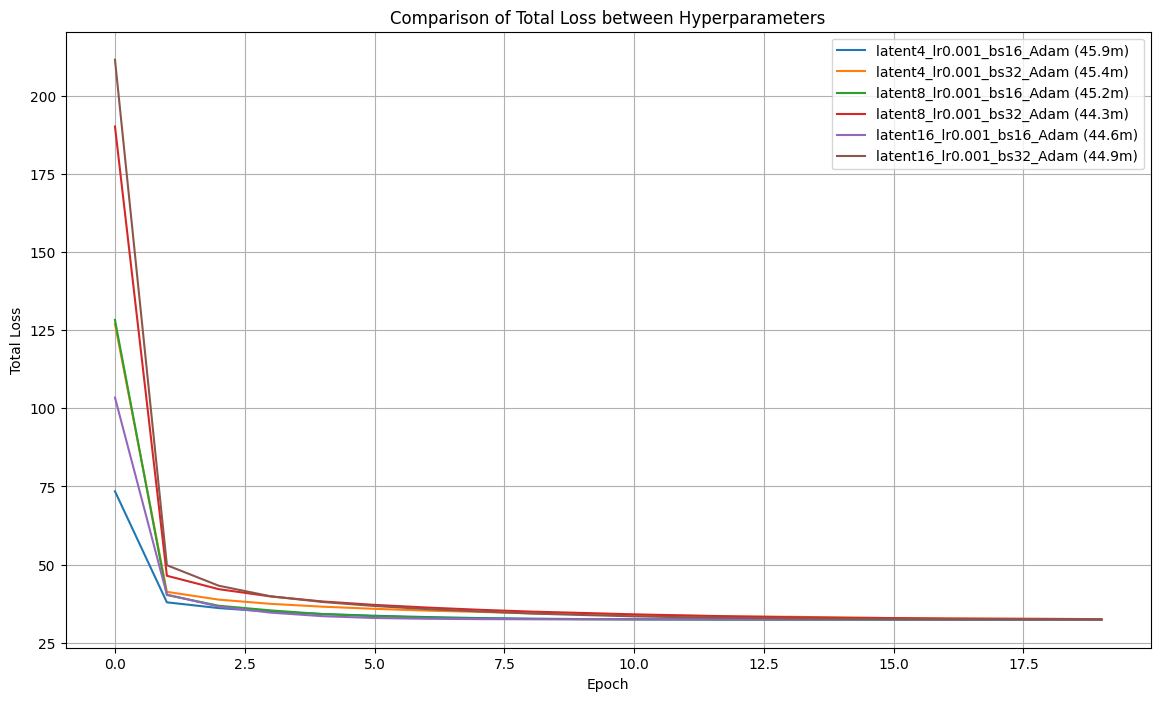

Comparison plot saved: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Plots/Fixed/comparison_total_loss_updated.png


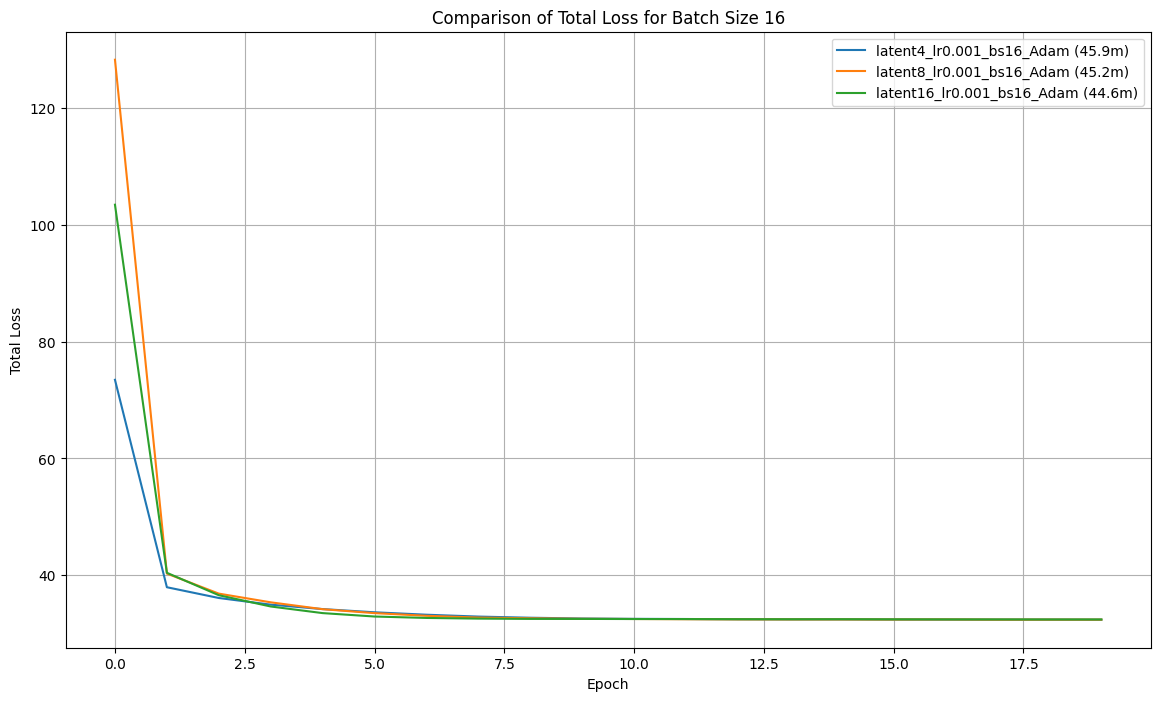

Batch-specific comparison plot saved: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Plots/Fixed/comparison_total_loss_batch16_updated.png


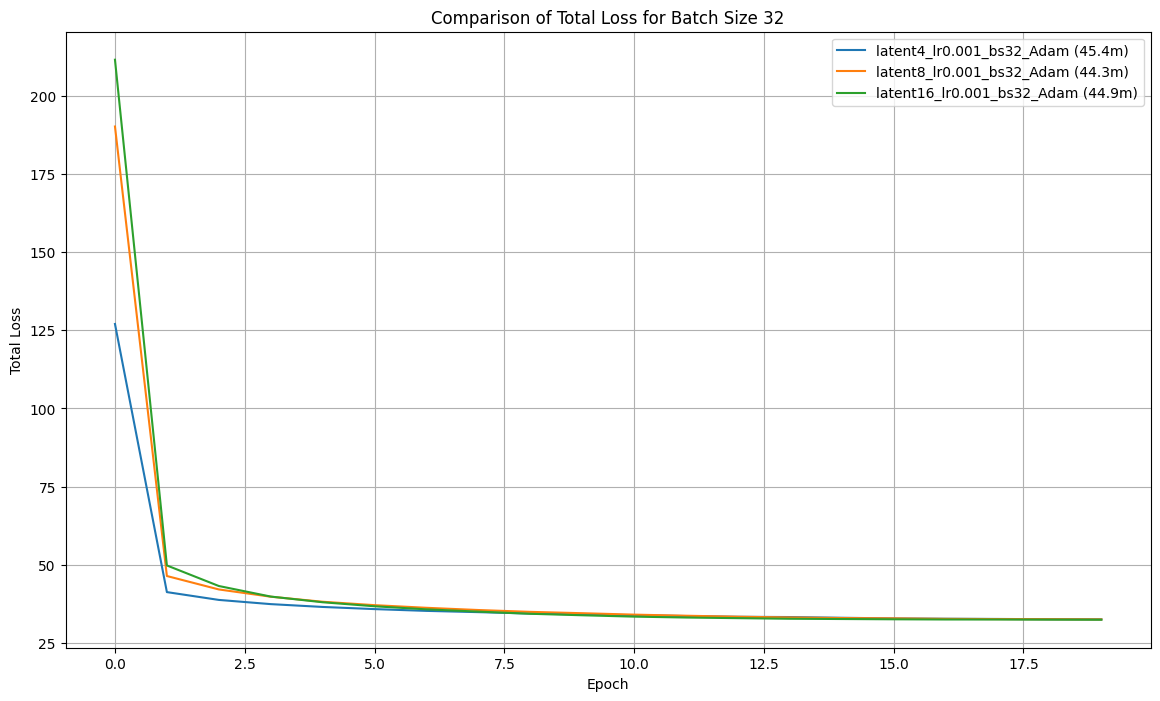

Batch-specific comparison plot saved: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Plots/Fixed/comparison_total_loss_batch32_updated.png


In [ ]:
#@title With Hyperparameter Tuning (10,000) - Retrained
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameter candidates
latent_dims = [4, 8, 16]
learning_rates = [0.001]
batch_sizes = [16, 32]
num_epochs = 20
optimizers = ['Adam']

# Loss function
mse_loss = nn.MSELoss(reduction='sum')

# VAE loss function (Reconstruction Loss + KL Divergence Loss)
def vae_loss(recon_x, x, mu, logvar):
    reconstruction_loss = mse_loss(recon_x, x)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    total_loss = reconstruction_loss + kl_loss
    return total_loss, reconstruction_loss, kl_loss

# Store all training results
results = []

# Loop through each combination of hyperparameters
for latent_dim in latent_dims:
    for lr in learning_rates:
        for batch_size in batch_sizes:
            for opt_name in optimizers:
                print(f"\n[Training] latent_dim: {latent_dim}, lr: {lr}, batch_size: {batch_size}, optimizer: {opt_name}")

                # Create DataLoader for each batch size
                train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=batch_size, shuffle=True)

                # Initialize model and optimizer
                model = VAE_CNN(latent_dim=latent_dim).to(device)
                optimizer = optim.Adam(model.parameters(), lr=lr)

                train_loss_history = []
                recon_loss_history = []
                kl_loss_history = []

                # Start training timer
                start_time = time.time()

                # Training loop
                for epoch in tqdm(range(num_epochs), desc=f"Training {latent_dim}, lr {lr}, bs {batch_size}, opt {opt_name}"):
                    model.train()
                    total_loss, total_recon_loss, total_kl_loss = 0, 0, 0

                    for batch in train_loader:
                        x_batch = batch[0].to(device)

                        optimizer.zero_grad()
                        recon_batch, mu, logvar = model(x_batch)
                        loss, recon_loss, kl = vae_loss(recon_batch, x_batch, mu, logvar)
                        loss.backward()
                        optimizer.step()

                        total_loss += loss.item()
                        total_recon_loss += recon_loss.item()
                        total_kl_loss += kl.item()

                    avg_loss = total_loss / len(train_loader.dataset)
                    avg_recon_loss = total_recon_loss / len(train_loader.dataset)
                    avg_kl_loss = total_kl_loss / len(train_loader.dataset)

                    train_loss_history.append(avg_loss)
                    recon_loss_history.append(avg_recon_loss)
                    kl_loss_history.append(avg_kl_loss)

                    tqdm.write(f"Epoch [{epoch+1}/{num_epochs}] - kl: {avg_kl_loss:.4f} - loss: {avg_loss:.4f} - recon: {avg_recon_loss:.4f}")

                # End training timer
                end_time = time.time()
                duration = end_time - start_time
                print(f"Training duration: {duration/60:.2f} minutes")

                # Save results
                results.append({
                    'latent_dim': latent_dim,
                    'batch_size': batch_size,
                    'optimizer': opt_name,
                    'learning_rate': lr,
                    'label': f'latent{latent_dim}_lr{lr}_bs{batch_size}_{opt_name}',
                    'train_loss_history': train_loss_history,
                    'duration': duration
                })

                # Plot individual loss curves
                plt.figure(figsize=(12,6))
                plt.plot(train_loss_history, label='Total Loss')
                plt.plot(recon_loss_history, label='Reconstruction Loss')
                plt.plot(kl_loss_history, label='KL Divergence Loss')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.title(f'Loss Curves\nlatent_dim={latent_dim}, lr={lr}, batch_size={batch_size}, optimizer={opt_name}')
                plt.legend()
                plt.grid()

                # Save plot
                plot_path = f"/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Plots/Fixed/loss_latent{latent_dim}_lr{lr}_bs{batch_size}_opt{opt_name}.png"
                plt.savefig(plot_path)
                plt.show()
                plt.close()

                print(f"Plot saved: {plot_path}")

                # Save the model
                model_path = f"/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/vae_cnn_latent{latent_dim}_lr{lr}_bs{batch_size}_opt{opt_name}.pth"
                torch.save(model.state_dict(), model_path)
                print(f"Model trained and saved successfully at: {model_path}")

# Global comparison: Plot total loss between all hyperparameter combinations
plt.figure(figsize=(14,8))
for result in results:
    plt.plot(result['train_loss_history'], label=f"{result['label']} ({result['duration']/60:.1f}m)")
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Comparison of Total Loss between Hyperparameters')
plt.legend()
plt.grid()

# Save global comparison plot
comparison_plot_path = "/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Plots/Fixed/comparison_total_loss_updated.png"
plt.savefig(comparison_plot_path)
plt.show()
plt.close()

print(f"Comparison plot saved: {comparison_plot_path}")

# Plot comparison for each batch size separately
batch_sizes_unique = sorted(set([r['batch_size'] for r in results]))

for batch_size in batch_sizes_unique:
    plt.figure(figsize=(14,8))
    batch_results = [r for r in results if r['batch_size'] == batch_size]

    for result in batch_results:
        plt.plot(result['train_loss_history'], label=f"{result['label']} ({result['duration']/60:.1f}m)")

    plt.xlabel('Epoch')
    plt.ylabel('Total Loss')
    plt.title(f'Comparison of Total Loss for Batch Size {batch_size}')
    plt.legend()
    plt.grid()

    # Save batch-specific plot
    batch_plot_path = f"/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Plots/Fixed/comparison_total_loss_batch{batch_size}_updated.png"
    plt.savefig(batch_plot_path)
    plt.show()
    plt.close()

    print(f"Batch-specific comparison plot saved: {batch_plot_path}")


6. Model Evaluation

In [ ]:
#@title Load Trained Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE_CNN(latent_dim=8).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/vae_cnn_latent8_lr0.001_bs16_optAdam.pth'))
model.eval()
print("Model loaded successfully!")

Model loaded successfully!


<ipython-input-50-40fd231cea1e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/D

In [ ]:
#@title Threshold Selection with Percentile

# Dataset & DataLoader
batch_size = 128
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model Evaluation per Batch
model.eval()
losses, labels = [], []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        recon, _, _ = model(x)
        batch_loss = torch.mean((recon - x) ** 2, dim=(1, 2, 3))
        losses.append(batch_loss.cpu())
        labels.append(y.cpu())

loss_per_sample = torch.cat(losses)
labels = torch.cat(labels).int()

# Thresholds from Various Percentiles (1%-99%)
percentiles = list(range(1, 100))
thresholds = [torch.quantile(loss_per_sample[labels == 0], p / 100) for p in percentiles]

results = []

print("\n=== Percentile-based Evaluation ===")
for p, thresh in zip(percentiles, thresholds):
    preds = (loss_per_sample > thresh).int()
    cm = confusion_matrix(labels, preds)
    precision = precision_score(labels, preds, zero_division=0)
    recall = recall_score(labels, preds, zero_division=0)
    f1 = f1_score(labels, preds, zero_division=0)
    results.append((p, thresh.item(), precision, recall, f1))

    print(f"\n--- Percentile {p}% ---")
    print(f"Threshold : {thresh.item():.6f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1 Score  : {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")

# Metric vs Percentile Visualization
percentiles, thresholds, precisions, recalls, f1s = zip(*results)

plt.figure(figsize=(12, 6))
plt.plot(percentiles, precisions, label="Precision", marker='.')
plt.plot(percentiles, recalls, label="Recall", marker='.')
plt.plot(percentiles, f1s, label="F1 Score", marker='.')
plt.xlabel("Percentile Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, F1 Score vs Threshold Percentile")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Threshold Value vs Percentile Visualization
plt.figure(figsize=(10, 4))
plt.plot(percentiles, thresholds, label="Threshold Value", color='black')
plt.xlabel("Percentile")
plt.ylabel("Threshold")
plt.title("Threshold Value vs Percentile")
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-126-219d17a5b694>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(info['path']))



Model loaded: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/vae_cnn_latent4_lr0.001_bs16_optAdam.pth with latent_dim=4
Precision: 0.8199
Recall   : 0.8193
F1-score : 0.8196


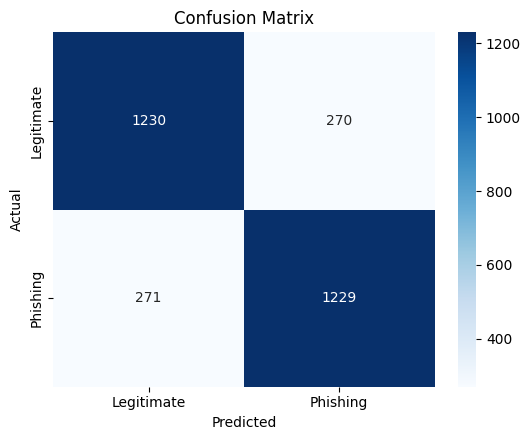

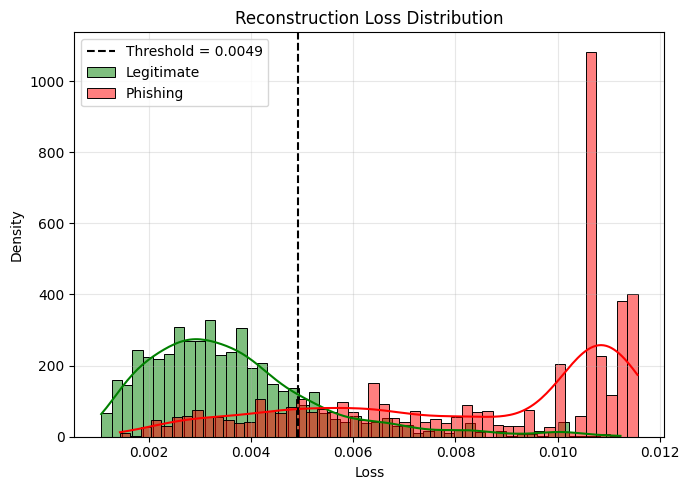

<ipython-input-126-219d17a5b694>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(info['path']))



Model loaded: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/vae_cnn_latent4_lr0.001_bs32_optAdam.pth with latent_dim=4
Precision: 0.8193
Recall   : 0.8160
F1-score : 0.8176


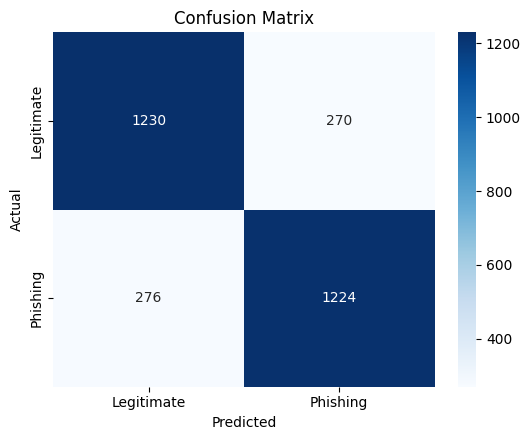

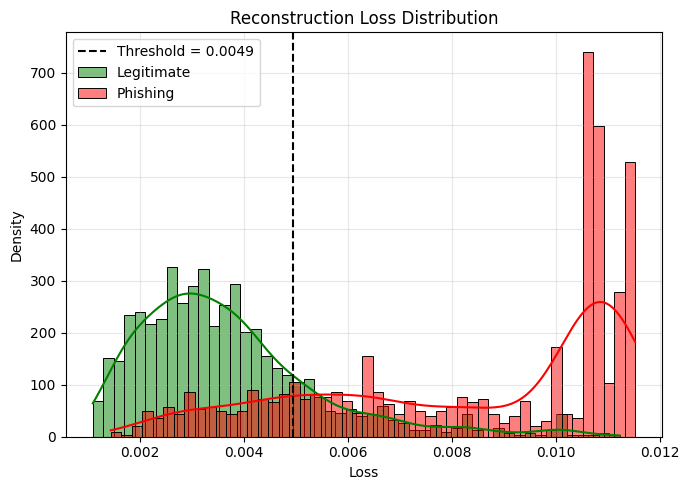

<ipython-input-126-219d17a5b694>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(info['path']))



Model loaded: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/vae_cnn_latent8_lr0.001_bs16_optAdam.pth with latent_dim=8
Precision: 0.8198
Recall   : 0.8187
F1-score : 0.8192


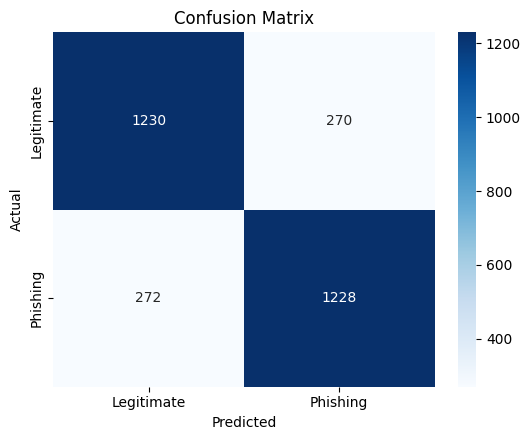

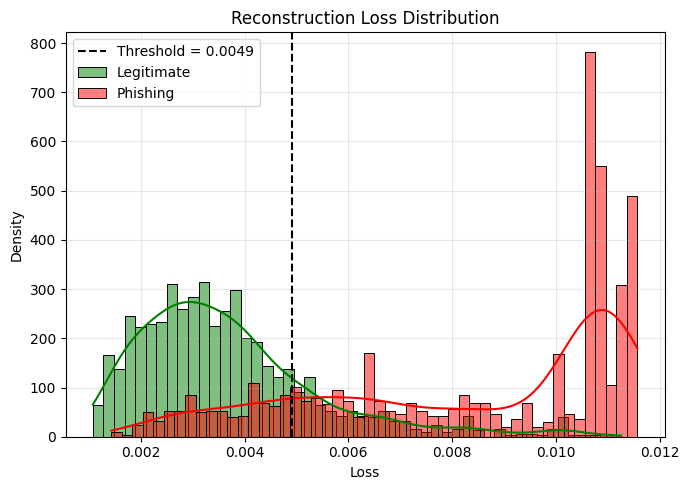

<ipython-input-126-219d17a5b694>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(info['path']))



Model loaded: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/vae_cnn_latent8_lr0.001_bs32_optAdam.pth with latent_dim=8
Precision: 0.8200
Recall   : 0.8200
F1-score : 0.8200


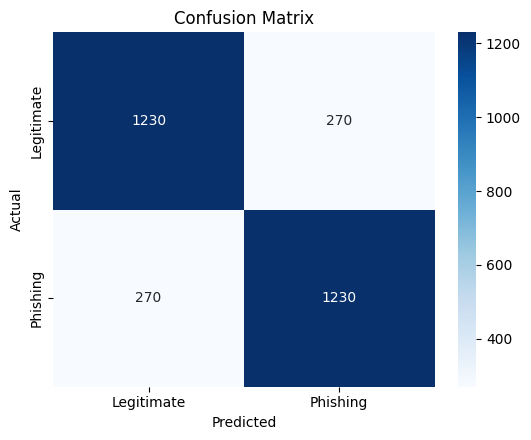

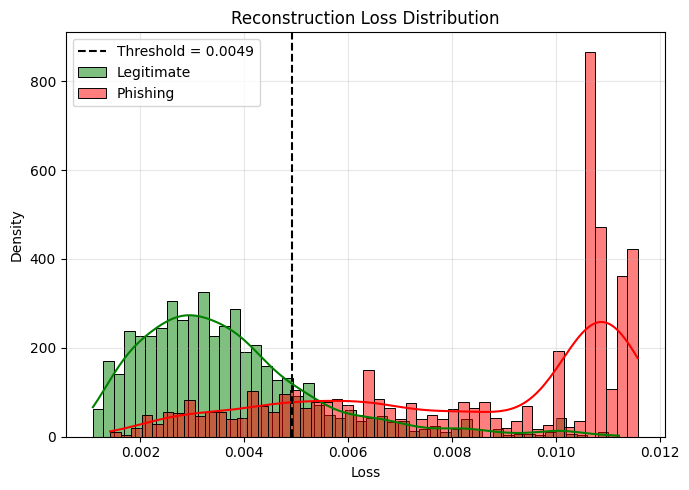

<ipython-input-126-219d17a5b694>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(info['path']))



Model loaded: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/vae_cnn_latent16_lr0.001_bs16_optAdam.pth with latent_dim=16
Precision: 0.8193
Recall   : 0.8160
F1-score : 0.8176


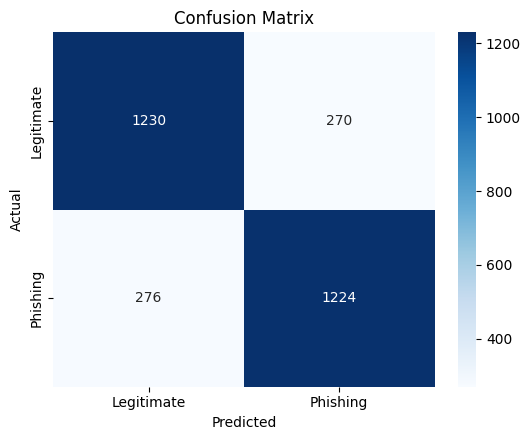

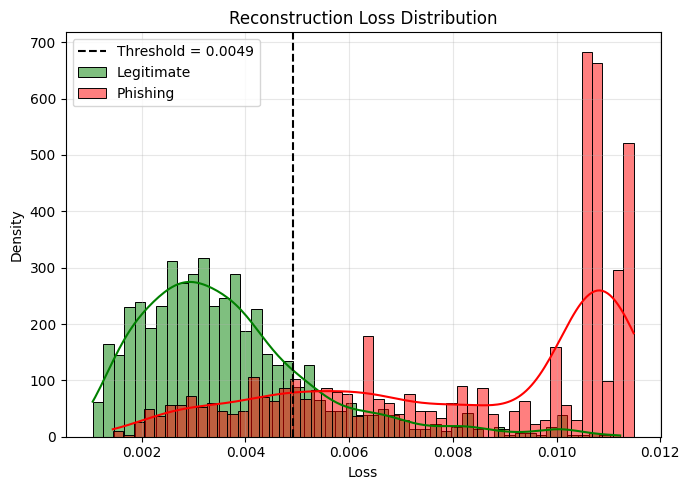

<ipython-input-126-219d17a5b694>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(info['path']))



Model loaded: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/vae_cnn_latent16_lr0.001_bs32_optAdam.pth with latent_dim=16
Precision: 0.8198
Recall   : 0.8187
F1-score : 0.8192


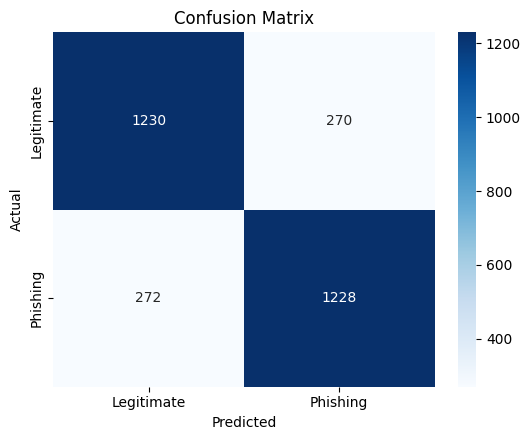

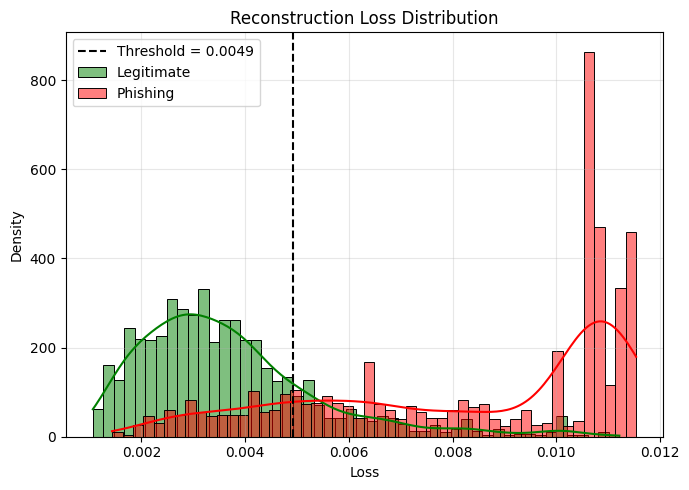


=== Best Model Summary ===
Best model: vae_cnn_latent8_lr0.001_bs32_optAdam.pth, Latent Dim: 8
Precision : 0.8200
Recall    : 0.8200
F1-Score  : 0.8200


In [ ]:
#@title Model Evaluation per Batch

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define models and their corresponding latent dimensions
models_info = [
    {'path': '/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/vae_cnn_latent4_lr0.001_bs16_optAdam.pth', 'latent_dim': 4},
    {'path': '/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/vae_cnn_latent4_lr0.001_bs32_optAdam.pth', 'latent_dim': 4},
    {'path': '/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/vae_cnn_latent8_lr0.001_bs16_optAdam.pth', 'latent_dim': 8},
    {'path': '/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/vae_cnn_latent8_lr0.001_bs32_optAdam.pth', 'latent_dim': 8},
    {'path': '/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/vae_cnn_latent16_lr0.001_bs16_optAdam.pth', 'latent_dim': 16},
    {'path': '/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/vae_cnn_latent16_lr0.001_bs32_optAdam.pth', 'latent_dim': 16},
]

# Initialize tracking variables
best_f1 = 0
best_model_info = {}

# Loop through all models
for info in models_info:
    # Load model
    model = VAE_CNN(latent_dim=info['latent_dim']).to(device)
    model.load_state_dict(torch.load(info['path']))
    model.eval()
    print(f"\nModel loaded: {info['path']} with latent_dim={info['latent_dim']}")

    # Evaluate model
    losses, labels = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            recon, _, _ = model(x)
            batch_loss = torch.mean((recon - x) ** 2, dim=(1, 2, 3))
            losses.append(batch_loss)
            labels.append(y)

    losses = torch.cat(losses)
    labels = torch.cat(labels).int().to(device)

    # Threshold based on quantile
    threshold = torch.quantile(losses[labels == 0], 0.82)
    predictions = (losses > threshold).int()

    # Calculate metrics
    cm = confusion_matrix(labels.cpu(), predictions.cpu())
    precision_val = precision_score(labels.cpu(), predictions.cpu(), zero_division=0)
    recall_val = recall_score(labels.cpu(), predictions.cpu(), zero_division=0)
    f1_val = f1_score(labels.cpu(), predictions.cpu(), zero_division=0)

    print(f"Precision: {precision_val:.4f}")
    print(f"Recall   : {recall_val:.4f}")
    print(f"F1-score : {f1_val:.4f}")

    # Plot Confusion Matrix
    plt.figure(figsize=(5.5, 4.5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Legitimate', 'Phishing'],
                yticklabels=['Legitimate', 'Phishing'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # Plot Reconstruction Loss Distribution
    plt.figure(figsize=(7, 5))
    sns.histplot(losses[labels == 0].cpu().numpy(), bins=50, label='Legitimate', color='green', kde=True, stat='density')
    sns.histplot(losses[labels == 1].cpu().numpy(), bins=50, label='Phishing', color='red', kde=True, stat='density')
    plt.axvline(threshold.item(), color='black', linestyle='--', label=f'Threshold = {threshold.item():.4f}')
    plt.title("Reconstruction Loss Distribution")
    plt.xlabel("Loss")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Track best model
    if f1_val > best_f1:
        best_f1 = f1_val
        best_model_info = {
            'path': info['path'],
            'latent_dim': info['latent_dim'],
            'precision': precision_val,
            'recall': recall_val,
            'f1_score': f1_val
        }

# Print the Best Model Summary
print("\n=== Best Model Summary ===")
print(f"Best model: {best_model_info['path'].split('/')[-1]}, Latent Dim: {best_model_info['latent_dim']}")
print(f"Precision : {best_model_info['precision']:.4f}")
print(f"Recall    : {best_model_info['recall']:.4f}")
print(f"F1-Score  : {best_model_info['f1_score']:.4f}")


7. Save the Best Model

In [ ]:
# Save the best model file
import shutil

# Path target for saving the file
best_model_save_path = '/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/Best_Model.pth'

# Copy the best model
shutil.copy(best_model_info['path'], best_model_save_path)

print(f"Best model has been saved to: {best_model_save_path}")

Best model has been saved to: /content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/Best_Model.pth


8. Model Testing with New Data

In [ ]:
# Load char_to_idx
with open('/content/drive/MyDrive/Thesis - Undergraduate Ch./Preprocessing/vocabulary_tested.json') as f:
    char_to_idx = json.load(f)
char_to_idx = {k: int(v) for k, v in char_to_idx.items()}

vocab_size = len(char_to_idx) + 1
max_len = 100
print("Vocab size:", vocab_size)

# Load Model
model = VAE_CNN(latent_dim=8)
model.load_state_dict(torch.load(
    '/content/drive/MyDrive/Thesis - Undergraduate Ch./Models/Dataset 10000/Training Results/Fixed/Best_Model.pth',
    map_location=device))
model.to(device)
model.eval()

# Preprocess
def preprocess_url(url, char_to_idx, max_len=100, vocab_size=100):
    encoded = np.zeros((max_len, vocab_size), dtype=np.float32)
    for i, ch in enumerate(url[:max_len]):
        if ch in char_to_idx:
            encoded[i, char_to_idx[ch]] = 1.0
    return torch.tensor(encoded).unsqueeze(0).unsqueeze(0).to(device)

# Test URL
new_url = "https://www.uniwisp.co.za/wp-includes/wlwmanifest.xml"
url_tensor = preprocess_url(new_url, char_to_idx, max_len=max_len, vocab_size=vocab_size)

# Predict + Timing
start_time = time.time()

with torch.no_grad():
    reconstructed, _, _ = model(url_tensor)
    loss = torch.mean((reconstructed - url_tensor) ** 2).item()

end_time = time.time()

# Decision
if loss > threshold:
    print(f"PHISHING (Loss: {loss:.4f})")
else:
    print(f"LEGITIMATE (Loss: {loss:.4f})")

# Display Inference Time
duration = (end_time - start_time) * 1000
print(f"Detection Time: {duration:.2f} ms")


Vocab size: 87
LEGITIMATE (Loss: 0.0031)
Detection Time: 16.10 ms


<ipython-input-129-21b32263e8e4>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(
